In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from numpy import arange, meshgrid
#
from smt.sampling_methods import LHS
# Seeds
torch.manual_seed(123)
np.random.seed(123)
def train(epoch):
    model.train()
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,v_ic_train,p_ic_train)   # Loss function of IC
        loss_bdL = model.loss_bc(x_bcL_train, rho_bcL_train,u_bcL_train,v_bcL_train,p_bcL_train)   # Loss function of IC
        loss_bdR = model.loss_bc1(x_bcR_train,rho_bcR_train,u_bcR_train,v_bcR_train,p_bcR_train)   # Loss function of IC
        loss_cut = model.loss_bc1(x_cut_train,rho_cut_train,u_cut_train,v_cut_train,p_cut_train) 
        loss_bdI = model.bd_B(x_bcI_train, sin_bcI_train,cos_bcI_train)  

        loss_ib = loss_ic + loss_bdL + loss_bdI
        loss = loss_pde + 10*loss_ib

        # Print iteration, loss of PDE and ICs
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ib:{loss_ib:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))
def IC(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    ms = 3.0
    rho1 = 1.0
    p1 = 0.71429
    v1 = 0.0
    #u1 = ms*npsqrt(gamma)
    u1 = 3.0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] =   u1
        v_init[i] =  v1
        p_init[i] =  p1

    return rho_init, u_init, v_init,p_init

def BC_L(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    ms = 3.0
    rho1 = 12.25
    p1 = 1.012536
    v1 = 0.0
    #u1 = ms*np.sqrt(gamma)
    u1 = 1.3606963
    #gamma = 1.4
    #ms = 3.0
    #rho1 = 1.0
    #p1 = 1.0
    #v1 = 0.0
    #u1 = ms*np.sqrt(gamma)
    # rho, p - initial condition
    for i in range(N):
        #rho_init[i] = rho1
        #u_init[i] = u1
        #v_init[i] = v1
        #p_init[i] = p1
        
        rho_init[i] = 1.6298
        u_init[i] =  1.15467
        v_init[i] = 0
        p_init[i] = 15.91

    return rho_init, u_init, v_init,p_init
def BC_R(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    ms = 2.0
    rho1 = 1.0
    p1 = 1.0
    v1 = 0.0
    u1 = 0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] = u1
        v_init[i] = v1
        p_init[i] = p1

    return rho_init, u_init, v_init,p_init
def BC_Cut(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))
    u_init = np.zeros((x.shape[0]))
    v_init = np.zeros((x.shape[0]))
    p_init = np.zeros((x.shape[0]))
    
    gamma = 1.4
    ms = 2.0
    rho1 = 1.0
    p1 = 1.0
    v1 = 0.0
    u1 = 0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = 10.01
        u_init[i] =  0
        v_init[i] = 0
        p_init[i] = 10.01

    return rho_init, u_init, v_init,p_init
    
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(3, 90))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(90, 90))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(90, 4))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    def bd_B(self,x,sin,cos):
        yb = self.net(x)
        rhob,pb,ub,vb = yb[:, 0:1], yb[:, 1:2], yb[:, 2:3],yb[:,3:]
        drhob_g = gradients(rhob, x)[0]                                      # Gradient [u_t, u_x]
        rhob_x, rhob_y = drhob_g[:, 1:2], drhob_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dub_g = gradients(ub, x)[0]                                      # Gradient [u_t, u_x]
        ub_x, ub_y = dub_g[:, 1:2], dub_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dvb_g = gradients(vb, x)[0]                                      # Gradient [u_t, u_x]
        vb_x, vb_y = dvb_g[:, 1:2], dvb_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dpb_g = gradients(pb, x)[0]                                      # Gradient [p_t, p_x]
        pb_x, pb_y = dpb_g[:, 1:2], dpb_g[:, 2:3]                            # Partial derivatives p_t, p_x
        
        #deltau = ub_x + vb_y
        #lam = 0.1*(abs(deltau) - deltau) + 1
        #lam = (deltau) - deltau) + 1
        
        fb = (((ub*cos + vb*sin))**2).mean() +\
            (((pb_x*cos + pb_y*sin))**2).mean() #+\
            #(((rhob_x*cos + rhob_y*sin))**2).mean()
        return fb
    def bd_OY(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_y)/lam)**2).mean() +\
            ((( v_y)/lam)**2).mean() +\
            ((( p_y)/lam)**2).mean() +\
            ((( rho_y)/lam)**2).mean()
        return f
    
    def bd_OX(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_x)/lam)**2).mean() +\
            ((( v_x)/lam)**2).mean() +\
            ((( p_x)/lam)**2).mean() +\
            ((( rho_x)/lam)**2).mean()
        return f
     
    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        gamma = 1.4                                                    # Heat Capacity Ratio
        epsilon = 1e-5
        s = torch.log((abs(p)+epsilon)/(abs(rho)+epsilon)**1.4)
        eta = -rho*s
        phi1 = -rho*u*s
        phi2 = -rho*v*s
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2],drho_g[:,2:]
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x, u_y = du_g[:, :1], du_g[:, 1:2], du_g[:,2:]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_t, v_x, v_y = dv_g[:, :1], dv_g[:, 1:2], dv_g[:,2:]                            # Partial derivatives u_t, u_x
        
        
        deta_g = gradients(eta, x)[0]                                      # Gradient [p_t, p_x]
        eta_t, eta_x,eta_y = deta_g[:, :1], deta_g[:, 1:2],deta_g[2:3]                            # Partial derivatives p_t, p_x
        dphi1_g = gradients(phi1, x)[0]                                      # Gradient [p_t, p_x]
        dphi2_g = gradients(phi2, x)[0]                                      # Gradient [p_t, p_x]
        phi1_t, phi1_x,phi1_y = dphi1_g[:, :1], dphi1_g[:, 1:2],dphi1_g[:,2:3]                           # Partial derivatives p_t, p_x
        phi2_t, phi2_x,phi2_y = dphi2_g[:, :1], dphi2_g[:, 1:2],dphi2_g[:,2:3]                           # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        nab = abs(deltau) - deltau
        
        q = 0.1*(rho*nab**2)
        
        lam = 0.1*nab + 1
        
       # p = p+q
        
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x, p_y = dp_g[:, :1], dp_g[:, 1:2], dp_g[:,2:]                            # Partial derivatives p_t, p_x
        

        f = (((rho_t+rho*deltau+u*rho_x + v*rho_y)/lam)**2).mean() +\
            (((rho*u_t+rho*u*u_x+rho*v*u_y+p_x)/lam)**2).mean() +\
            (((rho*v_t+rho*u*v_x+rho*v*v_y+p_y)/lam)**2).mean() +\
            (((p_t+u*p_x+v*p_y+1.4*p*deltau)/lam)**2).mean() #+ \
            #((abs(rho-12) - (rho-12))**2).mean()  # + \
            #(((abs(eta_t+phi1_x + phi2_y)+eta_t+phi1_x+ phi2_y))**2).mean()
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics

    def loss_bc(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics
    def loss_bc1(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() 

        return loss_ics

def BD_circle(t,xc,yc,r,n):
    x = np.zeros((n,3)) 
    sin = np.zeros((n,1)) 
    cos = np.zeros((n,1)) 

    for i in range(n):
        the = np.random.rand()*np.pi
        xd = np.cos(the + np.pi/2)
        yd = np.sin(the + np.pi/2)
        x[i,0] = np.random.rand()*t
        x[i,1] = xc  + xd*r
        x[i,2] = yc  + yd*r
        cos[i,0] = xd 
        sin[i,0] = yd
        #cos[i,0] = 1
        #sin[i,0] = 0
    return x, sin,cos
def BD_front(n1,n2):
    x = np.zeros((n1+n2,2)) 
    for i in range(n1):
        x[i,0] = 1.0
        x[i,1] = i*(0.2/n1)
    for i in range(n1,n2):
        x[i,0] = 1.0 + (3.0/n1)
        x[i,1] = 0.2
    return x

# Solve Euler equations using PINNs
# def main():
  # Initialization
#device = torch.device('cuda')                                          # Run on CPU
device = torch.device('cuda')                                          # Run on CPU
lr = 0.0001                                                           # Learning rate
num_ib = 1000                                                # Random sampled points from IC0
num_int = 10000                                                # Random sampled points in interior
Tend = 1.0
Lx = 1.0
Ly = 2.0
rx = 1.0
ry = 1.0
rd = 0.3

xlimits = np.array([[0.0,Tend],[0.0, Lx], [0.0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)
A = []
for i in range(num_int):
    x = x_int_train[i,1]
    y = x_int_train[i,2]
    if ((x-rx)**2 + (y-ry)**2 ) < rd**2:
        A.append(i)
x_int_train = np.delete(x_int_train,A,axis=0)

x_cut_train = np.zeros((num_ib,3))
for i in range(num_ib):
    theta = np.random.rand()*np.pi + np.pi/2
    r = np.random.rand()*rd
    x_cut_train[i,1] = r*np.cos(theta) + 2
    x_cut_train[i,2] = r*np.sin(theta) + 1

xlimits = np.array([[0.0,Tend],[0.0, 0.0], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcL_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [Lx, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcR_train =  sampling(num_ib)


xlimits = np.array([[0.0,Tend],[0.0, Lx], [Ly,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcU_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [0.0, Lx], [0.0,0.0]])
sampling = LHS(xlimits=xlimits)
x_bcD_train =  sampling(num_ib)                                           # Vectorized whole domain

xlimits = np.array([[0.0,0.0],[0.0, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_ic_train =  sampling(num_ib)
A = []
for i in range(num_ib):
    x = x_ic_train[i,1]
    y = x_ic_train[i,2]
    if ((x-rx)**2 + (y-ry)**2 ) < rd**2:
        A.append(i)
x_ic_train = np.delete(x_ic_train,A,axis=0)


x_bcI_train,sin_bcI_train,cos_bcI_train = BD_circle(Tend,rx,ry,rd,num_ib)

rho_bcL_train, u_bcL_train,v_bcL_train, p_bcL_train = BC_L(x_bcL_train)  
rho_bcR_train, u_bcR_train,v_bcR_train, p_bcR_train = BC_L(x_bcR_train)  
rho_cut_train, u_cut_train,v_cut_train, p_cut_train = BC_Cut(x_cut_train)  

rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)  


x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_bcL_train = torch.tensor(rho_bcL_train, dtype=torch.float32).to(device)
u_bcL_train = torch.tensor(u_bcL_train, dtype=torch.float32).to(device)
v_bcL_train = torch.tensor(v_bcL_train, dtype=torch.float32).to(device)
p_bcL_train = torch.tensor(p_bcL_train, dtype=torch.float32).to(device)

rho_bcR_train = torch.tensor(rho_bcR_train, dtype=torch.float32).to(device)
u_bcR_train = torch.tensor(u_bcR_train, dtype=torch.float32).to(device)
v_bcR_train = torch.tensor(v_bcR_train, dtype=torch.float32).to(device)
p_bcR_train = torch.tensor(p_bcR_train, dtype=torch.float32).to(device)

x_bcD_train = torch.tensor(x_bcD_train,requires_grad=True, dtype=torch.float32).to(device)
x_bcU_train = torch.tensor(x_bcU_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcR_train = torch.tensor(x_bcR_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcL_train = torch.tensor(x_bcL_train, dtype=torch.float32).to(device)
x_bcI_train = torch.tensor(x_bcI_train, requires_grad=True, dtype=torch.float32).to(device)
sin_bcI_train = torch.tensor(sin_bcI_train, dtype=torch.float32).to(device)
cos_bcI_train = torch.tensor(cos_bcI_train, dtype=torch.float32).to(device)

rho_cut_train = torch.tensor(rho_cut_train, dtype=torch.float32).to(device)
u_cut_train = torch.tensor(u_cut_train, dtype=torch.float32).to(device)
v_cut_train = torch.tensor(v_cut_train, dtype=torch.float32).to(device)
p_cut_train = torch.tensor(p_cut_train, dtype=torch.float32).to(device)
x_cut_train = torch.tensor(x_cut_train, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)


#rho_ic_train.clone().detach().requires_grad_(True)
#u_ic_train.clone().detach().requires_grad_(True)
# Initialize neural network

print('Start training...')

Start training...


In [2]:
model = DNN().to(device)

In [8]:
lr = 0.001
optimizer = torch.optim.LBFGS(model.parameters(),lr=lr,max_iter=500)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
epochs = 30000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1 loss_pde:2.76693463, loss_ib:0.82834744
epoch 1 loss_pde:2.76718402, loss_ib:0.82829595
epoch 1 loss_pde:2.76630878, loss_ib:0.82811451
epoch 1 loss_pde:2.76649284, loss_ib:0.82806408
epoch 1 loss_pde:2.76663041, loss_ib:0.82801712
epoch 1 loss_pde:2.76687217, loss_ib:0.82794309
epoch 1 loss_pde:2.76708245, loss_ib:0.82785881
epoch 1 loss_pde:2.76730633, loss_ib:0.82778203
epoch 1 loss_pde:2.76738310, loss_ib:0.82770699
epoch 1 loss_pde:2.76758885, loss_ib:0.82762933
epoch 1 loss_pde:2.76780343, loss_ib:0.82754731
epoch 1 loss_pde:2.76802754, loss_ib:0.82746148
epoch 1 loss_pde:2.76825476, loss_ib:0.82737088
epoch 1 loss_pde:2.76848507, loss_ib:0.82727700
epoch 1 loss_pde:2.76871872, loss_ib:0.82718074
epoch 1 loss_pde:2.76895046, loss_ib:0.82708198
epoch 1 loss_pde:2.76918221, loss_ib:0.82698226
epoch 1 loss_pde:2.76941371, loss_ib:0.82688087
epoch 1 loss_pde:2.76964116, loss_ib:0.82677883
epoch 1 loss_pde:2.76986885, loss_ib:0.82667565
epoch 1 loss_pde:2.77009273, loss_ib:0.8

epoch 1 loss_pde:2.77747393, loss_ib:0.81543368
epoch 1 loss_pde:2.77713418, loss_ib:0.81536877
epoch 1 loss_pde:2.77706122, loss_ib:0.81529725
epoch 1 loss_pde:2.77699614, loss_ib:0.81523383
epoch 1 loss_pde:2.77692866, loss_ib:0.81517017
epoch 1 loss_pde:2.77686620, loss_ib:0.81510651
epoch 1 loss_pde:2.77679753, loss_ib:0.81504309
epoch 1 loss_pde:2.77673030, loss_ib:0.81497937
epoch 1 loss_pde:2.77666306, loss_ib:0.81491584
epoch 1 loss_pde:2.77659559, loss_ib:0.81485271
epoch 1 loss_pde:2.77652764, loss_ib:0.81478947
epoch 1 loss_pde:2.77645779, loss_ib:0.81472588
epoch 1 loss_pde:2.77639031, loss_ib:0.81466234
epoch 1 loss_pde:2.77632284, loss_ib:0.81459987
epoch 1 loss_pde:2.77625513, loss_ib:0.81453657
epoch 1 loss_pde:2.77618790, loss_ib:0.81447333
epoch 1 loss_pde:2.77612066, loss_ib:0.81440997
epoch 1 loss_pde:2.77605200, loss_ib:0.81434721
epoch 1 loss_pde:2.77598596, loss_ib:0.81428409
epoch 1 loss_pde:2.77591610, loss_ib:0.81422096
epoch 1 loss_pde:2.77585125, loss_ib:0.8

epoch 1 loss_pde:2.73851800, loss_ib:0.79912055
epoch 1 loss_pde:2.73824215, loss_ib:0.79903877
epoch 1 loss_pde:2.73800826, loss_ib:0.79894722
epoch 1 loss_pde:2.73767781, loss_ib:0.79886085
epoch 1 loss_pde:2.73746037, loss_ib:0.79875338
epoch 1 loss_pde:2.73711729, loss_ib:0.79867041
epoch 1 loss_pde:2.73702931, loss_ib:0.79855943
epoch 1 loss_pde:2.73671198, loss_ib:0.79847181
epoch 1 loss_pde:2.73649669, loss_ib:0.79837716
epoch 1 loss_pde:2.73611069, loss_ib:0.79829472
epoch 1 loss_pde:2.73592544, loss_ib:0.79816687
epoch 1 loss_pde:2.73558164, loss_ib:0.79807878
epoch 1 loss_pde:2.73531818, loss_ib:0.79798758
epoch 1 loss_pde:2.73499203, loss_ib:0.79789972
epoch 1 loss_pde:2.73469114, loss_ib:0.79780567
epoch 1 loss_pde:2.73438811, loss_ib:0.79771280
epoch 1 loss_pde:2.73415661, loss_ib:0.79760838
epoch 1 loss_pde:2.73386598, loss_ib:0.79751784
epoch 1 loss_pde:2.73354506, loss_ib:0.79742563
epoch 1 loss_pde:2.73432255, loss_ib:0.79714859
epoch 1 loss_pde:2.73403049, loss_ib:0.7

epoch 2 loss_pde:2.65979743, loss_ib:0.77438867
epoch 2 loss_pde:2.65954089, loss_ib:0.77429700
epoch 2 loss_pde:2.65926719, loss_ib:0.77420616
epoch 2 loss_pde:2.65886545, loss_ib:0.77401030
epoch 2 loss_pde:2.65863657, loss_ib:0.77391696
epoch 2 loss_pde:2.65840173, loss_ib:0.77382797
epoch 2 loss_pde:2.65816236, loss_ib:0.77374005
epoch 2 loss_pde:2.65780687, loss_ib:0.77366084
epoch 2 loss_pde:2.65754461, loss_ib:0.77356184
epoch 2 loss_pde:2.65728831, loss_ib:0.77347463
epoch 2 loss_pde:2.65700102, loss_ib:0.77315831
epoch 2 loss_pde:2.65678048, loss_ib:0.77307272
epoch 2 loss_pde:2.65657544, loss_ib:0.77299988
epoch 2 loss_pde:2.65636444, loss_ib:0.77292728
epoch 2 loss_pde:2.65613270, loss_ib:0.77283990
epoch 2 loss_pde:2.65592742, loss_ib:0.77276927
epoch 2 loss_pde:2.65571237, loss_ib:0.77269852
epoch 2 loss_pde:2.65550089, loss_ib:0.77262604
epoch 2 loss_pde:2.65525341, loss_ib:0.77255297
epoch 2 loss_pde:2.65507388, loss_ib:0.77246171
epoch 2 loss_pde:2.65474463, loss_ib:0.7

epoch 2 loss_pde:2.52135205, loss_ib:0.75045985
epoch 2 loss_pde:2.52071238, loss_ib:0.75030845
epoch 2 loss_pde:2.51984000, loss_ib:0.75021929
epoch 2 loss_pde:2.51894236, loss_ib:0.75011170
epoch 2 loss_pde:2.51798916, loss_ib:0.75001025
epoch 2 loss_pde:2.51737618, loss_ib:0.74984568
epoch 2 loss_pde:2.51649714, loss_ib:0.74974447
epoch 2 loss_pde:2.51537943, loss_ib:0.74964106
epoch 2 loss_pde:2.51436853, loss_ib:0.74953556
epoch 2 loss_pde:2.51336432, loss_ib:0.74942982
epoch 2 loss_pde:2.51232529, loss_ib:0.74932671
epoch 2 loss_pde:2.51134372, loss_ib:0.74921608
epoch 2 loss_pde:2.51018572, loss_ib:0.74911439
epoch 2 loss_pde:2.50919938, loss_ib:0.74898601
epoch 2 loss_pde:2.50652766, loss_ib:0.74881810
epoch 2 loss_pde:2.50551462, loss_ib:0.74871027
epoch 2 loss_pde:2.50452685, loss_ib:0.74861145
epoch 2 loss_pde:2.50354481, loss_ib:0.74851269
epoch 2 loss_pde:2.50255346, loss_ib:0.74841487
epoch 2 loss_pde:2.50156426, loss_ib:0.74831665
epoch 2 loss_pde:2.50056601, loss_ib:0.7

epoch 2 loss_pde:2.30543208, loss_ib:0.73590457
epoch 2 loss_pde:2.30443096, loss_ib:0.73585427
epoch 2 loss_pde:2.30343103, loss_ib:0.73580205
epoch 2 loss_pde:2.30242443, loss_ib:0.73575079
epoch 2 loss_pde:2.30142307, loss_ib:0.73569775
epoch 2 loss_pde:2.30040598, loss_ib:0.73564637
epoch 2 loss_pde:2.29934287, loss_ib:0.73558784
epoch 2 loss_pde:2.29832649, loss_ib:0.73553783
epoch 2 loss_pde:2.29733443, loss_ib:0.73548043
epoch 2 loss_pde:2.29626775, loss_ib:0.73542720
epoch 2 loss_pde:2.29524755, loss_ib:0.73537081
epoch 2 loss_pde:2.29412460, loss_ib:0.73531240
epoch 2 loss_pde:2.29315209, loss_ib:0.73525536
epoch 2 loss_pde:2.29215598, loss_ib:0.73520219
epoch 2 loss_pde:2.29102492, loss_ib:0.73514646
epoch 2 loss_pde:2.29001880, loss_ib:0.73509812
epoch 2 loss_pde:2.28905082, loss_ib:0.73504382
epoch 2 loss_pde:2.28788090, loss_ib:0.73500329
epoch 2 loss_pde:2.28674603, loss_ib:0.73493844
epoch 2 loss_pde:2.28568053, loss_ib:0.73488796
epoch 2 loss_pde:2.28565121, loss_ib:0.7

epoch 3 loss_pde:2.14247394, loss_ib:0.72214711
epoch 3 loss_pde:2.14127779, loss_ib:0.72199821
epoch 3 loss_pde:2.14016891, loss_ib:0.72186518
epoch 3 loss_pde:2.13912606, loss_ib:0.72173709
epoch 3 loss_pde:2.13808632, loss_ib:0.72161222
epoch 3 loss_pde:2.13706279, loss_ib:0.72148645
epoch 3 loss_pde:2.13604021, loss_ib:0.72136146
epoch 3 loss_pde:2.13502216, loss_ib:0.72123748
epoch 3 loss_pde:2.13401794, loss_ib:0.72111249
epoch 3 loss_pde:2.13298821, loss_ib:0.72099125
epoch 3 loss_pde:2.13214779, loss_ib:0.72084403
epoch 3 loss_pde:2.13117456, loss_ib:0.72072315
epoch 3 loss_pde:2.13019872, loss_ib:0.72059733
epoch 3 loss_pde:2.12918258, loss_ib:0.72047597
epoch 3 loss_pde:2.12832808, loss_ib:0.72034162
epoch 3 loss_pde:2.12743258, loss_ib:0.72022837
epoch 3 loss_pde:2.12513256, loss_ib:0.72007918
epoch 3 loss_pde:2.12424541, loss_ib:0.71995759
epoch 3 loss_pde:2.12326908, loss_ib:0.71983266
epoch 3 loss_pde:2.12231112, loss_ib:0.71970558
epoch 3 loss_pde:2.12131476, loss_ib:0.7

epoch 3 loss_pde:2.00230241, loss_ib:0.70562017
epoch 3 loss_pde:2.00154829, loss_ib:0.70554924
epoch 3 loss_pde:2.00078750, loss_ib:0.70547873
epoch 3 loss_pde:1.99999714, loss_ib:0.70540810
epoch 3 loss_pde:1.99892640, loss_ib:0.70531285
epoch 3 loss_pde:1.99820125, loss_ib:0.70524001
epoch 3 loss_pde:1.99752331, loss_ib:0.70516080
epoch 3 loss_pde:1.99653816, loss_ib:0.70508194
epoch 3 loss_pde:1.99577606, loss_ib:0.70500743
epoch 3 loss_pde:1.99490058, loss_ib:0.70492613
epoch 3 loss_pde:1.99369419, loss_ib:0.70487285
epoch 3 loss_pde:1.99293494, loss_ib:0.70479620
epoch 3 loss_pde:1.99215722, loss_ib:0.70473081
epoch 3 loss_pde:1.99148095, loss_ib:0.70465451
epoch 3 loss_pde:1.99049449, loss_ib:0.70459771
epoch 3 loss_pde:1.98977804, loss_ib:0.70452547
epoch 3 loss_pde:1.98900104, loss_ib:0.70446187
epoch 3 loss_pde:1.98832655, loss_ib:0.70438528
epoch 3 loss_pde:1.98751760, loss_ib:0.70432180
epoch 3 loss_pde:1.98683000, loss_ib:0.70424783
epoch 3 loss_pde:1.98603582, loss_ib:0.7

epoch 3 loss_pde:1.87914169, loss_ib:0.69408518
epoch 3 loss_pde:1.87832880, loss_ib:0.69400823
epoch 3 loss_pde:1.87760150, loss_ib:0.69393194
epoch 3 loss_pde:1.87687755, loss_ib:0.69385850
epoch 3 loss_pde:1.87616765, loss_ib:0.69376892
epoch 3 loss_pde:1.87541807, loss_ib:0.69368863
epoch 3 loss_pde:1.87471807, loss_ib:0.69360137
epoch 3 loss_pde:1.87395072, loss_ib:0.69351852
epoch 3 loss_pde:1.87323642, loss_ib:0.69343156
epoch 3 loss_pde:1.87244618, loss_ib:0.69334751
epoch 3 loss_pde:1.87168527, loss_ib:0.69325614
epoch 3 loss_pde:1.87092423, loss_ib:0.69317502
epoch 3 loss_pde:1.87020195, loss_ib:0.69309366
epoch 3 loss_pde:1.86930501, loss_ib:0.69302213
epoch 3 loss_pde:1.86857247, loss_ib:0.69293773
epoch 3 loss_pde:1.86782873, loss_ib:0.69285727
epoch 3 loss_pde:1.86712170, loss_ib:0.69277179
epoch 3 loss_pde:1.86630225, loss_ib:0.69269097
epoch 3 loss_pde:1.86554897, loss_ib:0.69259858
epoch 3 loss_pde:1.86468256, loss_ib:0.69251764
epoch 3 loss_pde:1.86393535, loss_ib:0.6

epoch 4 loss_pde:1.71179664, loss_ib:0.67376983
epoch 4 loss_pde:1.71102238, loss_ib:0.67366958
epoch 4 loss_pde:1.71024406, loss_ib:0.67356968
epoch 4 loss_pde:1.70949554, loss_ib:0.67346281
epoch 4 loss_pde:1.70866978, loss_ib:0.67336071
epoch 4 loss_pde:1.70782924, loss_ib:0.67325383
epoch 4 loss_pde:1.70686674, loss_ib:0.67312324
epoch 4 loss_pde:1.70605803, loss_ib:0.67301857
epoch 4 loss_pde:1.70534635, loss_ib:0.67291856
epoch 4 loss_pde:1.70462441, loss_ib:0.67282742
epoch 4 loss_pde:1.70394754, loss_ib:0.67272151
epoch 4 loss_pde:1.70326233, loss_ib:0.67263615
epoch 4 loss_pde:1.70258200, loss_ib:0.67254281
epoch 4 loss_pde:1.70185184, loss_ib:0.67244661
epoch 4 loss_pde:1.70110369, loss_ib:0.67234820
epoch 4 loss_pde:1.70038676, loss_ib:0.67225409
epoch 4 loss_pde:1.69971418, loss_ib:0.67215502
epoch 4 loss_pde:1.69906688, loss_ib:0.67206931
epoch 4 loss_pde:1.69845939, loss_ib:0.67197233
epoch 4 loss_pde:1.69775760, loss_ib:0.67188489
epoch 4 loss_pde:1.69711614, loss_ib:0.6

epoch 4 loss_pde:1.61695516, loss_ib:0.66112626
epoch 4 loss_pde:1.61656737, loss_ib:0.66106898
epoch 4 loss_pde:1.61618245, loss_ib:0.66101503
epoch 4 loss_pde:1.61581302, loss_ib:0.66096091
epoch 4 loss_pde:1.61543322, loss_ib:0.66090918
epoch 4 loss_pde:1.61506414, loss_ib:0.66085589
epoch 4 loss_pde:1.61467123, loss_ib:0.66080523
epoch 4 loss_pde:1.61430085, loss_ib:0.66075206
epoch 4 loss_pde:1.61390853, loss_ib:0.66070211
epoch 4 loss_pde:1.61354411, loss_ib:0.66064882
epoch 4 loss_pde:1.61315858, loss_ib:0.66059828
epoch 4 loss_pde:1.61280060, loss_ib:0.66054600
epoch 4 loss_pde:1.61243606, loss_ib:0.66049546
epoch 4 loss_pde:1.61208391, loss_ib:0.66044295
epoch 4 loss_pde:1.61172676, loss_ib:0.66039193
epoch 4 loss_pde:1.61137533, loss_ib:0.66033983
epoch 4 loss_pde:1.61103857, loss_ib:0.66028726
epoch 4 loss_pde:1.61068642, loss_ib:0.66023576
epoch 4 loss_pde:1.61036718, loss_ib:0.66018105
epoch 4 loss_pde:1.61001086, loss_ib:0.66013062
epoch 4 loss_pde:1.60972142, loss_ib:0.6

epoch 4 loss_pde:1.55405283, loss_ib:0.65092874
epoch 4 loss_pde:1.55359077, loss_ib:0.65085268
epoch 4 loss_pde:1.55297244, loss_ib:0.65076900
epoch 4 loss_pde:1.55239415, loss_ib:0.65069002
epoch 4 loss_pde:1.55194688, loss_ib:0.65058392
epoch 4 loss_pde:1.55143046, loss_ib:0.65050209
epoch 4 loss_pde:1.55083084, loss_ib:0.65041792
epoch 4 loss_pde:1.55026948, loss_ib:0.65033317
epoch 4 loss_pde:1.54968095, loss_ib:0.65024364
epoch 4 loss_pde:1.54911292, loss_ib:0.65015161
epoch 4 loss_pde:1.54852283, loss_ib:0.65006268
epoch 4 loss_pde:1.54792309, loss_ib:0.64996922
epoch 4 loss_pde:1.54731965, loss_ib:0.64987993
epoch 4 loss_pde:1.54670727, loss_ib:0.64978862
epoch 4 loss_pde:1.54609740, loss_ib:0.64970005
epoch 4 loss_pde:1.54547942, loss_ib:0.64961064
epoch 4 loss_pde:1.54486668, loss_ib:0.64952326
epoch 4 loss_pde:1.54424584, loss_ib:0.64943469
epoch 4 loss_pde:1.54364657, loss_ib:0.64934802
epoch 4 loss_pde:1.54302895, loss_ib:0.64926183
epoch 4 loss_pde:1.54244542, loss_ib:0.6

epoch 5 loss_pde:1.44168651, loss_ib:0.63551563
epoch 5 loss_pde:1.44095731, loss_ib:0.63542211
epoch 5 loss_pde:1.44027591, loss_ib:0.63533401
epoch 5 loss_pde:1.43959641, loss_ib:0.63524562
epoch 5 loss_pde:1.43889678, loss_ib:0.63515890
epoch 5 loss_pde:1.43823421, loss_ib:0.63506448
epoch 5 loss_pde:1.43709326, loss_ib:0.63497728
epoch 5 loss_pde:1.43642032, loss_ib:0.63489628
epoch 5 loss_pde:1.43575311, loss_ib:0.63481021
epoch 5 loss_pde:1.43507361, loss_ib:0.63472438
epoch 5 loss_pde:1.43440902, loss_ib:0.63463795
epoch 5 loss_pde:1.43369412, loss_ib:0.63455415
epoch 5 loss_pde:1.43303847, loss_ib:0.63445801
epoch 5 loss_pde:1.43168867, loss_ib:0.63435340
epoch 5 loss_pde:1.43102670, loss_ib:0.63426483
epoch 5 loss_pde:1.43037462, loss_ib:0.63418210
epoch 5 loss_pde:1.42973375, loss_ib:0.63409632
epoch 5 loss_pde:1.42896569, loss_ib:0.63401562
epoch 5 loss_pde:1.42825139, loss_ib:0.63391781
epoch 5 loss_pde:1.42756999, loss_ib:0.63383526
epoch 5 loss_pde:1.42691493, loss_ib:0.6

epoch 5 loss_pde:1.30623519, loss_ib:0.61896366
epoch 5 loss_pde:1.30564046, loss_ib:0.61888885
epoch 5 loss_pde:1.30509853, loss_ib:0.61882854
epoch 5 loss_pde:1.30455053, loss_ib:0.61876500
epoch 5 loss_pde:1.30401158, loss_ib:0.61870438
epoch 5 loss_pde:1.30345154, loss_ib:0.61864448
epoch 5 loss_pde:1.30281067, loss_ib:0.61856341
epoch 5 loss_pde:1.30227971, loss_ib:0.61850679
epoch 5 loss_pde:1.30175483, loss_ib:0.61843610
epoch 5 loss_pde:1.30122757, loss_ib:0.61837608
epoch 5 loss_pde:1.30066645, loss_ib:0.61831892
epoch 5 loss_pde:1.30010581, loss_ib:0.61824739
epoch 5 loss_pde:1.29950368, loss_ib:0.61818433
epoch 5 loss_pde:1.29895663, loss_ib:0.61811626
epoch 5 loss_pde:1.29835141, loss_ib:0.61805654
epoch 5 loss_pde:1.29782534, loss_ib:0.61799395
epoch 5 loss_pde:1.29705930, loss_ib:0.61794442
epoch 5 loss_pde:1.29653060, loss_ib:0.61788738
epoch 5 loss_pde:1.29602063, loss_ib:0.61781937
epoch 5 loss_pde:1.29553699, loss_ib:0.61775923
epoch 5 loss_pde:1.29498243, loss_ib:0.6

epoch 5 loss_pde:1.22056329, loss_ib:0.60954398
epoch 5 loss_pde:1.22014439, loss_ib:0.60949457
epoch 5 loss_pde:1.21951258, loss_ib:0.60943347
epoch 5 loss_pde:1.21903884, loss_ib:0.60937661
epoch 5 loss_pde:1.21850586, loss_ib:0.60933685
epoch 5 loss_pde:1.21808052, loss_ib:0.60928965
epoch 5 loss_pde:1.21767318, loss_ib:0.60924202
epoch 5 loss_pde:1.21729887, loss_ib:0.60918593
epoch 5 loss_pde:1.21690512, loss_ib:0.60913754
epoch 5 loss_pde:1.21646571, loss_ib:0.60909295
epoch 5 loss_pde:1.21602368, loss_ib:0.60902250
epoch 5 loss_pde:1.21562707, loss_ib:0.60897303
epoch 5 loss_pde:1.21520317, loss_ib:0.60892868
epoch 5 loss_pde:1.21576154, loss_ib:0.60871112
epoch 5 loss_pde:1.21536672, loss_ib:0.60866535
epoch 5 loss_pde:1.21487749, loss_ib:0.60862744
epoch 5 loss_pde:1.21448267, loss_ib:0.60857892
epoch 5 loss_pde:1.21407199, loss_ib:0.60853434
epoch 5 loss_pde:1.21424699, loss_ib:0.60841215
epoch 5 loss_pde:1.21387196, loss_ib:0.60836554
epoch 5 loss_pde:1.21343637, loss_ib:0.6

epoch 6 loss_pde:1.15774119, loss_ib:0.60129392
epoch 6 loss_pde:1.15746415, loss_ib:0.60125494
epoch 6 loss_pde:1.15717185, loss_ib:0.60121620
epoch 6 loss_pde:1.15690315, loss_ib:0.60118032
epoch 6 loss_pde:1.15646172, loss_ib:0.60113800
epoch 6 loss_pde:1.15620661, loss_ib:0.60110027
epoch 6 loss_pde:1.15594184, loss_ib:0.60106194
epoch 6 loss_pde:1.15566778, loss_ib:0.60102421
epoch 6 loss_pde:1.15539014, loss_ib:0.60098755
epoch 6 loss_pde:1.15513444, loss_ib:0.60094833
epoch 6 loss_pde:1.15486395, loss_ib:0.60091096
epoch 6 loss_pde:1.15460014, loss_ib:0.60087061
epoch 6 loss_pde:1.15432179, loss_ib:0.60083300
epoch 6 loss_pde:1.15406609, loss_ib:0.60079497
epoch 6 loss_pde:1.15378487, loss_ib:0.60075748
epoch 6 loss_pde:1.15352821, loss_ib:0.60071647
epoch 6 loss_pde:1.15325022, loss_ib:0.60067910
epoch 6 loss_pde:1.15300751, loss_ib:0.60063922
epoch 6 loss_pde:1.15272689, loss_ib:0.60060143
epoch 6 loss_pde:1.15249062, loss_ib:0.60055804
epoch 6 loss_pde:1.15222764, loss_ib:0.6

epoch 6 loss_pde:1.11431468, loss_ib:0.59467649
epoch 6 loss_pde:1.11412716, loss_ib:0.59463763
epoch 6 loss_pde:1.11381447, loss_ib:0.59460509
epoch 6 loss_pde:1.11360514, loss_ib:0.59456760
epoch 6 loss_pde:1.11334896, loss_ib:0.59453690
epoch 6 loss_pde:1.11315191, loss_ib:0.59449673
epoch 6 loss_pde:1.11286628, loss_ib:0.59446323
epoch 6 loss_pde:1.11265540, loss_ib:0.59442711
epoch 6 loss_pde:1.11242402, loss_ib:0.59439343
epoch 6 loss_pde:1.11220872, loss_ib:0.59436083
epoch 6 loss_pde:1.11201680, loss_ib:0.59432608
epoch 6 loss_pde:1.11179531, loss_ib:0.59429437
epoch 6 loss_pde:1.11162138, loss_ib:0.59425616
epoch 6 loss_pde:1.11139965, loss_ib:0.59422457
epoch 6 loss_pde:1.11122906, loss_ib:0.59418851
epoch 6 loss_pde:1.11098492, loss_ib:0.59415680
epoch 6 loss_pde:1.11080861, loss_ib:0.59410071
epoch 6 loss_pde:1.11058891, loss_ib:0.59406900
epoch 6 loss_pde:1.11032569, loss_ib:0.59404105
epoch 6 loss_pde:1.11012006, loss_ib:0.59401244
epoch 6 loss_pde:1.11007547, loss_ib:0.5

epoch 6 loss_pde:1.08475029, loss_ib:0.58972019
epoch 6 loss_pde:1.08460355, loss_ib:0.58970040
epoch 6 loss_pde:1.08449399, loss_ib:0.58967751
epoch 6 loss_pde:1.08436263, loss_ib:0.58965641
epoch 6 loss_pde:1.08424938, loss_ib:0.58963382
epoch 6 loss_pde:1.08431900, loss_ib:0.58959162
epoch 6 loss_pde:1.08422458, loss_ib:0.58957005
epoch 6 loss_pde:1.08406520, loss_ib:0.58955175
epoch 6 loss_pde:1.08395636, loss_ib:0.58952910
epoch 6 loss_pde:1.08379722, loss_ib:0.58951062
epoch 6 loss_pde:1.08371365, loss_ib:0.58948350
epoch 6 loss_pde:1.08345807, loss_ib:0.58946568
epoch 6 loss_pde:1.08335006, loss_ib:0.58944452
epoch 6 loss_pde:1.08319962, loss_ib:0.58942652
epoch 6 loss_pde:1.08309948, loss_ib:0.58940482
epoch 6 loss_pde:1.08299744, loss_ib:0.58938324
epoch 6 loss_pde:1.08288765, loss_ib:0.58936012
epoch 6 loss_pde:1.08277309, loss_ib:0.58933854
epoch 6 loss_pde:1.08265853, loss_ib:0.58931649
epoch 6 loss_pde:1.08254874, loss_ib:0.58929467
epoch 6 loss_pde:1.08243906, loss_ib:0.5

epoch 7 loss_pde:1.06740534, loss_ib:0.58614159
epoch 7 loss_pde:1.06732714, loss_ib:0.58611912
epoch 7 loss_pde:1.06722546, loss_ib:0.58609831
epoch 7 loss_pde:1.06711328, loss_ib:0.58607394
epoch 7 loss_pde:1.06700838, loss_ib:0.58605146
epoch 7 loss_pde:1.06690502, loss_ib:0.58602929
epoch 7 loss_pde:1.06680536, loss_ib:0.58600795
epoch 7 loss_pde:1.06671631, loss_ib:0.58598578
epoch 7 loss_pde:1.06661105, loss_ib:0.58596337
epoch 7 loss_pde:1.06651366, loss_ib:0.58594096
epoch 7 loss_pde:1.06640291, loss_ib:0.58591890
epoch 7 loss_pde:1.06630635, loss_ib:0.58589500
epoch 7 loss_pde:1.06619847, loss_ib:0.58587384
epoch 7 loss_pde:1.06610799, loss_ib:0.58585119
epoch 7 loss_pde:1.06599867, loss_ib:0.58583009
epoch 7 loss_pde:1.06607080, loss_ib:0.58578706
epoch 7 loss_pde:1.06597173, loss_ib:0.58576697
epoch 7 loss_pde:1.06587350, loss_ib:0.58574575
epoch 7 loss_pde:1.06576157, loss_ib:0.58572513
epoch 7 loss_pde:1.06565619, loss_ib:0.58569461
epoch 7 loss_pde:1.06555867, loss_ib:0.5

epoch 7 loss_pde:1.04852521, loss_ib:0.58224106
epoch 7 loss_pde:1.04841161, loss_ib:0.58222044
epoch 7 loss_pde:1.04882264, loss_ib:0.58213329
epoch 7 loss_pde:1.04871786, loss_ib:0.58211350
epoch 7 loss_pde:1.04860210, loss_ib:0.58209503
epoch 7 loss_pde:1.04849374, loss_ib:0.58207428
epoch 7 loss_pde:1.04836917, loss_ib:0.58205497
epoch 7 loss_pde:1.04826093, loss_ib:0.58203453
epoch 7 loss_pde:1.04811406, loss_ib:0.58201689
epoch 7 loss_pde:1.04800439, loss_ib:0.58199799
epoch 7 loss_pde:1.04789197, loss_ib:0.58197844
epoch 7 loss_pde:1.04773414, loss_ib:0.58195269
epoch 7 loss_pde:1.04762340, loss_ib:0.58193386
epoch 7 loss_pde:1.04752278, loss_ib:0.58191288
epoch 7 loss_pde:1.04741120, loss_ib:0.58189273
epoch 7 loss_pde:1.04732358, loss_ib:0.58187103
epoch 7 loss_pde:1.04710841, loss_ib:0.58185428
epoch 7 loss_pde:1.04699886, loss_ib:0.58183372
epoch 7 loss_pde:1.04685950, loss_ib:0.58181632
epoch 7 loss_pde:1.04677069, loss_ib:0.58179218
epoch 7 loss_pde:1.04663026, loss_ib:0.5

epoch 7 loss_pde:1.02915931, loss_ib:0.57836628
epoch 7 loss_pde:1.02899122, loss_ib:0.57834446
epoch 7 loss_pde:1.02883613, loss_ib:0.57832074
epoch 7 loss_pde:1.02872348, loss_ib:0.57829511
epoch 7 loss_pde:1.02860641, loss_ib:0.57827497
epoch 7 loss_pde:1.02850187, loss_ib:0.57825434
epoch 7 loss_pde:1.02837920, loss_ib:0.57823312
epoch 7 loss_pde:1.02826428, loss_ib:0.57821268
epoch 7 loss_pde:1.02761698, loss_ib:0.57821441
epoch 7 loss_pde:1.02749896, loss_ib:0.57819533
epoch 7 loss_pde:1.02738655, loss_ib:0.57817692
epoch 7 loss_pde:1.02727520, loss_ib:0.57815808
epoch 7 loss_pde:1.02715278, loss_ib:0.57813990
epoch 7 loss_pde:1.02719557, loss_ib:0.57810009
epoch 7 loss_pde:1.02709270, loss_ib:0.57808197
epoch 7 loss_pde:1.02697527, loss_ib:0.57806325
epoch 7 loss_pde:1.02686286, loss_ib:0.57804459
epoch 7 loss_pde:1.02677500, loss_ib:0.57801431
epoch 7 loss_pde:1.02666521, loss_ib:0.57799590
epoch 7 loss_pde:1.02655423, loss_ib:0.57797801
epoch 7 loss_pde:1.02645171, loss_ib:0.5

epoch 8 loss_pde:1.01079357, loss_ib:0.57470775
epoch 8 loss_pde:1.01067805, loss_ib:0.57468939
epoch 8 loss_pde:1.01057267, loss_ib:0.57466680
epoch 8 loss_pde:1.01047242, loss_ib:0.57464683
epoch 8 loss_pde:1.01037216, loss_ib:0.57462728
epoch 8 loss_pde:1.01027095, loss_ib:0.57460690
epoch 8 loss_pde:1.01017153, loss_ib:0.57458746
epoch 8 loss_pde:1.01007485, loss_ib:0.57456589
epoch 8 loss_pde:1.00997436, loss_ib:0.57454574
epoch 8 loss_pde:1.00981939, loss_ib:0.57452822
epoch 8 loss_pde:1.00970221, loss_ib:0.57451081
epoch 8 loss_pde:1.00959063, loss_ib:0.57449180
epoch 8 loss_pde:1.00922239, loss_ib:0.57444108
epoch 8 loss_pde:1.00911081, loss_ib:0.57442260
epoch 8 loss_pde:1.00900006, loss_ib:0.57440341
epoch 8 loss_pde:1.00889790, loss_ib:0.57438338
epoch 8 loss_pde:1.00879741, loss_ib:0.57436371
epoch 8 loss_pde:1.00801885, loss_ib:0.57439363
epoch 8 loss_pde:1.00791204, loss_ib:0.57437384
epoch 8 loss_pde:1.00779212, loss_ib:0.57435179
epoch 8 loss_pde:1.00768185, loss_ib:0.5

epoch 8 loss_pde:0.99121284, loss_ib:0.57130980
epoch 8 loss_pde:0.99115646, loss_ib:0.57129663
epoch 8 loss_pde:0.99108595, loss_ib:0.57128406
epoch 8 loss_pde:0.99102843, loss_ib:0.57126856
epoch 8 loss_pde:0.99097288, loss_ib:0.57125527
epoch 8 loss_pde:0.99093068, loss_ib:0.57124001
epoch 8 loss_pde:0.99086022, loss_ib:0.57122594
epoch 8 loss_pde:0.99080819, loss_ib:0.57120264
epoch 8 loss_pde:0.99075168, loss_ib:0.57118982
epoch 8 loss_pde:0.99068147, loss_ib:0.57117838
epoch 8 loss_pde:0.99073243, loss_ib:0.57114238
epoch 8 loss_pde:0.99067777, loss_ib:0.57112932
epoch 8 loss_pde:0.99062121, loss_ib:0.57111675
epoch 8 loss_pde:0.99059129, loss_ib:0.57110077
epoch 8 loss_pde:0.99052960, loss_ib:0.57108837
epoch 8 loss_pde:0.99048656, loss_ib:0.57107401
epoch 8 loss_pde:0.99042523, loss_ib:0.57106125
epoch 8 loss_pde:0.99037158, loss_ib:0.57104850
epoch 8 loss_pde:0.99022478, loss_ib:0.57104272
epoch 8 loss_pde:0.99016720, loss_ib:0.57103002
epoch 8 loss_pde:0.99011427, loss_ib:0.5

epoch 8 loss_pde:0.98133230, loss_ib:0.56876302
epoch 8: loss 6.805069
epoch 9 loss_pde:0.98126715, loss_ib:0.56874973
epoch 9 loss_pde:0.98119932, loss_ib:0.56873620
epoch 9 loss_pde:0.98113191, loss_ib:0.56872225
epoch 9 loss_pde:0.98107880, loss_ib:0.56870699
epoch 9 loss_pde:0.98101795, loss_ib:0.56869197
epoch 9 loss_pde:0.98095655, loss_ib:0.56867540
epoch 9 loss_pde:0.98089170, loss_ib:0.56866014
epoch 9 loss_pde:0.98082525, loss_ib:0.56864423
epoch 9 loss_pde:0.98073202, loss_ib:0.56862462
epoch 9 loss_pde:0.98066169, loss_ib:0.56860971
epoch 9 loss_pde:0.98059756, loss_ib:0.56859243
epoch 9 loss_pde:0.98051649, loss_ib:0.56857544
epoch 9 loss_pde:0.98043633, loss_ib:0.56855965
epoch 9 loss_pde:0.98034954, loss_ib:0.56854367
epoch 9 loss_pde:0.98026413, loss_ib:0.56852764
epoch 9 loss_pde:0.98017848, loss_ib:0.56850982
epoch 9 loss_pde:0.98009437, loss_ib:0.56849360
epoch 9 loss_pde:0.97999233, loss_ib:0.56847644
epoch 9 loss_pde:0.97990340, loss_ib:0.56845963
epoch 9 loss_pde:

epoch 9 loss_pde:0.96763045, loss_ib:0.56576109
epoch 9 loss_pde:0.96755922, loss_ib:0.56574965
epoch 9 loss_pde:0.96748614, loss_ib:0.56573772
epoch 9 loss_pde:0.96741402, loss_ib:0.56572568
epoch 9 loss_pde:0.96734148, loss_ib:0.56571347
epoch 9 loss_pde:0.96726698, loss_ib:0.56570125
epoch 9 loss_pde:0.96719456, loss_ib:0.56568789
epoch 9 loss_pde:0.96711898, loss_ib:0.56567526
epoch 9 loss_pde:0.96705282, loss_ib:0.56565797
epoch 9 loss_pde:0.96696478, loss_ib:0.56564307
epoch 9 loss_pde:0.96689039, loss_ib:0.56563008
epoch 9 loss_pde:0.96681261, loss_ib:0.56561667
epoch 9 loss_pde:0.96673840, loss_ib:0.56560373
epoch 9 loss_pde:0.96665096, loss_ib:0.56559074
epoch 9 loss_pde:0.96656704, loss_ib:0.56557733
epoch 9 loss_pde:0.96647185, loss_ib:0.56556153
epoch 9 loss_pde:0.96638244, loss_ib:0.56554753
epoch 9 loss_pde:0.96629810, loss_ib:0.56553400
epoch 9 loss_pde:0.96624923, loss_ib:0.56551254
epoch 9 loss_pde:0.96616703, loss_ib:0.56549859
epoch 9 loss_pde:0.96608639, loss_ib:0.5

epoch 9 loss_pde:0.95095861, loss_ib:0.56307292
epoch 9 loss_pde:0.95089751, loss_ib:0.56305879
epoch 9 loss_pde:0.95083994, loss_ib:0.56304455
epoch 9 loss_pde:0.95072907, loss_ib:0.56303203
epoch 9 loss_pde:0.95067203, loss_ib:0.56301904
epoch 9 loss_pde:0.95013583, loss_ib:0.56300622
epoch 9 loss_pde:0.95007813, loss_ib:0.56299257
epoch 9 loss_pde:0.95001984, loss_ib:0.56297863
epoch 9 loss_pde:0.94996011, loss_ib:0.56296456
epoch 9 loss_pde:0.94990063, loss_ib:0.56295049
epoch 9 loss_pde:0.94981921, loss_ib:0.56293708
epoch 9 loss_pde:0.94975114, loss_ib:0.56291568
epoch 9 loss_pde:0.94966465, loss_ib:0.56289971
epoch 9 loss_pde:0.94960511, loss_ib:0.56288588
epoch 9 loss_pde:0.94954926, loss_ib:0.56287199
epoch 9 loss_pde:0.94949055, loss_ib:0.56285858
epoch 9 loss_pde:0.94943720, loss_ib:0.56284416
epoch 9 loss_pde:0.94931811, loss_ib:0.56283528
epoch 9 loss_pde:0.94926322, loss_ib:0.56282455
epoch 9 loss_pde:0.94926858, loss_ib:0.56280208
epoch 9 loss_pde:0.94920659, loss_ib:0.5

epoch 10 loss_pde:0.94487417, loss_ib:0.56119031
epoch 10 loss_pde:0.94486618, loss_ib:0.56118202
epoch 10 loss_pde:0.94484788, loss_ib:0.56117547
epoch 10 loss_pde:0.94487929, loss_ib:0.56116128
epoch 10 loss_pde:0.94486791, loss_ib:0.56115448
epoch 10 loss_pde:0.94485331, loss_ib:0.56114811
epoch 10 loss_pde:0.94484162, loss_ib:0.56114137
epoch 10 loss_pde:0.94482160, loss_ib:0.56113321
epoch 10 loss_pde:0.94480842, loss_ib:0.56112647
epoch 10 loss_pde:0.94480258, loss_ib:0.56111902
epoch 10 loss_pde:0.94479543, loss_ib:0.56111193
epoch 10 loss_pde:0.94478494, loss_ib:0.56110513
epoch 10 loss_pde:0.94477695, loss_ib:0.56109846
epoch 10 loss_pde:0.94476414, loss_ib:0.56109118
epoch 10 loss_pde:0.94475859, loss_ib:0.56108367
epoch 10 loss_pde:0.94474220, loss_ib:0.56107688
epoch 10 loss_pde:0.94473344, loss_ib:0.56106997
epoch 10 loss_pde:0.94471812, loss_ib:0.56106341
epoch 10 loss_pde:0.94470835, loss_ib:0.56105685
epoch 10 loss_pde:0.94461477, loss_ib:0.56105673
epoch 10 loss_pde:0.

epoch 10 loss_pde:0.94385469, loss_ib:0.56011873
epoch 10 loss_pde:0.94377279, loss_ib:0.56012040
epoch 10 loss_pde:0.94377267, loss_ib:0.56011617
epoch 10 loss_pde:0.94377136, loss_ib:0.56011182
epoch 10 loss_pde:0.94377244, loss_ib:0.56010711
epoch 10 loss_pde:0.94377148, loss_ib:0.56010258
epoch 10 loss_pde:0.94376969, loss_ib:0.56009805
epoch 10 loss_pde:0.94376940, loss_ib:0.56009316
epoch 10 loss_pde:0.94376951, loss_ib:0.56008852
epoch 10 loss_pde:0.94376940, loss_ib:0.56008410
epoch 10 loss_pde:0.94376856, loss_ib:0.56007975
epoch 10 loss_pde:0.94376832, loss_ib:0.56007493
epoch 10 loss_pde:0.94376719, loss_ib:0.56007028
epoch 10 loss_pde:0.94376785, loss_ib:0.56006598
epoch 10 loss_pde:0.94376737, loss_ib:0.56006134
epoch 10 loss_pde:0.94376570, loss_ib:0.56005681
epoch 10 loss_pde:0.94376445, loss_ib:0.56005239
epoch 10 loss_pde:0.94376528, loss_ib:0.56004786
epoch 10 loss_pde:0.94376504, loss_ib:0.56004328
epoch 10 loss_pde:0.94376564, loss_ib:0.56003863
epoch 10 loss_pde:0.

epoch 10 loss_pde:0.94384891, loss_ib:0.55935699
epoch 10 loss_pde:0.94385135, loss_ib:0.55935311
epoch 10 loss_pde:0.94385475, loss_ib:0.55934882
epoch 10 loss_pde:0.94385755, loss_ib:0.55934525
epoch 10 loss_pde:0.94386983, loss_ib:0.55933976
epoch 10 loss_pde:0.94387257, loss_ib:0.55933595
epoch 10 loss_pde:0.94387496, loss_ib:0.55933213
epoch 10 loss_pde:0.94387883, loss_ib:0.55932826
epoch 10 loss_pde:0.94388193, loss_ib:0.55932438
epoch 10 loss_pde:0.94388366, loss_ib:0.55932057
epoch 10 loss_pde:0.94388545, loss_ib:0.55931693
epoch 10 loss_pde:0.94388747, loss_ib:0.55931318
epoch 10 loss_pde:0.94389039, loss_ib:0.55930942
epoch 10 loss_pde:0.94389391, loss_ib:0.55930567
epoch 10 loss_pde:0.94389820, loss_ib:0.55930150
epoch 10 loss_pde:0.94386446, loss_ib:0.55929768
epoch 10 loss_pde:0.94386446, loss_ib:0.55929422
epoch 10 loss_pde:0.94386673, loss_ib:0.55929059
epoch 10 loss_pde:0.94386828, loss_ib:0.55928677
epoch 10 loss_pde:0.94387132, loss_ib:0.55928302
epoch 10 loss_pde:0.

epoch 11 loss_pde:0.94429195, loss_ib:0.55870098
epoch 11 loss_pde:0.94429684, loss_ib:0.55869704
epoch 11 loss_pde:0.94430023, loss_ib:0.55869305
epoch 11 loss_pde:0.94430119, loss_ib:0.55868948
epoch 11 loss_pde:0.94431025, loss_ib:0.55868447
epoch 11 loss_pde:0.94431299, loss_ib:0.55868053
epoch 11 loss_pde:0.94432634, loss_ib:0.55867529
epoch 11 loss_pde:0.94431674, loss_ib:0.55867082
epoch 11 loss_pde:0.94432205, loss_ib:0.55866653
epoch 11 loss_pde:0.94432521, loss_ib:0.55866253
epoch 11 loss_pde:0.94432831, loss_ib:0.55865848
epoch 11 loss_pde:0.94433045, loss_ib:0.55865479
epoch 11 loss_pde:0.94433367, loss_ib:0.55865085
epoch 11 loss_pde:0.94433808, loss_ib:0.55864698
epoch 11 loss_pde:0.94433612, loss_ib:0.55864340
epoch 11 loss_pde:0.94433951, loss_ib:0.55863941
epoch 11 loss_pde:0.94434237, loss_ib:0.55863577
epoch 11 loss_pde:0.94434589, loss_ib:0.55863166
epoch 11 loss_pde:0.94435012, loss_ib:0.55862784
epoch 11 loss_pde:0.94435406, loss_ib:0.55862367
epoch 11 loss_pde:0.

epoch 11 loss_pde:0.94469714, loss_ib:0.55802965
epoch 11 loss_pde:0.94473422, loss_ib:0.55801833
epoch 11 loss_pde:0.94473559, loss_ib:0.55801439
epoch 11 loss_pde:0.94473571, loss_ib:0.55800974
epoch 11 loss_pde:0.94473690, loss_ib:0.55800539
epoch 11 loss_pde:0.94473696, loss_ib:0.55800110
epoch 11 loss_pde:0.94473720, loss_ib:0.55799675
epoch 11 loss_pde:0.94473833, loss_ib:0.55799234
epoch 11 loss_pde:0.94473976, loss_ib:0.55798787
epoch 11 loss_pde:0.94473946, loss_ib:0.55798352
epoch 11 loss_pde:0.94473881, loss_ib:0.55797905
epoch 11 loss_pde:0.94473857, loss_ib:0.55797458
epoch 11 loss_pde:0.94473511, loss_ib:0.55797046
epoch 11 loss_pde:0.94473767, loss_ib:0.55796540
epoch 11 loss_pde:0.94473296, loss_ib:0.55796099
epoch 11 loss_pde:0.94473118, loss_ib:0.55795670
epoch 11 loss_pde:0.94473100, loss_ib:0.55795240
epoch 11 loss_pde:0.94473356, loss_ib:0.55794740
epoch 11 loss_pde:0.94473165, loss_ib:0.55794287
epoch 11 loss_pde:0.94473171, loss_ib:0.55793816
epoch 11 loss_pde:0.

epoch 11 loss_pde:0.94222063, loss_ib:0.55726230
epoch 11 loss_pde:0.94218922, loss_ib:0.55725873
epoch 11 loss_pde:0.94215786, loss_ib:0.55725527
epoch 11 loss_pde:0.94212669, loss_ib:0.55725163
epoch 11 loss_pde:0.94209248, loss_ib:0.55724758
epoch 11 loss_pde:0.94206244, loss_ib:0.55724400
epoch 11 loss_pde:0.94203037, loss_ib:0.55724061
epoch 11 loss_pde:0.94199872, loss_ib:0.55723715
epoch 11 loss_pde:0.94196784, loss_ib:0.55723381
epoch 11 loss_pde:0.94193387, loss_ib:0.55723035
epoch 11 loss_pde:0.94190121, loss_ib:0.55722702
epoch 11 loss_pde:0.94187027, loss_ib:0.55722314
epoch 11 loss_pde:0.94180042, loss_ib:0.55722219
epoch 11 loss_pde:0.94173014, loss_ib:0.55721098
epoch 11 loss_pde:0.94169796, loss_ib:0.55720758
epoch 11 loss_pde:0.94162947, loss_ib:0.55720747
epoch 11 loss_pde:0.94159836, loss_ib:0.55720425
epoch 11 loss_pde:0.94156861, loss_ib:0.55720097
epoch 11 loss_pde:0.94153947, loss_ib:0.55719787
epoch 11 loss_pde:0.94150889, loss_ib:0.55719471
epoch 11 loss_pde:0.

epoch 12 loss_pde:0.93698716, loss_ib:0.55682451
epoch 12 loss_pde:0.93696123, loss_ib:0.55682242
epoch 12 loss_pde:0.93693697, loss_ib:0.55682015
epoch 12 loss_pde:0.93691039, loss_ib:0.55681801
epoch 12 loss_pde:0.93688869, loss_ib:0.55681574
epoch 12 loss_pde:0.93686557, loss_ib:0.55681336
epoch 12 loss_pde:0.93683916, loss_ib:0.55681157
epoch 12 loss_pde:0.93681324, loss_ib:0.55680948
epoch 12 loss_pde:0.93678784, loss_ib:0.55680752
epoch 12 loss_pde:0.93676227, loss_ib:0.55680501
epoch 12 loss_pde:0.93673110, loss_ib:0.55680317
epoch 12 loss_pde:0.93671411, loss_ib:0.55679959
epoch 12 loss_pde:0.93666130, loss_ib:0.55679864
epoch 12 loss_pde:0.93663710, loss_ib:0.55679697
epoch 12 loss_pde:0.93661350, loss_ib:0.55679452
epoch 12 loss_pde:0.93658805, loss_ib:0.55679256
epoch 12 loss_pde:0.93654770, loss_ib:0.55679160
epoch 12 loss_pde:0.93652296, loss_ib:0.55678904
epoch 12 loss_pde:0.93649805, loss_ib:0.55678713
epoch 12 loss_pde:0.93647206, loss_ib:0.55678523
epoch 12 loss_pde:0.

epoch 12 loss_pde:0.93274331, loss_ib:0.55650640
epoch 12 loss_pde:0.93272448, loss_ib:0.55650485
epoch 12 loss_pde:0.93270004, loss_ib:0.55650342
epoch 12 loss_pde:0.93267858, loss_ib:0.55650151
epoch 12 loss_pde:0.93265492, loss_ib:0.55649996
epoch 12 loss_pde:0.93263006, loss_ib:0.55649847
epoch 12 loss_pde:0.93260860, loss_ib:0.55649680
epoch 12 loss_pde:0.93258554, loss_ib:0.55649507
epoch 12 loss_pde:0.93256259, loss_ib:0.55649346
epoch 12 loss_pde:0.93253267, loss_ib:0.55649233
epoch 12 loss_pde:0.93250966, loss_ib:0.55649090
epoch 12 loss_pde:0.93248397, loss_ib:0.55648935
epoch 12 loss_pde:0.93282551, loss_ib:0.55644977
epoch 12 loss_pde:0.93280327, loss_ib:0.55644810
epoch 12 loss_pde:0.93277991, loss_ib:0.55644643
epoch 12 loss_pde:0.93275476, loss_ib:0.55644506
epoch 12 loss_pde:0.93272966, loss_ib:0.55644345
epoch 12 loss_pde:0.93270880, loss_ib:0.55644125
epoch 12 loss_pde:0.93269098, loss_ib:0.55643958
epoch 12 loss_pde:0.93266732, loss_ib:0.55643791
epoch 12 loss_pde:0.

epoch 12 loss_pde:0.92875487, loss_ib:0.55619466
epoch 12 loss_pde:0.92872548, loss_ib:0.55619323
epoch 12 loss_pde:0.92869413, loss_ib:0.55619192
epoch 12 loss_pde:0.92866683, loss_ib:0.55619073
epoch 12 loss_pde:0.92863816, loss_ib:0.55618930
epoch 12 loss_pde:0.92860818, loss_ib:0.55618799
epoch 12 loss_pde:0.92857814, loss_ib:0.55618680
epoch 12 loss_pde:0.92854911, loss_ib:0.55618554
epoch 12 loss_pde:0.92851961, loss_ib:0.55618411
epoch 12 loss_pde:0.92848957, loss_ib:0.55618304
epoch 12 loss_pde:0.92846209, loss_ib:0.55618167
epoch 12 loss_pde:0.92842817, loss_ib:0.55618048
epoch 12 loss_pde:0.92839968, loss_ib:0.55617326
epoch 12 loss_pde:0.92837340, loss_ib:0.55617189
epoch 12 loss_pde:0.92834288, loss_ib:0.55617058
epoch 12 loss_pde:0.92831469, loss_ib:0.55616909
epoch 12 loss_pde:0.92828739, loss_ib:0.55616796
epoch 12 loss_pde:0.92825645, loss_ib:0.55616653
epoch 12 loss_pde:0.92822933, loss_ib:0.55616534
epoch 12 loss_pde:0.92820132, loss_ib:0.55616432
epoch 12 loss_pde:0.

epoch 13 loss_pde:0.92417234, loss_ib:0.55595821
epoch 13 loss_pde:0.92414695, loss_ib:0.55595684
epoch 13 loss_pde:0.92412060, loss_ib:0.55595589
epoch 13 loss_pde:0.92409492, loss_ib:0.55595469
epoch 13 loss_pde:0.92406905, loss_ib:0.55595362
epoch 13 loss_pde:0.92404151, loss_ib:0.55595255
epoch 13 loss_pde:0.92401671, loss_ib:0.55595154
epoch 13 loss_pde:0.92398942, loss_ib:0.55595028
epoch 13 loss_pde:0.92396426, loss_ib:0.55594927
epoch 13 loss_pde:0.92393744, loss_ib:0.55594808
epoch 13 loss_pde:0.92391294, loss_ib:0.55594695
epoch 13 loss_pde:0.92388177, loss_ib:0.55594647
epoch 13 loss_pde:0.92385733, loss_ib:0.55594522
epoch 13 loss_pde:0.92382854, loss_ib:0.55594444
epoch 13 loss_pde:0.92380291, loss_ib:0.55594325
epoch 13 loss_pde:0.92377770, loss_ib:0.55594212
epoch 13 loss_pde:0.92375380, loss_ib:0.55594087
epoch 13 loss_pde:0.92373079, loss_ib:0.55593973
epoch 13 loss_pde:0.92370731, loss_ib:0.55593842
epoch 13 loss_pde:0.92368287, loss_ib:0.55593723
epoch 13 loss_pde:0.

epoch 13 loss_pde:0.91871256, loss_ib:0.55574173
epoch 13 loss_pde:0.91867888, loss_ib:0.55574000
epoch 13 loss_pde:0.91864771, loss_ib:0.55573821
epoch 13 loss_pde:0.91859013, loss_ib:0.55573809
epoch 13 loss_pde:0.91855836, loss_ib:0.55573630
epoch 13 loss_pde:0.91847742, loss_ib:0.55573756
epoch 13 loss_pde:0.91844356, loss_ib:0.55573630
epoch 13 loss_pde:0.91840750, loss_ib:0.55573511
epoch 13 loss_pde:0.91836810, loss_ib:0.55573350
epoch 13 loss_pde:0.91833293, loss_ib:0.55573189
epoch 13 loss_pde:0.91829807, loss_ib:0.55573040
epoch 13 loss_pde:0.91826755, loss_ib:0.55572820
epoch 13 loss_pde:0.91823226, loss_ib:0.55572659
epoch 13 loss_pde:0.91822529, loss_ib:0.55572003
epoch 13 loss_pde:0.91819322, loss_ib:0.55571848
epoch 13 loss_pde:0.91815788, loss_ib:0.55571663
epoch 13 loss_pde:0.91812140, loss_ib:0.55571508
epoch 13 loss_pde:0.91808736, loss_ib:0.55571330
epoch 13 loss_pde:0.91805184, loss_ib:0.55571187
epoch 13 loss_pde:0.91801566, loss_ib:0.55571020
epoch 13 loss_pde:0.

epoch 13 loss_pde:0.91162443, loss_ib:0.55541611
epoch 13 loss_pde:0.91158676, loss_ib:0.55541301
epoch 13 loss_pde:0.91152894, loss_ib:0.55541116
epoch 13 loss_pde:0.91148686, loss_ib:0.55540723
epoch 13 loss_pde:0.91144395, loss_ib:0.55540514
epoch 13 loss_pde:0.91140276, loss_ib:0.55540311
epoch 13 loss_pde:0.91135770, loss_ib:0.55540121
epoch 13 loss_pde:0.91131628, loss_ib:0.55539894
epoch 13 loss_pde:0.91127187, loss_ib:0.55539721
epoch 13 loss_pde:0.91123301, loss_ib:0.55539501
epoch 13 loss_pde:0.91118586, loss_ib:0.55539310
epoch 13 loss_pde:0.91114682, loss_ib:0.55539083
epoch 13 loss_pde:0.91109109, loss_ib:0.55538929
epoch 13 loss_pde:0.91104400, loss_ib:0.55538726
epoch 13 loss_pde:0.91099536, loss_ib:0.55538476
epoch 13 loss_pde:0.91095120, loss_ib:0.55538237
epoch 13 loss_pde:0.91091174, loss_ib:0.55538046
epoch 13 loss_pde:0.91086966, loss_ib:0.55537826
epoch 13 loss_pde:0.91083169, loss_ib:0.55537623
epoch 13 loss_pde:0.91078782, loss_ib:0.55537403
epoch 13 loss_pde:0.

epoch 14 loss_pde:0.90524906, loss_ib:0.55510718
epoch 14 loss_pde:0.90512073, loss_ib:0.55510736
epoch 14 loss_pde:0.90508878, loss_ib:0.55510581
epoch 14 loss_pde:0.90505481, loss_ib:0.55510402
epoch 14 loss_pde:0.90502197, loss_ib:0.55510235
epoch 14 loss_pde:0.90498883, loss_ib:0.55510080
epoch 14 loss_pde:0.90495682, loss_ib:0.55509901
epoch 14 loss_pde:0.90492308, loss_ib:0.55509746
epoch 14 loss_pde:0.90488905, loss_ib:0.55509579
epoch 14 loss_pde:0.90485549, loss_ib:0.55509424
epoch 14 loss_pde:0.90482092, loss_ib:0.55509269
epoch 14 loss_pde:0.90478712, loss_ib:0.55509114
epoch 14 loss_pde:0.90475285, loss_ib:0.55508924
epoch 14 loss_pde:0.90471894, loss_ib:0.55508786
epoch 14 loss_pde:0.90468645, loss_ib:0.55508626
epoch 14 loss_pde:0.90465111, loss_ib:0.55508435
epoch 14 loss_pde:0.90461755, loss_ib:0.55508280
epoch 14 loss_pde:0.90458238, loss_ib:0.55508107
epoch 14 loss_pde:0.90455085, loss_ib:0.55507928
epoch 14 loss_pde:0.90442950, loss_ib:0.55507731
epoch 14 loss_pde:0.

epoch 14 loss_pde:0.89949608, loss_ib:0.55481774
epoch 14 loss_pde:0.89946288, loss_ib:0.55481589
epoch 14 loss_pde:0.89942998, loss_ib:0.55481386
epoch 14 loss_pde:0.89939696, loss_ib:0.55481189
epoch 14 loss_pde:0.89936179, loss_ib:0.55481017
epoch 14 loss_pde:0.89932895, loss_ib:0.55480826
epoch 14 loss_pde:0.89929569, loss_ib:0.55480647
epoch 14 loss_pde:0.89926207, loss_ib:0.55480480
epoch 14 loss_pde:0.89922965, loss_ib:0.55480289
epoch 14 loss_pde:0.89919645, loss_ib:0.55480111
epoch 14 loss_pde:0.89916337, loss_ib:0.55479932
epoch 14 loss_pde:0.89913237, loss_ib:0.55479735
epoch 14 loss_pde:0.89908725, loss_ib:0.55479491
epoch 14 loss_pde:0.89901805, loss_ib:0.55479074
epoch 14 loss_pde:0.89898300, loss_ib:0.55478847
epoch 14 loss_pde:0.89894980, loss_ib:0.55478656
epoch 14 loss_pde:0.89891773, loss_ib:0.55478489
epoch 14 loss_pde:0.89888376, loss_ib:0.55478323
epoch 14 loss_pde:0.89885044, loss_ib:0.55478126
epoch 14 loss_pde:0.89881861, loss_ib:0.55477941
epoch 14 loss_pde:0.

epoch 14 loss_pde:0.89406538, loss_ib:0.55436981
epoch 14 loss_pde:0.89403605, loss_ib:0.55436677
epoch 14 loss_pde:0.89400655, loss_ib:0.55436385
epoch 14 loss_pde:0.89397639, loss_ib:0.55436110
epoch 14 loss_pde:0.89394838, loss_ib:0.55435681
epoch 14 loss_pde:0.89392006, loss_ib:0.55435419
epoch 14 loss_pde:0.89389014, loss_ib:0.55435127
epoch 14 loss_pde:0.89384216, loss_ib:0.55434906
epoch 14 loss_pde:0.89381516, loss_ib:0.55434644
epoch 14 loss_pde:0.89378458, loss_ib:0.55434364
epoch 14 loss_pde:0.89375508, loss_ib:0.55434060
epoch 14 loss_pde:0.89372838, loss_ib:0.55433702
epoch 14 loss_pde:0.89369792, loss_ib:0.55433393
epoch 14 loss_pde:0.89367056, loss_ib:0.55433100
epoch 14 loss_pde:0.89364254, loss_ib:0.55432791
epoch 14 loss_pde:0.89361286, loss_ib:0.55432510
epoch 14 loss_pde:0.89358395, loss_ib:0.55432177
epoch 14 loss_pde:0.89355481, loss_ib:0.55431896
epoch 14 loss_pde:0.89352614, loss_ib:0.55431598
epoch 14 loss_pde:0.89350408, loss_ib:0.55431199
epoch 14 loss_pde:0.

epoch 15 loss_pde:0.88901508, loss_ib:0.55364907
epoch 15 loss_pde:0.88899308, loss_ib:0.55364466
epoch 15 loss_pde:0.88896751, loss_ib:0.55364031
epoch 15 loss_pde:0.88894165, loss_ib:0.55363595
epoch 15 loss_pde:0.88891762, loss_ib:0.55363166
epoch 15 loss_pde:0.88891554, loss_ib:0.55362451
epoch 15 loss_pde:0.88889372, loss_ib:0.55362052
epoch 15 loss_pde:0.88886756, loss_ib:0.55361629
epoch 15 loss_pde:0.88884014, loss_ib:0.55361223
epoch 15 loss_pde:0.88881546, loss_ib:0.55360806
epoch 15 loss_pde:0.88878870, loss_ib:0.55360377
epoch 15 loss_pde:0.88876188, loss_ib:0.55359966
epoch 15 loss_pde:0.88875824, loss_ib:0.55359232
epoch 15 loss_pde:0.88873583, loss_ib:0.55358791
epoch 15 loss_pde:0.88871443, loss_ib:0.55358303
epoch 15 loss_pde:0.88869494, loss_ib:0.55357802
epoch 15 loss_pde:0.88866919, loss_ib:0.55357385
epoch 15 loss_pde:0.88865376, loss_ib:0.55356824
epoch 15 loss_pde:0.88837683, loss_ib:0.55357325
epoch 15 loss_pde:0.88835472, loss_ib:0.55356884
epoch 15 loss_pde:0.

epoch 15 loss_pde:0.88467914, loss_ib:0.55296105
epoch 15 loss_pde:0.88465750, loss_ib:0.55295712
epoch 15 loss_pde:0.88463759, loss_ib:0.55295295
epoch 15 loss_pde:0.88461769, loss_ib:0.55294895
epoch 15 loss_pde:0.88459682, loss_ib:0.55294478
epoch 15 loss_pde:0.88457793, loss_ib:0.55294085
epoch 15 loss_pde:0.88455731, loss_ib:0.55293691
epoch 15 loss_pde:0.88453764, loss_ib:0.55293286
epoch 15 loss_pde:0.88451368, loss_ib:0.55292916
epoch 15 loss_pde:0.88449419, loss_ib:0.55292428
epoch 15 loss_pde:0.88445711, loss_ib:0.55291647
epoch 15 loss_pde:0.88443786, loss_ib:0.55291259
epoch 15 loss_pde:0.88441831, loss_ib:0.55290848
epoch 15 loss_pde:0.88439935, loss_ib:0.55290425
epoch 15 loss_pde:0.88438016, loss_ib:0.55290031
epoch 15 loss_pde:0.88435912, loss_ib:0.55289620
epoch 15 loss_pde:0.88433945, loss_ib:0.55289215
epoch 15 loss_pde:0.88431901, loss_ib:0.55288815
epoch 15 loss_pde:0.88429880, loss_ib:0.55288410
epoch 15 loss_pde:0.88427836, loss_ib:0.55288011
epoch 15 loss_pde:0.

epoch 15 loss_pde:0.87977886, loss_ib:0.55209243
epoch 15 loss_pde:0.87974095, loss_ib:0.55208755
epoch 15 loss_pde:0.87970269, loss_ib:0.55208242
epoch 15 loss_pde:0.87966007, loss_ib:0.55207765
epoch 15 loss_pde:0.87962377, loss_ib:0.55207121
epoch 15 loss_pde:0.87957567, loss_ib:0.55206567
epoch 15 loss_pde:0.87953651, loss_ib:0.55206066
epoch 15 loss_pde:0.87949950, loss_ib:0.55205584
epoch 15 loss_pde:0.87946540, loss_ib:0.55205053
epoch 15 loss_pde:0.87942624, loss_ib:0.55204582
epoch 15 loss_pde:0.87938780, loss_ib:0.55204093
epoch 15 loss_pde:0.87935770, loss_ib:0.55203527
epoch 15 loss_pde:0.87930745, loss_ib:0.55202943
epoch 15 loss_pde:0.87927681, loss_ib:0.55202448
epoch 15 loss_pde:0.87924546, loss_ib:0.55201948
epoch 15 loss_pde:0.87921172, loss_ib:0.55201435
epoch 15 loss_pde:0.87917870, loss_ib:0.55200940
epoch 15 loss_pde:0.87914258, loss_ib:0.55200458
epoch 15 loss_pde:0.87910831, loss_ib:0.55199981
epoch 15 loss_pde:0.87907511, loss_ib:0.55199480
epoch 15 loss_pde:0.

epoch 16 loss_pde:0.87455034, loss_ib:0.55138898
epoch 16 loss_pde:0.87451988, loss_ib:0.55138540
epoch 16 loss_pde:0.87449223, loss_ib:0.55138195
epoch 16 loss_pde:0.87446320, loss_ib:0.55137831
epoch 16 loss_pde:0.87443352, loss_ib:0.55137479
epoch 16 loss_pde:0.87440354, loss_ib:0.55137122
epoch 16 loss_pde:0.87437582, loss_ib:0.55136752
epoch 16 loss_pde:0.87434536, loss_ib:0.55136418
epoch 16 loss_pde:0.87431842, loss_ib:0.55136049
epoch 16 loss_pde:0.87428868, loss_ib:0.55135697
epoch 16 loss_pde:0.87425923, loss_ib:0.55135345
epoch 16 loss_pde:0.87423068, loss_ib:0.55134988
epoch 16 loss_pde:0.87420374, loss_ib:0.55134612
epoch 16 loss_pde:0.87396407, loss_ib:0.55133504
epoch 16 loss_pde:0.87393641, loss_ib:0.55133170
epoch 16 loss_pde:0.87390888, loss_ib:0.55132830
epoch 16 loss_pde:0.87388664, loss_ib:0.55132461
epoch 16 loss_pde:0.87385488, loss_ib:0.55132139
epoch 16 loss_pde:0.87382638, loss_ib:0.55131823
epoch 16 loss_pde:0.87379926, loss_ib:0.55131483
epoch 16 loss_pde:0.

epoch 16 loss_pde:0.86950660, loss_ib:0.55076647
epoch 16 loss_pde:0.86947966, loss_ib:0.55076337
epoch 16 loss_pde:0.86943936, loss_ib:0.55076128
epoch 16 loss_pde:0.86941278, loss_ib:0.55075800
epoch 16 loss_pde:0.86937737, loss_ib:0.55075532
epoch 16 loss_pde:0.86934865, loss_ib:0.55075264
epoch 16 loss_pde:0.86932176, loss_ib:0.55074024
epoch 16 loss_pde:0.86929715, loss_ib:0.55073738
epoch 16 loss_pde:0.86926949, loss_ib:0.55073440
epoch 16 loss_pde:0.86924303, loss_ib:0.55073154
epoch 16 loss_pde:0.86921674, loss_ib:0.55072886
epoch 16 loss_pde:0.86918861, loss_ib:0.55072600
epoch 16 loss_pde:0.86916202, loss_ib:0.55072296
epoch 16 loss_pde:0.86913568, loss_ib:0.55072021
epoch 16 loss_pde:0.86910921, loss_ib:0.55071700
epoch 16 loss_pde:0.86908603, loss_ib:0.55071414
epoch 16 loss_pde:0.86906165, loss_ib:0.55071098
epoch 16 loss_pde:0.86903512, loss_ib:0.55070794
epoch 16 loss_pde:0.86901134, loss_ib:0.55070496
epoch 16 loss_pde:0.86898708, loss_ib:0.55070186
epoch 16 loss_pde:0.

epoch 16 loss_pde:0.86495209, loss_ib:0.55028605
epoch 16 loss_pde:0.86492765, loss_ib:0.55028373
epoch 16 loss_pde:0.86490285, loss_ib:0.55028123
epoch 16 loss_pde:0.86487782, loss_ib:0.55027890
epoch 16 loss_pde:0.86485291, loss_ib:0.55027646
epoch 16 loss_pde:0.86482561, loss_ib:0.55027401
epoch 16 loss_pde:0.86479980, loss_ib:0.55027175
epoch 16 loss_pde:0.86477137, loss_ib:0.55026942
epoch 16 loss_pde:0.86474663, loss_ib:0.55026734
epoch 16 loss_pde:0.86471897, loss_ib:0.55026501
epoch 16 loss_pde:0.86469209, loss_ib:0.55026269
epoch 16 loss_pde:0.86466503, loss_ib:0.55026019
epoch 16 loss_pde:0.86463904, loss_ib:0.55025798
epoch 16 loss_pde:0.86461496, loss_ib:0.55025542
epoch 16 loss_pde:0.86458814, loss_ib:0.55025321
epoch 16 loss_pde:0.86456335, loss_ib:0.55025089
epoch 16 loss_pde:0.86453760, loss_ib:0.55024850
epoch 16 loss_pde:0.86451083, loss_ib:0.55024630
epoch 16 loss_pde:0.86448658, loss_ib:0.55024385
epoch 16 loss_pde:0.86446249, loss_ib:0.55024135
epoch 16 loss_pde:0.

epoch 17 loss_pde:0.86069947, loss_ib:0.54993182
epoch 17 loss_pde:0.86067730, loss_ib:0.54992974
epoch 17 loss_pde:0.86065853, loss_ib:0.54992777
epoch 17 loss_pde:0.86063820, loss_ib:0.54992574
epoch 17 loss_pde:0.86062109, loss_ib:0.54992330
epoch 17 loss_pde:0.86060041, loss_ib:0.54992145
epoch 17 loss_pde:0.86058885, loss_ib:0.54991853
epoch 17 loss_pde:0.86055380, loss_ib:0.54991615
epoch 17 loss_pde:0.86053389, loss_ib:0.54991412
epoch 17 loss_pde:0.86051333, loss_ib:0.54991210
epoch 17 loss_pde:0.86049408, loss_ib:0.54990989
epoch 17 loss_pde:0.86047018, loss_ib:0.54990816
epoch 17 loss_pde:0.86045009, loss_ib:0.54990613
epoch 17 loss_pde:0.86042851, loss_ib:0.54990417
epoch 17 loss_pde:0.86040723, loss_ib:0.54990184
epoch 17 loss_pde:0.86038792, loss_ib:0.54990011
epoch 17 loss_pde:0.86036772, loss_ib:0.54989803
epoch 17 loss_pde:0.86034709, loss_ib:0.54989606
epoch 17 loss_pde:0.86032689, loss_ib:0.54989409
epoch 17 loss_pde:0.86030680, loss_ib:0.54989237
epoch 17 loss_pde:0.

epoch 17 loss_pde:0.85723788, loss_ib:0.54960448
epoch 17 loss_pde:0.85721958, loss_ib:0.54960275
epoch 17 loss_pde:0.85720432, loss_ib:0.54960114
epoch 17 loss_pde:0.85718691, loss_ib:0.54959941
epoch 17 loss_pde:0.85714334, loss_ib:0.54959798
epoch 17 loss_pde:0.85712552, loss_ib:0.54959643
epoch 17 loss_pde:0.85710901, loss_ib:0.54959464
epoch 17 loss_pde:0.85709107, loss_ib:0.54959315
epoch 17 loss_pde:0.85707301, loss_ib:0.54959142
epoch 17 loss_pde:0.85705531, loss_ib:0.54958963
epoch 17 loss_pde:0.85703784, loss_ib:0.54958791
epoch 17 loss_pde:0.85702139, loss_ib:0.54958618
epoch 17 loss_pde:0.85700440, loss_ib:0.54958445
epoch 17 loss_pde:0.85698807, loss_ib:0.54958278
epoch 17 loss_pde:0.85697109, loss_ib:0.54958117
epoch 17 loss_pde:0.85695440, loss_ib:0.54957926
epoch 17 loss_pde:0.85693890, loss_ib:0.54957759
epoch 17 loss_pde:0.85692245, loss_ib:0.54957598
epoch 17 loss_pde:0.85690552, loss_ib:0.54957438
epoch 17 loss_pde:0.85688770, loss_ib:0.54957277
epoch 17 loss_pde:0.

epoch 17 loss_pde:0.85451746, loss_ib:0.54934198
epoch 17 loss_pde:0.85445982, loss_ib:0.54934400
epoch 17 loss_pde:0.85444748, loss_ib:0.54934275
epoch 17 loss_pde:0.85443604, loss_ib:0.54934144
epoch 17 loss_pde:0.85442209, loss_ib:0.54934007
epoch 17 loss_pde:0.85441011, loss_ib:0.54933876
epoch 17 loss_pde:0.85439771, loss_ib:0.54933739
epoch 17 loss_pde:0.85438496, loss_ib:0.54933596
epoch 17 loss_pde:0.85437179, loss_ib:0.54933476
epoch 17 loss_pde:0.85435915, loss_ib:0.54933345
epoch 17 loss_pde:0.85434693, loss_ib:0.54933202
epoch 17 loss_pde:0.85433447, loss_ib:0.54933059
epoch 17 loss_pde:0.85432160, loss_ib:0.54932940
epoch 17 loss_pde:0.85430849, loss_ib:0.54932803
epoch 17 loss_pde:0.85429561, loss_ib:0.54932660
epoch 17 loss_pde:0.85428178, loss_ib:0.54932529
epoch 17 loss_pde:0.85427499, loss_ib:0.54932272
epoch 17 loss_pde:0.85426170, loss_ib:0.54932159
epoch 17 loss_pde:0.85424888, loss_ib:0.54932046
epoch 17 loss_pde:0.85423684, loss_ib:0.54931885
epoch 17 loss_pde:0.

epoch 18 loss_pde:0.85276276, loss_ib:0.54909921
epoch 18 loss_pde:0.85275495, loss_ib:0.54909778
epoch 18 loss_pde:0.85274649, loss_ib:0.54909652
epoch 18 loss_pde:0.85273945, loss_ib:0.54909515
epoch 18 loss_pde:0.85273260, loss_ib:0.54909366
epoch 18 loss_pde:0.85272384, loss_ib:0.54909241
epoch 18 loss_pde:0.85271585, loss_ib:0.54909104
epoch 18 loss_pde:0.85270828, loss_ib:0.54908979
epoch 18 loss_pde:0.85270095, loss_ib:0.54908836
epoch 18 loss_pde:0.85269356, loss_ib:0.54908681
epoch 18 loss_pde:0.85267800, loss_ib:0.54908490
epoch 18 loss_pde:0.85266942, loss_ib:0.54908359
epoch 18 loss_pde:0.85266089, loss_ib:0.54908234
epoch 18 loss_pde:0.85265321, loss_ib:0.54908109
epoch 18 loss_pde:0.85264426, loss_ib:0.54907966
epoch 18 loss_pde:0.85263699, loss_ib:0.54907840
epoch 18 loss_pde:0.85262936, loss_ib:0.54907703
epoch 18 loss_pde:0.85262221, loss_ib:0.54907572
epoch 18 loss_pde:0.85261339, loss_ib:0.54907453
epoch 18 loss_pde:0.85260594, loss_ib:0.54907316
epoch 18 loss_pde:0.

epoch 18 loss_pde:0.85169381, loss_ib:0.54884255
epoch 18 loss_pde:0.85168982, loss_ib:0.54884112
epoch 18 loss_pde:0.85168540, loss_ib:0.54883957
epoch 18 loss_pde:0.85168219, loss_ib:0.54883808
epoch 18 loss_pde:0.85167682, loss_ib:0.54883653
epoch 18 loss_pde:0.85167408, loss_ib:0.54883474
epoch 18 loss_pde:0.85166961, loss_ib:0.54883313
epoch 18 loss_pde:0.85166717, loss_ib:0.54883146
epoch 18 loss_pde:0.85166240, loss_ib:0.54883009
epoch 18 loss_pde:0.85165763, loss_ib:0.54882848
epoch 18 loss_pde:0.85165340, loss_ib:0.54882681
epoch 18 loss_pde:0.85164905, loss_ib:0.54882526
epoch 18 loss_pde:0.85164535, loss_ib:0.54882377
epoch 18 loss_pde:0.85164136, loss_ib:0.54882234
epoch 18 loss_pde:0.85163671, loss_ib:0.54882073
epoch 18 loss_pde:0.85163486, loss_ib:0.54881912
epoch 18 loss_pde:0.85163009, loss_ib:0.54881746
epoch 18 loss_pde:0.85162550, loss_ib:0.54881597
epoch 18 loss_pde:0.85162038, loss_ib:0.54881459
epoch 18 loss_pde:0.85161585, loss_ib:0.54881305
epoch 18 loss_pde:0.

epoch 18 loss_pde:0.85118252, loss_ib:0.54858756
epoch 18 loss_pde:0.85117984, loss_ib:0.54858637
epoch 18 loss_pde:0.85117722, loss_ib:0.54858500
epoch 18 loss_pde:0.85117579, loss_ib:0.54858375
epoch 18 loss_pde:0.85117370, loss_ib:0.54858243
epoch 18 loss_pde:0.85117245, loss_ib:0.54858088
epoch 18 loss_pde:0.85117126, loss_ib:0.54857957
epoch 18 loss_pde:0.85116756, loss_ib:0.54857838
epoch 18 loss_pde:0.85116655, loss_ib:0.54857671
epoch 18 loss_pde:0.85116142, loss_ib:0.54857558
epoch 18 loss_pde:0.85116059, loss_ib:0.54857391
epoch 18 loss_pde:0.85115826, loss_ib:0.54857278
epoch 18 loss_pde:0.85115725, loss_ib:0.54857123
epoch 18 loss_pde:0.85115498, loss_ib:0.54856992
epoch 18 loss_pde:0.85115319, loss_ib:0.54856837
epoch 18 loss_pde:0.85115188, loss_ib:0.54856706
epoch 18 loss_pde:0.85114998, loss_ib:0.54856539
epoch 18 loss_pde:0.85114872, loss_ib:0.54856420
epoch 18 loss_pde:0.85114729, loss_ib:0.54856288
epoch 18 loss_pde:0.85114396, loss_ib:0.54856145
epoch 18 loss_pde:0.

epoch 19 loss_pde:0.85103947, loss_ib:0.54835778
epoch 19 loss_pde:0.85104090, loss_ib:0.54835659
epoch 19 loss_pde:0.85103959, loss_ib:0.54835522
epoch 19 loss_pde:0.85104197, loss_ib:0.54835385
epoch 19 loss_pde:0.85104251, loss_ib:0.54835224
epoch 19 loss_pde:0.85104370, loss_ib:0.54835099
epoch 19 loss_pde:0.85104322, loss_ib:0.54835010
epoch 19 loss_pde:0.85104305, loss_ib:0.54834878
epoch 19 loss_pde:0.85104346, loss_ib:0.54834759
epoch 19 loss_pde:0.85104531, loss_ib:0.54834616
epoch 19 loss_pde:0.85104501, loss_ib:0.54834497
epoch 19 loss_pde:0.85104543, loss_ib:0.54834330
epoch 19 loss_pde:0.85104752, loss_ib:0.54834199
epoch 19 loss_pde:0.85104752, loss_ib:0.54834098
epoch 19 loss_pde:0.85104680, loss_ib:0.54833984
epoch 19 loss_pde:0.85104585, loss_ib:0.54833871
epoch 19 loss_pde:0.85104632, loss_ib:0.54833740
epoch 19 loss_pde:0.85104740, loss_ib:0.54833615
epoch 19 loss_pde:0.85104817, loss_ib:0.54833430
epoch 19 loss_pde:0.85104990, loss_ib:0.54833305
epoch 19 loss_pde:0.

epoch 19 loss_pde:0.85109848, loss_ib:0.54813552
epoch 19 loss_pde:0.85110182, loss_ib:0.54813415
epoch 19 loss_pde:0.85110331, loss_ib:0.54813290
epoch 19 loss_pde:0.85110730, loss_ib:0.54813147
epoch 19 loss_pde:0.85110879, loss_ib:0.54813033
epoch 19 loss_pde:0.85111141, loss_ib:0.54812932
epoch 19 loss_pde:0.85111308, loss_ib:0.54812813
epoch 19 loss_pde:0.85111737, loss_ib:0.54812682
epoch 19 loss_pde:0.85111964, loss_ib:0.54812562
epoch 19 loss_pde:0.85112250, loss_ib:0.54812431
epoch 19 loss_pde:0.85112399, loss_ib:0.54812330
epoch 19 loss_pde:0.85112512, loss_ib:0.54812211
epoch 19 loss_pde:0.85112941, loss_ib:0.54812080
epoch 19 loss_pde:0.85113096, loss_ib:0.54811978
epoch 19 loss_pde:0.85113466, loss_ib:0.54811841
epoch 19 loss_pde:0.85113710, loss_ib:0.54811722
epoch 19 loss_pde:0.85113978, loss_ib:0.54811621
epoch 19 loss_pde:0.85114175, loss_ib:0.54811478
epoch 19 loss_pde:0.85114342, loss_ib:0.54811352
epoch 19 loss_pde:0.85114717, loss_ib:0.54811257
epoch 19 loss_pde:0.

epoch 19 loss_pde:0.85161930, loss_ib:0.54793167
epoch 19 loss_pde:0.85162282, loss_ib:0.54793048
epoch 19 loss_pde:0.85162628, loss_ib:0.54792941
epoch 19 loss_pde:0.85163057, loss_ib:0.54792815
epoch 19 loss_pde:0.85163349, loss_ib:0.54792714
epoch 19 loss_pde:0.85163695, loss_ib:0.54792589
epoch 19 loss_pde:0.85164088, loss_ib:0.54792476
epoch 19 loss_pde:0.85164505, loss_ib:0.54792356
epoch 19 loss_pde:0.85164815, loss_ib:0.54792231
epoch 19 loss_pde:0.85165256, loss_ib:0.54792130
epoch 19 loss_pde:0.85165459, loss_ib:0.54792011
epoch 19 loss_pde:0.85165668, loss_ib:0.54791915
epoch 19 loss_pde:0.85166180, loss_ib:0.54791790
epoch 19 loss_pde:0.85166347, loss_ib:0.54791683
epoch 19 loss_pde:0.85166818, loss_ib:0.54791558
epoch 19 loss_pde:0.85167170, loss_ib:0.54791456
epoch 19 loss_pde:0.85167420, loss_ib:0.54791337
epoch 19 loss_pde:0.85167867, loss_ib:0.54791212
epoch 19 loss_pde:0.85167980, loss_ib:0.54791105
epoch 19 loss_pde:0.85168409, loss_ib:0.54790998
epoch 19 loss_pde:0.

epoch 20 loss_pde:0.85232735, loss_ib:0.54772639
epoch 20 loss_pde:0.85233235, loss_ib:0.54772496
epoch 20 loss_pde:0.85233706, loss_ib:0.54772383
epoch 20 loss_pde:0.85234255, loss_ib:0.54772270
epoch 20 loss_pde:0.85234618, loss_ib:0.54772151
epoch 20 loss_pde:0.85235184, loss_ib:0.54772007
epoch 20 loss_pde:0.85235679, loss_ib:0.54771888
epoch 20 loss_pde:0.85236096, loss_ib:0.54771775
epoch 20 loss_pde:0.85236478, loss_ib:0.54771650
epoch 20 loss_pde:0.85237145, loss_ib:0.54771507
epoch 20 loss_pde:0.85237509, loss_ib:0.54771411
epoch 20 loss_pde:0.85237908, loss_ib:0.54771292
epoch 20 loss_pde:0.85238546, loss_ib:0.54771131
epoch 20 loss_pde:0.85238999, loss_ib:0.54771030
epoch 20 loss_pde:0.85239536, loss_ib:0.54770863
epoch 20 loss_pde:0.85240108, loss_ib:0.54770732
epoch 20 loss_pde:0.85240561, loss_ib:0.54770613
epoch 20 loss_pde:0.85240561, loss_ib:0.54770547
epoch 20 loss_pde:0.85240978, loss_ib:0.54770434
epoch 20 loss_pde:0.85241312, loss_ib:0.54770315
epoch 20 loss_pde:0.

epoch 20 loss_pde:0.85319328, loss_ib:0.54751730
epoch 20 loss_pde:0.85319644, loss_ib:0.54751647
epoch 20 loss_pde:0.85320163, loss_ib:0.54751503
epoch 20 loss_pde:0.85320497, loss_ib:0.54751408
epoch 20 loss_pde:0.85321146, loss_ib:0.54751265
epoch 20 loss_pde:0.85321653, loss_ib:0.54751140
epoch 20 loss_pde:0.85322058, loss_ib:0.54751050
epoch 20 loss_pde:0.85322446, loss_ib:0.54750943
epoch 20 loss_pde:0.85323250, loss_ib:0.54750758
epoch 20 loss_pde:0.85323679, loss_ib:0.54750657
epoch 20 loss_pde:0.85324180, loss_ib:0.54750526
epoch 20 loss_pde:0.85324818, loss_ib:0.54750383
epoch 20 loss_pde:0.85325283, loss_ib:0.54750264
epoch 20 loss_pde:0.85325652, loss_ib:0.54750156
epoch 20 loss_pde:0.85326147, loss_ib:0.54750025
epoch 20 loss_pde:0.85326779, loss_ib:0.54749912
epoch 20 loss_pde:0.85327208, loss_ib:0.54749775
epoch 20 loss_pde:0.85327739, loss_ib:0.54749674
epoch 20 loss_pde:0.85328209, loss_ib:0.54749548
epoch 20 loss_pde:0.85328728, loss_ib:0.54749435
epoch 20 loss_pde:0.

epoch 20 loss_pde:0.85428286, loss_ib:0.54726028
epoch 20 loss_pde:0.85428858, loss_ib:0.54725862
epoch 20 loss_pde:0.85429418, loss_ib:0.54725724
epoch 20 loss_pde:0.85429913, loss_ib:0.54725587
epoch 20 loss_pde:0.85430348, loss_ib:0.54725438
epoch 20 loss_pde:0.85432494, loss_ib:0.54725039
epoch 20 loss_pde:0.85433000, loss_ib:0.54724896
epoch 20 loss_pde:0.85433716, loss_ib:0.54724717
epoch 20 loss_pde:0.85434252, loss_ib:0.54724586
epoch 20 loss_pde:0.85434955, loss_ib:0.54724425
epoch 20 loss_pde:0.85435349, loss_ib:0.54724288
epoch 20 loss_pde:0.85436028, loss_ib:0.54724145
epoch 20 loss_pde:0.85436410, loss_ib:0.54724002
epoch 20 loss_pde:0.85437149, loss_ib:0.54723823
epoch 20 loss_pde:0.85437715, loss_ib:0.54723692
epoch 20 loss_pde:0.85438406, loss_ib:0.54723549
epoch 20 loss_pde:0.85438818, loss_ib:0.54723430
epoch 20 loss_pde:0.85439396, loss_ib:0.54723275
epoch 20 loss_pde:0.85440040, loss_ib:0.54723126
epoch 20 loss_pde:0.85440862, loss_ib:0.54722893
epoch 20 loss_pde:0.

epoch 21 loss_pde:0.85540724, loss_ib:0.54696751
epoch 21 loss_pde:0.85541481, loss_ib:0.54696560
epoch 21 loss_pde:0.85542822, loss_ib:0.54696286
epoch 21 loss_pde:0.85543507, loss_ib:0.54696083
epoch 21 loss_pde:0.85544538, loss_ib:0.54695827
epoch 21 loss_pde:0.85544962, loss_ib:0.54695648
epoch 21 loss_pde:0.85545629, loss_ib:0.54695451
epoch 21 loss_pde:0.85546356, loss_ib:0.54695261
epoch 21 loss_pde:0.85546899, loss_ib:0.54695082
epoch 21 loss_pde:0.85547620, loss_ib:0.54694843
epoch 21 loss_pde:0.85548532, loss_ib:0.54694629
epoch 21 loss_pde:0.85549068, loss_ib:0.54694420
epoch 21 loss_pde:0.85549819, loss_ib:0.54694217
epoch 21 loss_pde:0.85550481, loss_ib:0.54694021
epoch 21 loss_pde:0.85549510, loss_ib:0.54693937
epoch 21 loss_pde:0.85557193, loss_ib:0.54692042
epoch 21 loss_pde:0.85557574, loss_ib:0.54691839
epoch 21 loss_pde:0.85558385, loss_ib:0.54691613
epoch 21 loss_pde:0.85559124, loss_ib:0.54691386
epoch 21 loss_pde:0.85559577, loss_ib:0.54691195
epoch 21 loss_pde:0.

epoch 21 loss_pde:0.85643423, loss_ib:0.54656655
epoch 21 loss_pde:0.85643798, loss_ib:0.54656470
epoch 21 loss_pde:0.85644108, loss_ib:0.54656261
epoch 21 loss_pde:0.85644537, loss_ib:0.54656059
epoch 21 loss_pde:0.85645050, loss_ib:0.54655820
epoch 21 loss_pde:0.85645413, loss_ib:0.54655641
epoch 21 loss_pde:0.85646069, loss_ib:0.54655373
epoch 21 loss_pde:0.85646445, loss_ib:0.54655147
epoch 21 loss_pde:0.85647011, loss_ib:0.54654920
epoch 21 loss_pde:0.85647464, loss_ib:0.54654711
epoch 21 loss_pde:0.85647821, loss_ib:0.54654491
epoch 21 loss_pde:0.85648370, loss_ib:0.54654294
epoch 21 loss_pde:0.85648751, loss_ib:0.54654098
epoch 21 loss_pde:0.85649258, loss_ib:0.54653871
epoch 21 loss_pde:0.85649681, loss_ib:0.54653668
epoch 21 loss_pde:0.85650182, loss_ib:0.54653454
epoch 21 loss_pde:0.85650694, loss_ib:0.54653233
epoch 21 loss_pde:0.85651100, loss_ib:0.54653043
epoch 21 loss_pde:0.85651296, loss_ib:0.54652804
epoch 21 loss_pde:0.85651731, loss_ib:0.54652613
epoch 21 loss_pde:0.

epoch 21 loss_pde:0.85686994, loss_ib:0.54620504
epoch 21 loss_pde:0.85686707, loss_ib:0.54620278
epoch 21 loss_pde:0.85686684, loss_ib:0.54620069
epoch 21 loss_pde:0.85686558, loss_ib:0.54619849
epoch 21 loss_pde:0.85686439, loss_ib:0.54619622
epoch 21 loss_pde:0.85686296, loss_ib:0.54619402
epoch 21 loss_pde:0.85686243, loss_ib:0.54619181
epoch 21 loss_pde:0.85686105, loss_ib:0.54618961
epoch 21 loss_pde:0.85685945, loss_ib:0.54618746
epoch 21 loss_pde:0.85685855, loss_ib:0.54618537
epoch 21 loss_pde:0.85685760, loss_ib:0.54618323
epoch 21 loss_pde:0.85686487, loss_ib:0.54617780
epoch 21 loss_pde:0.85686421, loss_ib:0.54617560
epoch 21 loss_pde:0.85686344, loss_ib:0.54617357
epoch 21 loss_pde:0.85686249, loss_ib:0.54617137
epoch 21 loss_pde:0.85686094, loss_ib:0.54616928
epoch 21 loss_pde:0.85685956, loss_ib:0.54616719
epoch 21 loss_pde:0.85685718, loss_ib:0.54616511
epoch 21 loss_pde:0.85685605, loss_ib:0.54616278
epoch 21 loss_pde:0.85685486, loss_ib:0.54616058
epoch 21 loss_pde:0.

epoch 22 loss_pde:0.85570300, loss_ib:0.54585242
epoch 22 loss_pde:0.85568619, loss_ib:0.54585063
epoch 22 loss_pde:0.85567111, loss_ib:0.54584920
epoch 22 loss_pde:0.85565627, loss_ib:0.54584730
epoch 22 loss_pde:0.85563749, loss_ib:0.54584575
epoch 22 loss_pde:0.85562110, loss_ib:0.54584396
epoch 22 loss_pde:0.85561162, loss_ib:0.54584169
epoch 22 loss_pde:0.85559803, loss_ib:0.54584014
epoch 22 loss_pde:0.85557795, loss_ib:0.54583859
epoch 22 loss_pde:0.85556084, loss_ib:0.54583704
epoch 22 loss_pde:0.85554367, loss_ib:0.54583538
epoch 22 loss_pde:0.85552835, loss_ib:0.54583371
epoch 22 loss_pde:0.85551155, loss_ib:0.54583222
epoch 22 loss_pde:0.85549450, loss_ib:0.54583055
epoch 22 loss_pde:0.85547614, loss_ib:0.54582900
epoch 22 loss_pde:0.85545927, loss_ib:0.54582733
epoch 22 loss_pde:0.85544413, loss_ib:0.54582566
epoch 22 loss_pde:0.85542494, loss_ib:0.54582441
epoch 22 loss_pde:0.85541022, loss_ib:0.54582238
epoch 22 loss_pde:0.85539424, loss_ib:0.54582077
epoch 22 loss_pde:0.

epoch 22 loss_pde:0.85283917, loss_ib:0.54558444
epoch 22 loss_pde:0.85282481, loss_ib:0.54558307
epoch 22 loss_pde:0.85280919, loss_ib:0.54558200
epoch 22 loss_pde:0.85279310, loss_ib:0.54558057
epoch 22 loss_pde:0.85277927, loss_ib:0.54557925
epoch 22 loss_pde:0.85276467, loss_ib:0.54557800
epoch 22 loss_pde:0.85274839, loss_ib:0.54557663
epoch 22 loss_pde:0.85273367, loss_ib:0.54557550
epoch 22 loss_pde:0.85271752, loss_ib:0.54557401
epoch 22 loss_pde:0.85270208, loss_ib:0.54557264
epoch 22 loss_pde:0.85268927, loss_ib:0.54557139
epoch 22 loss_pde:0.85267502, loss_ib:0.54557002
epoch 22 loss_pde:0.85265750, loss_ib:0.54556876
epoch 22 loss_pde:0.85262752, loss_ib:0.54556227
epoch 22 loss_pde:0.85261416, loss_ib:0.54556119
epoch 22 loss_pde:0.85259831, loss_ib:0.54555988
epoch 22 loss_pde:0.85258359, loss_ib:0.54555857
epoch 22 loss_pde:0.85256845, loss_ib:0.54555738
epoch 22 loss_pde:0.85255480, loss_ib:0.54555601
epoch 22 loss_pde:0.85253882, loss_ib:0.54555482
epoch 22 loss_pde:0.

epoch 22 loss_pde:0.85012168, loss_ib:0.54536122
epoch 22 loss_pde:0.85010505, loss_ib:0.54536003
epoch 22 loss_pde:0.85008687, loss_ib:0.54535890
epoch 22 loss_pde:0.85007149, loss_ib:0.54535764
epoch 22 loss_pde:0.85005379, loss_ib:0.54535663
epoch 22 loss_pde:0.85003436, loss_ib:0.54535532
epoch 22 loss_pde:0.85001618, loss_ib:0.54535425
epoch 22 loss_pde:0.84999919, loss_ib:0.54535294
epoch 22 loss_pde:0.84997928, loss_ib:0.54535180
epoch 22 loss_pde:0.84996182, loss_ib:0.54535079
epoch 22 loss_pde:0.84994161, loss_ib:0.54534864
epoch 22 loss_pde:0.84992492, loss_ib:0.54534763
epoch 22 loss_pde:0.84990782, loss_ib:0.54534656
epoch 22 loss_pde:0.84989035, loss_ib:0.54534519
epoch 22 loss_pde:0.84987319, loss_ib:0.54534423
epoch 22 loss_pde:0.84985554, loss_ib:0.54534298
epoch 22 loss_pde:0.84983891, loss_ib:0.54534197
epoch 22 loss_pde:0.84982091, loss_ib:0.54534072
epoch 22 loss_pde:0.84980667, loss_ib:0.54533923
epoch 22 loss_pde:0.84975821, loss_ib:0.54533780
epoch 22 loss_pde:0.

epoch 23 loss_pde:0.84658295, loss_ib:0.54518414
epoch 23 loss_pde:0.84656012, loss_ib:0.54518330
epoch 23 loss_pde:0.84653836, loss_ib:0.54518241
epoch 23 loss_pde:0.84651834, loss_ib:0.54518133
epoch 23 loss_pde:0.84649539, loss_ib:0.54518032
epoch 23 loss_pde:0.84647399, loss_ib:0.54517943
epoch 23 loss_pde:0.84645325, loss_ib:0.54517841
epoch 23 loss_pde:0.84642208, loss_ib:0.54517764
epoch 23 loss_pde:0.84640115, loss_ib:0.54517674
epoch 23 loss_pde:0.84637976, loss_ib:0.54517561
epoch 23 loss_pde:0.84635687, loss_ib:0.54517490
epoch 23 loss_pde:0.84633529, loss_ib:0.54517382
epoch 23 loss_pde:0.84631366, loss_ib:0.54517305
epoch 23 loss_pde:0.84629041, loss_ib:0.54517210
epoch 23 loss_pde:0.84626698, loss_ib:0.54517102
epoch 23 loss_pde:0.84624726, loss_ib:0.54517019
epoch 23 loss_pde:0.84622383, loss_ib:0.54516923
epoch 23 loss_pde:0.84620219, loss_ib:0.54516840
epoch 23 loss_pde:0.84617913, loss_ib:0.54516751
epoch 23 loss_pde:0.84615725, loss_ib:0.54516643
epoch 23 loss_pde:0.

epoch 23 loss_pde:0.84282577, loss_ib:0.54502916
epoch 23 loss_pde:0.84280455, loss_ib:0.54502845
epoch 23 loss_pde:0.84278804, loss_ib:0.54502791
epoch 23 loss_pde:0.84276879, loss_ib:0.54502726
epoch 23 loss_pde:0.84275013, loss_ib:0.54502672
epoch 23 loss_pde:0.84273201, loss_ib:0.54502600
epoch 23 loss_pde:0.84271395, loss_ib:0.54502535
epoch 23 loss_pde:0.84269476, loss_ib:0.54502451
epoch 23 loss_pde:0.84267795, loss_ib:0.54502392
epoch 23 loss_pde:0.84265959, loss_ib:0.54502314
epoch 23 loss_pde:0.84264064, loss_ib:0.54502225
epoch 23 loss_pde:0.84262347, loss_ib:0.54502165
epoch 23 loss_pde:0.84260261, loss_ib:0.54502094
epoch 23 loss_pde:0.84258586, loss_ib:0.54501998
epoch 23 loss_pde:0.84256595, loss_ib:0.54501951
epoch 23 loss_pde:0.84255069, loss_ib:0.54501849
epoch 23 loss_pde:0.84253085, loss_ib:0.54501796
epoch 23 loss_pde:0.84251171, loss_ib:0.54501718
epoch 23 loss_pde:0.84249419, loss_ib:0.54501659
epoch 23 loss_pde:0.84247530, loss_ib:0.54501569
epoch 23 loss_pde:0.

epoch 23 loss_pde:0.83972722, loss_ib:0.54490650
epoch 23 loss_pde:0.83971268, loss_ib:0.54490578
epoch 23 loss_pde:0.83969891, loss_ib:0.54490536
epoch 23 loss_pde:0.83968365, loss_ib:0.54490471
epoch 23 loss_pde:0.83967024, loss_ib:0.54490417
epoch 23 loss_pde:0.83965296, loss_ib:0.54490346
epoch 23 loss_pde:0.83963585, loss_ib:0.54490304
epoch 23 loss_pde:0.83961922, loss_ib:0.54490221
epoch 23 loss_pde:0.83960259, loss_ib:0.54490203
epoch 23 loss_pde:0.83958852, loss_ib:0.54490149
epoch 23 loss_pde:0.83957529, loss_ib:0.54490077
epoch 23 loss_pde:0.83955908, loss_ib:0.54490042
epoch 23 loss_pde:0.83954650, loss_ib:0.54489988
epoch 23 loss_pde:0.83953065, loss_ib:0.54489928
epoch 23 loss_pde:0.83951598, loss_ib:0.54489869
epoch 23 loss_pde:0.83950329, loss_ib:0.54489827
epoch 23 loss_pde:0.83948815, loss_ib:0.54489768
epoch 23 loss_pde:0.83947170, loss_ib:0.54489732
epoch 23 loss_pde:0.83945811, loss_ib:0.54489696
epoch 23 loss_pde:0.83944356, loss_ib:0.54489636
epoch 23 loss_pde:0.

epoch 24 loss_pde:0.83720762, loss_ib:0.54481947
epoch 24 loss_pde:0.83718830, loss_ib:0.54481912
epoch 24 loss_pde:0.83717281, loss_ib:0.54481846
epoch 24 loss_pde:0.83715558, loss_ib:0.54481798
epoch 24 loss_pde:0.83713835, loss_ib:0.54481745
epoch 24 loss_pde:0.83712327, loss_ib:0.54481703
epoch 24 loss_pde:0.83710665, loss_ib:0.54481649
epoch 24 loss_pde:0.83708966, loss_ib:0.54481578
epoch 24 loss_pde:0.83707482, loss_ib:0.54481512
epoch 24 loss_pde:0.83705908, loss_ib:0.54481471
epoch 24 loss_pde:0.83704340, loss_ib:0.54481393
epoch 24 loss_pde:0.83702642, loss_ib:0.54481351
epoch 24 loss_pde:0.83700973, loss_ib:0.54481292
epoch 24 loss_pde:0.83699310, loss_ib:0.54481244
epoch 24 loss_pde:0.83697653, loss_ib:0.54481173
epoch 24 loss_pde:0.83695930, loss_ib:0.54481137
epoch 24 loss_pde:0.83694339, loss_ib:0.54481089
epoch 24 loss_pde:0.83692598, loss_ib:0.54481035
epoch 24 loss_pde:0.83690947, loss_ib:0.54480988
epoch 24 loss_pde:0.83689207, loss_ib:0.54480946
epoch 24 loss_pde:0.

epoch 24 loss_pde:0.83395207, loss_ib:0.54471707
epoch 24 loss_pde:0.83393514, loss_ib:0.54471630
epoch 24 loss_pde:0.83391875, loss_ib:0.54471564
epoch 24 loss_pde:0.83390319, loss_ib:0.54471487
epoch 24 loss_pde:0.83388895, loss_ib:0.54471415
epoch 24 loss_pde:0.83387297, loss_ib:0.54471338
epoch 24 loss_pde:0.83385724, loss_ib:0.54471254
epoch 24 loss_pde:0.83384007, loss_ib:0.54471195
epoch 24 loss_pde:0.83382213, loss_ib:0.54471123
epoch 24 loss_pde:0.83380663, loss_ib:0.54471064
epoch 24 loss_pde:0.83372009, loss_ib:0.54471374
epoch 24 loss_pde:0.83370525, loss_ib:0.54471314
epoch 24 loss_pde:0.83368760, loss_ib:0.54471254
epoch 24 loss_pde:0.83367074, loss_ib:0.54471177
epoch 24 loss_pde:0.83365697, loss_ib:0.54471099
epoch 24 loss_pde:0.83363664, loss_ib:0.54471064
epoch 24 loss_pde:0.83362085, loss_ib:0.54471004
epoch 24 loss_pde:0.83360207, loss_ib:0.54470938
epoch 24 loss_pde:0.83358461, loss_ib:0.54470885
epoch 24 loss_pde:0.83356810, loss_ib:0.54470813
epoch 24 loss_pde:0.

epoch 24 loss_pde:0.83039629, loss_ib:0.54455817
epoch 24 loss_pde:0.83036923, loss_ib:0.54455721
epoch 24 loss_pde:0.83034867, loss_ib:0.54455596
epoch 24 loss_pde:0.83032221, loss_ib:0.54455495
epoch 24 loss_pde:0.83031499, loss_ib:0.54455167
epoch 24 loss_pde:0.83029401, loss_ib:0.54455042
epoch 24 loss_pde:0.83027071, loss_ib:0.54454923
epoch 24 loss_pde:0.83024877, loss_ib:0.54454815
epoch 24 loss_pde:0.83022499, loss_ib:0.54454720
epoch 24 loss_pde:0.83020258, loss_ib:0.54454613
epoch 24 loss_pde:0.83018041, loss_ib:0.54454517
epoch 24 loss_pde:0.83015633, loss_ib:0.54454392
epoch 24 loss_pde:0.83013326, loss_ib:0.54454279
epoch 24 loss_pde:0.83011013, loss_ib:0.54454178
epoch 24 loss_pde:0.83008754, loss_ib:0.54454005
epoch 24 loss_pde:0.83006489, loss_ib:0.54453915
epoch 24 loss_pde:0.83004260, loss_ib:0.54453802
epoch 24 loss_pde:0.83001888, loss_ib:0.54453701
epoch 24 loss_pde:0.82999587, loss_ib:0.54453588
epoch 24 loss_pde:0.82997406, loss_ib:0.54453468
epoch 24 loss_pde:0.

epoch 25 loss_pde:0.82668447, loss_ib:0.54437339
epoch 25 loss_pde:0.82666403, loss_ib:0.54437268
epoch 25 loss_pde:0.82664454, loss_ib:0.54437160
epoch 25 loss_pde:0.82662517, loss_ib:0.54437065
epoch 25 loss_pde:0.82660276, loss_ib:0.54436988
epoch 25 loss_pde:0.82659096, loss_ib:0.54436719
epoch 25 loss_pde:0.82656986, loss_ib:0.54436624
epoch 25 loss_pde:0.82654810, loss_ib:0.54436529
epoch 25 loss_pde:0.82652861, loss_ib:0.54436433
epoch 25 loss_pde:0.82650852, loss_ib:0.54436332
epoch 25 loss_pde:0.82648814, loss_ib:0.54436237
epoch 25 loss_pde:0.82646930, loss_ib:0.54436159
epoch 25 loss_pde:0.82644814, loss_ib:0.54436052
epoch 25 loss_pde:0.82642967, loss_ib:0.54435980
epoch 25 loss_pde:0.82640749, loss_ib:0.54435861
epoch 25 loss_pde:0.82638752, loss_ib:0.54435778
epoch 25 loss_pde:0.82636696, loss_ib:0.54435688
epoch 25 loss_pde:0.82634765, loss_ib:0.54435599
epoch 25 loss_pde:0.82632720, loss_ib:0.54435480
epoch 25 loss_pde:0.82630843, loss_ib:0.54435420
epoch 25 loss_pde:0.

epoch 25 loss_pde:0.82356626, loss_ib:0.54422057
epoch 25 loss_pde:0.82354993, loss_ib:0.54421985
epoch 25 loss_pde:0.82353210, loss_ib:0.54421878
epoch 25 loss_pde:0.82351744, loss_ib:0.54421800
epoch 25 loss_pde:0.82350099, loss_ib:0.54421723
epoch 25 loss_pde:0.82348460, loss_ib:0.54421633
epoch 25 loss_pde:0.82346916, loss_ib:0.54421562
epoch 25 loss_pde:0.82345361, loss_ib:0.54421461
epoch 25 loss_pde:0.82343775, loss_ib:0.54421389
epoch 25 loss_pde:0.82341808, loss_ib:0.54421341
epoch 25 loss_pde:0.82340318, loss_ib:0.54421228
epoch 25 loss_pde:0.82338560, loss_ib:0.54421151
epoch 25 loss_pde:0.82336944, loss_ib:0.54421079
epoch 25 loss_pde:0.82335371, loss_ib:0.54421008
epoch 25 loss_pde:0.82333827, loss_ib:0.54420918
epoch 25 loss_pde:0.82332468, loss_ib:0.54420805
epoch 25 loss_pde:0.82330662, loss_ib:0.54420733
epoch 25 loss_pde:0.82329339, loss_ib:0.54420668
epoch 25 loss_pde:0.82327610, loss_ib:0.54420573
epoch 25 loss_pde:0.82326162, loss_ib:0.54420501
epoch 25 loss_pde:0.

epoch 25 loss_pde:0.82103634, loss_ib:0.54407990
epoch 25 loss_pde:0.82102334, loss_ib:0.54407912
epoch 25 loss_pde:0.82100880, loss_ib:0.54407811
epoch 25 loss_pde:0.82099611, loss_ib:0.54407716
epoch 25 loss_pde:0.82098377, loss_ib:0.54407644
epoch 25 loss_pde:0.82096934, loss_ib:0.54407549
epoch 25 loss_pde:0.82095593, loss_ib:0.54407465
epoch 25 loss_pde:0.82094252, loss_ib:0.54407382
epoch 25 loss_pde:0.82092887, loss_ib:0.54407299
epoch 25 loss_pde:0.82091576, loss_ib:0.54407227
epoch 25 loss_pde:0.82090110, loss_ib:0.54407144
epoch 25 loss_pde:0.82088876, loss_ib:0.54407060
epoch 25 loss_pde:0.82087511, loss_ib:0.54406977
epoch 25 loss_pde:0.82086086, loss_ib:0.54406899
epoch 25 loss_pde:0.82084930, loss_ib:0.54406804
epoch 25 loss_pde:0.82083595, loss_ib:0.54406726
epoch 25 loss_pde:0.82082397, loss_ib:0.54406637
epoch 25 loss_pde:0.82080674, loss_ib:0.54406559
epoch 25 loss_pde:0.82079542, loss_ib:0.54406464
epoch 25 loss_pde:0.82078171, loss_ib:0.54406375
epoch 25 loss_pde:0.

epoch 26 loss_pde:0.81893820, loss_ib:0.54394585
epoch 26 loss_pde:0.81892598, loss_ib:0.54394495
epoch 26 loss_pde:0.81891501, loss_ib:0.54394424
epoch 26 loss_pde:0.81890297, loss_ib:0.54394352
epoch 26 loss_pde:0.81889290, loss_ib:0.54394269
epoch 26 loss_pde:0.81888026, loss_ib:0.54394215
epoch 26 loss_pde:0.81886446, loss_ib:0.54394174
epoch 26 loss_pde:0.81885660, loss_ib:0.54394102
epoch 26 loss_pde:0.81884396, loss_ib:0.54394019
epoch 26 loss_pde:0.81883281, loss_ib:0.54393959
epoch 26 loss_pde:0.81882226, loss_ib:0.54393888
epoch 26 loss_pde:0.81881309, loss_ib:0.54393828
epoch 26 loss_pde:0.81880391, loss_ib:0.54393744
epoch 26 loss_pde:0.81879151, loss_ib:0.54393673
epoch 26 loss_pde:0.81878060, loss_ib:0.54393613
epoch 26 loss_pde:0.81876928, loss_ib:0.54393560
epoch 26 loss_pde:0.81875825, loss_ib:0.54393446
epoch 26 loss_pde:0.81874728, loss_ib:0.54393375
epoch 26 loss_pde:0.81873727, loss_ib:0.54393315
epoch 26 loss_pde:0.81872463, loss_ib:0.54393256
epoch 26 loss_pde:0.

epoch 26 loss_pde:0.81713128, loss_ib:0.54381895
epoch 26 loss_pde:0.81712329, loss_ib:0.54381818
epoch 26 loss_pde:0.81711406, loss_ib:0.54381752
epoch 26 loss_pde:0.81710213, loss_ib:0.54381716
epoch 26 loss_pde:0.81708556, loss_ib:0.54381502
epoch 26 loss_pde:0.81707603, loss_ib:0.54381418
epoch 26 loss_pde:0.81706840, loss_ib:0.54381359
epoch 26 loss_pde:0.81705952, loss_ib:0.54381287
epoch 26 loss_pde:0.81704974, loss_ib:0.54381198
epoch 26 loss_pde:0.81704187, loss_ib:0.54381132
epoch 26 loss_pde:0.81703424, loss_ib:0.54381061
epoch 26 loss_pde:0.81702596, loss_ib:0.54380971
epoch 26 loss_pde:0.81701815, loss_ib:0.54380894
epoch 26 loss_pde:0.81701052, loss_ib:0.54380828
epoch 26 loss_pde:0.81700206, loss_ib:0.54380751
epoch 26 loss_pde:0.81699389, loss_ib:0.54380691
epoch 26 loss_pde:0.81698453, loss_ib:0.54380608
epoch 26 loss_pde:0.81697780, loss_ib:0.54380536
epoch 26 loss_pde:0.81697208, loss_ib:0.54380429
epoch 26 loss_pde:0.81696504, loss_ib:0.54380363
epoch 26 loss_pde:0.

epoch 26 loss_pde:0.81583971, loss_ib:0.54368782
epoch 26 loss_pde:0.81584781, loss_ib:0.54368466
epoch 26 loss_pde:0.81584132, loss_ib:0.54368395
epoch 26 loss_pde:0.81583655, loss_ib:0.54368317
epoch 26 loss_pde:0.81582707, loss_ib:0.54368252
epoch 26 loss_pde:0.81582284, loss_ib:0.54368162
epoch 26 loss_pde:0.81581521, loss_ib:0.54368085
epoch 26 loss_pde:0.81581044, loss_ib:0.54368007
epoch 26 loss_pde:0.81580412, loss_ib:0.54367942
epoch 26 loss_pde:0.81579804, loss_ib:0.54367870
epoch 26 loss_pde:0.81579047, loss_ib:0.54367793
epoch 26 loss_pde:0.81578523, loss_ib:0.54367757
epoch 26 loss_pde:0.81577855, loss_ib:0.54367673
epoch 26 loss_pde:0.81577241, loss_ib:0.54367614
epoch 26 loss_pde:0.81576687, loss_ib:0.54367542
epoch 26 loss_pde:0.81576341, loss_ib:0.54367429
epoch 26 loss_pde:0.81574661, loss_ib:0.54367363
epoch 26 loss_pde:0.81574011, loss_ib:0.54367280
epoch 26 loss_pde:0.81573391, loss_ib:0.54367197
epoch 26 loss_pde:0.81572884, loss_ib:0.54367113
epoch 26 loss_pde:0.

epoch 27 loss_pde:0.81484908, loss_ib:0.54355979
epoch 27 loss_pde:0.81484646, loss_ib:0.54355931
epoch 27 loss_pde:0.81484121, loss_ib:0.54355842
epoch 27 loss_pde:0.81483829, loss_ib:0.54355764
epoch 27 loss_pde:0.81483257, loss_ib:0.54355675
epoch 27 loss_pde:0.81482881, loss_ib:0.54355597
epoch 27 loss_pde:0.81482387, loss_ib:0.54355514
epoch 27 loss_pde:0.81481749, loss_ib:0.54355443
epoch 27 loss_pde:0.81481510, loss_ib:0.54355365
epoch 27 loss_pde:0.81480980, loss_ib:0.54355294
epoch 27 loss_pde:0.81480563, loss_ib:0.54355216
epoch 27 loss_pde:0.81480110, loss_ib:0.54355145
epoch 27 loss_pde:0.81479806, loss_ib:0.54355061
epoch 27 loss_pde:0.81479234, loss_ib:0.54354990
epoch 27 loss_pde:0.81478918, loss_ib:0.54354918
epoch 27 loss_pde:0.81478417, loss_ib:0.54354835
epoch 27 loss_pde:0.81477982, loss_ib:0.54354763
epoch 27 loss_pde:0.81477529, loss_ib:0.54354686
epoch 27 loss_pde:0.81477094, loss_ib:0.54354620
epoch 27 loss_pde:0.81476724, loss_ib:0.54354537
epoch 27 loss_pde:0.

epoch 27 loss_pde:0.81420201, loss_ib:0.54342359
epoch 27 loss_pde:0.81419861, loss_ib:0.54342294
epoch 27 loss_pde:0.81419468, loss_ib:0.54342210
epoch 27 loss_pde:0.81419176, loss_ib:0.54342139
epoch 27 loss_pde:0.81418943, loss_ib:0.54342055
epoch 27 loss_pde:0.81418622, loss_ib:0.54341966
epoch 27 loss_pde:0.81418347, loss_ib:0.54341900
epoch 27 loss_pde:0.81417978, loss_ib:0.54341841
epoch 27 loss_pde:0.81417662, loss_ib:0.54341745
epoch 27 loss_pde:0.81417376, loss_ib:0.54341674
epoch 27 loss_pde:0.81417161, loss_ib:0.54341578
epoch 27 loss_pde:0.81416899, loss_ib:0.54341519
epoch 27 loss_pde:0.81416595, loss_ib:0.54341429
epoch 27 loss_pde:0.81416255, loss_ib:0.54341358
epoch 27 loss_pde:0.81415898, loss_ib:0.54341280
epoch 27 loss_pde:0.81415689, loss_ib:0.54341209
epoch 27 loss_pde:0.81415367, loss_ib:0.54341131
epoch 27 loss_pde:0.81415021, loss_ib:0.54341054
epoch 27 loss_pde:0.81414711, loss_ib:0.54340976
epoch 27 loss_pde:0.81414396, loss_ib:0.54340899
epoch 27 loss_pde:0.

epoch 27 loss_pde:0.81381172, loss_ib:0.54328680
epoch 27 loss_pde:0.81380969, loss_ib:0.54328620
epoch 27 loss_pde:0.81380975, loss_ib:0.54328561
epoch 27 loss_pde:0.81379247, loss_ib:0.54328603
epoch 27 loss_pde:0.81378955, loss_ib:0.54328507
epoch 27 loss_pde:0.81378675, loss_ib:0.54328448
epoch 27 loss_pde:0.81378478, loss_ib:0.54328370
epoch 27 loss_pde:0.81378365, loss_ib:0.54328299
epoch 27 loss_pde:0.81378138, loss_ib:0.54328233
epoch 27 loss_pde:0.81377852, loss_ib:0.54328161
epoch 27 loss_pde:0.81377655, loss_ib:0.54328084
epoch 27 loss_pde:0.81377375, loss_ib:0.54328018
epoch 27 loss_pde:0.81377220, loss_ib:0.54327941
epoch 27 loss_pde:0.81377161, loss_ib:0.54327881
epoch 27 loss_pde:0.81377041, loss_ib:0.54327786
epoch 27 loss_pde:0.81376845, loss_ib:0.54327726
epoch 27 loss_pde:0.81376737, loss_ib:0.54327655
epoch 27 loss_pde:0.81376565, loss_ib:0.54327583
epoch 27 loss_pde:0.81376451, loss_ib:0.54327500
epoch 27 loss_pde:0.81376314, loss_ib:0.54327428
epoch 27 loss_pde:0.

epoch 28 loss_pde:0.81360352, loss_ib:0.54316545
epoch 28 loss_pde:0.81360304, loss_ib:0.54316473
epoch 28 loss_pde:0.81360197, loss_ib:0.54316413
epoch 28 loss_pde:0.81360102, loss_ib:0.54316342
epoch 28 loss_pde:0.81360018, loss_ib:0.54316270
epoch 28 loss_pde:0.81359959, loss_ib:0.54316205
epoch 28 loss_pde:0.81359935, loss_ib:0.54316139
epoch 28 loss_pde:0.81359833, loss_ib:0.54316008
epoch 28 loss_pde:0.81359959, loss_ib:0.54315889
epoch 28 loss_pde:0.81359935, loss_ib:0.54315811
epoch 28 loss_pde:0.81359851, loss_ib:0.54315746
epoch 28 loss_pde:0.81359833, loss_ib:0.54315686
epoch 28 loss_pde:0.81359607, loss_ib:0.54315615
epoch 28 loss_pde:0.81359643, loss_ib:0.54315549
epoch 28 loss_pde:0.81359535, loss_ib:0.54315490
epoch 28 loss_pde:0.81359500, loss_ib:0.54315394
epoch 28 loss_pde:0.81359357, loss_ib:0.54315329
epoch 28 loss_pde:0.81359303, loss_ib:0.54315251
epoch 28 loss_pde:0.81359279, loss_ib:0.54315197
epoch 28 loss_pde:0.81359202, loss_ib:0.54315114
epoch 28 loss_pde:0.

epoch 28 loss_pde:0.81356478, loss_ib:0.54303622
epoch 28 loss_pde:0.81356549, loss_ib:0.54303515
epoch 28 loss_pde:0.81356466, loss_ib:0.54303437
epoch 28 loss_pde:0.81356585, loss_ib:0.54303354
epoch 28 loss_pde:0.81356478, loss_ib:0.54303253
epoch 28 loss_pde:0.81356478, loss_ib:0.54303169
epoch 28 loss_pde:0.81356454, loss_ib:0.54303086
epoch 28 loss_pde:0.81356400, loss_ib:0.54302979
epoch 28 loss_pde:0.81356424, loss_ib:0.54302907
epoch 28 loss_pde:0.81356424, loss_ib:0.54302788
epoch 28 loss_pde:0.81356347, loss_ib:0.54302710
epoch 28 loss_pde:0.81355739, loss_ib:0.54302669
epoch 28 loss_pde:0.81356120, loss_ib:0.54302305
epoch 28 loss_pde:0.81355965, loss_ib:0.54302216
epoch 28 loss_pde:0.81355995, loss_ib:0.54302120
epoch 28 loss_pde:0.81355983, loss_ib:0.54302013
epoch 28 loss_pde:0.81355959, loss_ib:0.54301918
epoch 28 loss_pde:0.81355894, loss_ib:0.54301822
epoch 28 loss_pde:0.81355816, loss_ib:0.54301703
epoch 28 loss_pde:0.81355917, loss_ib:0.54301608
epoch 28 loss_pde:0.

epoch 28 loss_pde:0.81340098, loss_ib:0.54278588
epoch 28 loss_pde:0.81339961, loss_ib:0.54278398
epoch 28 loss_pde:0.81339741, loss_ib:0.54278165
epoch 28 loss_pde:0.81339532, loss_ib:0.54277921
epoch 28 loss_pde:0.81339437, loss_ib:0.54277712
epoch 28 loss_pde:0.81339115, loss_ib:0.54277503
epoch 28 loss_pde:0.81338882, loss_ib:0.54277301
epoch 28 loss_pde:0.81338483, loss_ib:0.54277027
epoch 28 loss_pde:0.81338423, loss_ib:0.54276764
epoch 28 loss_pde:0.81338197, loss_ib:0.54276574
epoch 28 loss_pde:0.81337970, loss_ib:0.54276371
epoch 28 loss_pde:0.81337667, loss_ib:0.54276156
epoch 28 loss_pde:0.81337500, loss_ib:0.54275936
epoch 28 loss_pde:0.81337208, loss_ib:0.54275727
epoch 28 loss_pde:0.81336993, loss_ib:0.54275513
epoch 28 loss_pde:0.81336838, loss_ib:0.54275274
epoch 28 loss_pde:0.81336719, loss_ib:0.54275036
epoch 28 loss_pde:0.81336367, loss_ib:0.54274821
epoch 28 loss_pde:0.81336164, loss_ib:0.54274595
epoch 28 loss_pde:0.81336069, loss_ib:0.54274380
epoch 28 loss_pde:0.

epoch 29 loss_pde:0.81309545, loss_ib:0.54237163
epoch 29 loss_pde:0.81309360, loss_ib:0.54236954
epoch 29 loss_pde:0.81309271, loss_ib:0.54236722
epoch 29 loss_pde:0.81309086, loss_ib:0.54236495
epoch 29 loss_pde:0.81308925, loss_ib:0.54236257
epoch 29 loss_pde:0.81308877, loss_ib:0.54236060
epoch 29 loss_pde:0.81308657, loss_ib:0.54235840
epoch 29 loss_pde:0.81308562, loss_ib:0.54235613
epoch 29 loss_pde:0.81311285, loss_ib:0.54235035
epoch 29 loss_pde:0.81311184, loss_ib:0.54234809
epoch 29 loss_pde:0.81311095, loss_ib:0.54234606
epoch 29 loss_pde:0.81310993, loss_ib:0.54234385
epoch 29 loss_pde:0.81310844, loss_ib:0.54234159
epoch 29 loss_pde:0.81310618, loss_ib:0.54233921
epoch 29 loss_pde:0.81310517, loss_ib:0.54233700
epoch 29 loss_pde:0.81310189, loss_ib:0.54233491
epoch 29 loss_pde:0.81310248, loss_ib:0.54233253
epoch 29 loss_pde:0.81310195, loss_ib:0.54233027
epoch 29 loss_pde:0.81309956, loss_ib:0.54232800
epoch 29 loss_pde:0.81309944, loss_ib:0.54232574
epoch 29 loss_pde:0.

epoch 29 loss_pde:0.81307817, loss_ib:0.54198349
epoch 29 loss_pde:0.81307948, loss_ib:0.54198146
epoch 29 loss_pde:0.81307983, loss_ib:0.54197931
epoch 29 loss_pde:0.81308162, loss_ib:0.54197729
epoch 29 loss_pde:0.81308138, loss_ib:0.54197538
epoch 29 loss_pde:0.81308156, loss_ib:0.54197323
epoch 29 loss_pde:0.81307918, loss_ib:0.54197168
epoch 29 loss_pde:0.81308997, loss_ib:0.54196274
epoch 29 loss_pde:0.81309062, loss_ib:0.54196078
epoch 29 loss_pde:0.81309271, loss_ib:0.54195863
epoch 29 loss_pde:0.81309289, loss_ib:0.54195666
epoch 29 loss_pde:0.81309432, loss_ib:0.54195476
epoch 29 loss_pde:0.81309366, loss_ib:0.54195261
epoch 29 loss_pde:0.81309533, loss_ib:0.54195058
epoch 29 loss_pde:0.81309581, loss_ib:0.54194856
epoch 29 loss_pde:0.81309664, loss_ib:0.54194677
epoch 29 loss_pde:0.81309915, loss_ib:0.54194474
epoch 29 loss_pde:0.81309855, loss_ib:0.54194266
epoch 29 loss_pde:0.81308335, loss_ib:0.54193866
epoch 29 loss_pde:0.81308377, loss_ib:0.54193676
epoch 29 loss_pde:0.

epoch 29 loss_pde:0.81345159, loss_ib:0.54161739
epoch 29 loss_pde:0.81345451, loss_ib:0.54161537
epoch 29 loss_pde:0.81345832, loss_ib:0.54161310
epoch 29 loss_pde:0.81346142, loss_ib:0.54161119
epoch 29 loss_pde:0.81346297, loss_ib:0.54160929
epoch 29 loss_pde:0.81346607, loss_ib:0.54160726
epoch 29 loss_pde:0.81347060, loss_ib:0.54160506
epoch 29 loss_pde:0.81347334, loss_ib:0.54160309
epoch 29 loss_pde:0.81347716, loss_ib:0.54160094
epoch 29 loss_pde:0.81347746, loss_ib:0.54159886
epoch 29 loss_pde:0.81348753, loss_ib:0.54159570
epoch 29 loss_pde:0.81348991, loss_ib:0.54159385
epoch 29 loss_pde:0.81349075, loss_ib:0.54159200
epoch 29 loss_pde:0.81349730, loss_ib:0.54158926
epoch 29 loss_pde:0.81349969, loss_ib:0.54158723
epoch 29 loss_pde:0.81350350, loss_ib:0.54158515
epoch 29 loss_pde:0.81350601, loss_ib:0.54158306
epoch 29 loss_pde:0.81351089, loss_ib:0.54158062
epoch 29 loss_pde:0.81351340, loss_ib:0.54157889
epoch 29 loss_pde:0.81351429, loss_ib:0.54157680
epoch 29 loss_pde:0.

epoch 30 loss_pde:0.81411195, loss_ib:0.54125071
epoch 30 loss_pde:0.81411505, loss_ib:0.54124916
epoch 30 loss_pde:0.81411868, loss_ib:0.54124755
epoch 30 loss_pde:0.81412244, loss_ib:0.54124564
epoch 30 loss_pde:0.81412852, loss_ib:0.54124367
epoch 30 loss_pde:0.81412792, loss_ib:0.54124129
epoch 30 loss_pde:0.81413573, loss_ib:0.54123855
epoch 30 loss_pde:0.81414032, loss_ib:0.54123652
epoch 30 loss_pde:0.81414491, loss_ib:0.54123497
epoch 30 loss_pde:0.81414753, loss_ib:0.54123306
epoch 30 loss_pde:0.81415135, loss_ib:0.54123151
epoch 30 loss_pde:0.81415504, loss_ib:0.54122972
epoch 30 loss_pde:0.81415731, loss_ib:0.54122806
epoch 30 loss_pde:0.81416208, loss_ib:0.54122609
epoch 30 loss_pde:0.81416678, loss_ib:0.54122460
epoch 30 loss_pde:0.81417090, loss_ib:0.54122275
epoch 30 loss_pde:0.81417418, loss_ib:0.54122096
epoch 30 loss_pde:0.81417710, loss_ib:0.54121923
epoch 30 loss_pde:0.81418163, loss_ib:0.54121751
epoch 30 loss_pde:0.81418520, loss_ib:0.54121578
epoch 30 loss_pde:0.

epoch 30 loss_pde:0.81486136, loss_ib:0.54095471
epoch 30 loss_pde:0.81486726, loss_ib:0.54095304
epoch 30 loss_pde:0.81487280, loss_ib:0.54095125
epoch 30 loss_pde:0.81487834, loss_ib:0.54094982
epoch 30 loss_pde:0.81488293, loss_ib:0.54094803
epoch 30 loss_pde:0.81488842, loss_ib:0.54094648
epoch 30 loss_pde:0.81489545, loss_ib:0.54094452
epoch 30 loss_pde:0.81489968, loss_ib:0.54094279
epoch 30 loss_pde:0.81490660, loss_ib:0.54094124
epoch 30 loss_pde:0.81491214, loss_ib:0.54093963
epoch 30 loss_pde:0.81491703, loss_ib:0.54093772
epoch 30 loss_pde:0.81492263, loss_ib:0.54093605
epoch 30 loss_pde:0.81492746, loss_ib:0.54093438
epoch 30 loss_pde:0.81493235, loss_ib:0.54093266
epoch 30 loss_pde:0.81494069, loss_ib:0.54093105
epoch 30 loss_pde:0.81494498, loss_ib:0.54092920
epoch 30 loss_pde:0.81495625, loss_ib:0.54092628
epoch 30 loss_pde:0.81496137, loss_ib:0.54092455
epoch 30 loss_pde:0.81496555, loss_ib:0.54092288
epoch 30 loss_pde:0.81497347, loss_ib:0.54092133
epoch 30 loss_pde:0.

epoch 30 loss_pde:0.81587344, loss_ib:0.54067153
epoch 30 loss_pde:0.81587958, loss_ib:0.54066992
epoch 30 loss_pde:0.81588697, loss_ib:0.54066825
epoch 30 loss_pde:0.81589395, loss_ib:0.54066658
epoch 30 loss_pde:0.81590229, loss_ib:0.54066503
epoch 30 loss_pde:0.81590766, loss_ib:0.54066336
epoch 30 loss_pde:0.81591350, loss_ib:0.54066169
epoch 30 loss_pde:0.81591952, loss_ib:0.54066008
epoch 30 loss_pde:0.81593257, loss_ib:0.54065776
epoch 30 loss_pde:0.81594080, loss_ib:0.54065537
epoch 30 loss_pde:0.81594634, loss_ib:0.54065382
epoch 30 loss_pde:0.81595469, loss_ib:0.54065216
epoch 30 loss_pde:0.81595963, loss_ib:0.54065067
epoch 30 loss_pde:0.81596601, loss_ib:0.54064906
epoch 30 loss_pde:0.81597245, loss_ib:0.54064739
epoch 30 loss_pde:0.81597954, loss_ib:0.54064596
epoch 30 loss_pde:0.81598496, loss_ib:0.54064429
epoch 30 loss_pde:0.81599277, loss_ib:0.54064250
epoch 30 loss_pde:0.81599981, loss_ib:0.54064083
epoch 30 loss_pde:0.81600505, loss_ib:0.54063940
epoch 30 loss_pde:0.

epoch 31 loss_pde:0.81707144, loss_ib:0.54039544
epoch 31 loss_pde:0.81708044, loss_ib:0.54039377
epoch 31 loss_pde:0.81708634, loss_ib:0.54039204
epoch 31 loss_pde:0.81709361, loss_ib:0.54039061
epoch 31 loss_pde:0.81710058, loss_ib:0.54038906
epoch 31 loss_pde:0.81710780, loss_ib:0.54038739
epoch 31 loss_pde:0.81711531, loss_ib:0.54038566
epoch 31 loss_pde:0.81712312, loss_ib:0.54038435
epoch 31 loss_pde:0.81713063, loss_ib:0.54038262
epoch 31 loss_pde:0.81713843, loss_ib:0.54038101
epoch 31 loss_pde:0.81714582, loss_ib:0.54037946
epoch 31 loss_pde:0.81715375, loss_ib:0.54037791
epoch 31 loss_pde:0.81716084, loss_ib:0.54037601
epoch 31 loss_pde:0.81716710, loss_ib:0.54037464
epoch 31 loss_pde:0.81717330, loss_ib:0.54037327
epoch 31 loss_pde:0.81718177, loss_ib:0.54037166
epoch 31 loss_pde:0.81718880, loss_ib:0.54037023
epoch 31 loss_pde:0.81719637, loss_ib:0.54036814
epoch 31 loss_pde:0.81720358, loss_ib:0.54036677
epoch 31 loss_pde:0.81721181, loss_ib:0.54036510
epoch 31 loss_pde:0.

epoch 31 loss_pde:0.81843871, loss_ib:0.54011643
epoch 31 loss_pde:0.81844717, loss_ib:0.54011464
epoch 31 loss_pde:0.81845641, loss_ib:0.54011297
epoch 31 loss_pde:0.81846595, loss_ib:0.54011130
epoch 31 loss_pde:0.81847382, loss_ib:0.54010957
epoch 31 loss_pde:0.81848317, loss_ib:0.54010791
epoch 31 loss_pde:0.81847632, loss_ib:0.54010719
epoch 31 loss_pde:0.81849229, loss_ib:0.54010439
epoch 31 loss_pde:0.81850129, loss_ib:0.54010272
epoch 31 loss_pde:0.81850976, loss_ib:0.54010099
epoch 31 loss_pde:0.81851906, loss_ib:0.54009926
epoch 31 loss_pde:0.81852794, loss_ib:0.54009748
epoch 31 loss_pde:0.81853533, loss_ib:0.54009587
epoch 31 loss_pde:0.81854534, loss_ib:0.54009396
epoch 31 loss_pde:0.81855220, loss_ib:0.54009223
epoch 31 loss_pde:0.81856513, loss_ib:0.54009002
epoch 31 loss_pde:0.81857228, loss_ib:0.54008847
epoch 31 loss_pde:0.81858248, loss_ib:0.54008651
epoch 31 loss_pde:0.81858933, loss_ib:0.54008484
epoch 31 loss_pde:0.81860030, loss_ib:0.54008281
epoch 31 loss_pde:0.

epoch 31 loss_pde:0.82005513, loss_ib:0.53978062
epoch 31 loss_pde:0.82007027, loss_ib:0.53977782
epoch 31 loss_pde:0.82008076, loss_ib:0.53977579
epoch 31 loss_pde:0.82008958, loss_ib:0.53977370
epoch 31 loss_pde:0.82010031, loss_ib:0.53977162
epoch 31 loss_pde:0.82011008, loss_ib:0.53976929
epoch 31 loss_pde:0.82012129, loss_ib:0.53976727
epoch 31 loss_pde:0.82012981, loss_ib:0.53976536
epoch 31 loss_pde:0.82014179, loss_ib:0.53976309
epoch 31 loss_pde:0.82015038, loss_ib:0.53976095
epoch 31 loss_pde:0.82016134, loss_ib:0.53975880
epoch 31 loss_pde:0.82017171, loss_ib:0.53975677
epoch 31 loss_pde:0.82018161, loss_ib:0.53975451
epoch 31 loss_pde:0.82019186, loss_ib:0.53975236
epoch 31 loss_pde:0.82020396, loss_ib:0.53975034
epoch 31 loss_pde:0.82021326, loss_ib:0.53974807
epoch 31 loss_pde:0.82022512, loss_ib:0.53974575
epoch 31 loss_pde:0.82023346, loss_ib:0.53974390
epoch 31 loss_pde:0.82024360, loss_ib:0.53974181
epoch 31 loss_pde:0.82025486, loss_ib:0.53973961
epoch 31 loss_pde:0.

epoch 32 loss_pde:0.82195139, loss_ib:0.53937590
epoch 32 loss_pde:0.82196134, loss_ib:0.53937382
epoch 32 loss_pde:0.82197142, loss_ib:0.53937143
epoch 32 loss_pde:0.82198286, loss_ib:0.53936911
epoch 32 loss_pde:0.82199228, loss_ib:0.53936708
epoch 32 loss_pde:0.82200450, loss_ib:0.53936434
epoch 32 loss_pde:0.82201391, loss_ib:0.53936243
epoch 32 loss_pde:0.82202339, loss_ib:0.53935987
epoch 32 loss_pde:0.82203650, loss_ib:0.53935748
epoch 32 loss_pde:0.82204634, loss_ib:0.53935516
epoch 32 loss_pde:0.82205755, loss_ib:0.53935272
epoch 32 loss_pde:0.82206780, loss_ib:0.53935051
epoch 32 loss_pde:0.82207841, loss_ib:0.53934824
epoch 32 loss_pde:0.82208985, loss_ib:0.53934598
epoch 32 loss_pde:0.82209921, loss_ib:0.53934383
epoch 32 loss_pde:0.82211161, loss_ib:0.53934109
epoch 32 loss_pde:0.82212168, loss_ib:0.53933889
epoch 32 loss_pde:0.82213241, loss_ib:0.53933668
epoch 32 loss_pde:0.82214284, loss_ib:0.53933424
epoch 32 loss_pde:0.82215106, loss_ib:0.53933215
epoch 32 loss_pde:0.

epoch 32 loss_pde:0.82373768, loss_ib:0.53888047
epoch 32 loss_pde:0.82374853, loss_ib:0.53887725
epoch 32 loss_pde:0.82375747, loss_ib:0.53887439
epoch 32 loss_pde:0.82376629, loss_ib:0.53887093
epoch 32 loss_pde:0.82377505, loss_ib:0.53886831
epoch 32 loss_pde:0.82378644, loss_ib:0.53886497
epoch 32 loss_pde:0.82379311, loss_ib:0.53886211
epoch 32 loss_pde:0.82380122, loss_ib:0.53885913
epoch 32 loss_pde:0.82381147, loss_ib:0.53885591
epoch 32 loss_pde:0.82382023, loss_ib:0.53885305
epoch 32 loss_pde:0.82382983, loss_ib:0.53885007
epoch 32 loss_pde:0.82383758, loss_ib:0.53884685
epoch 32 loss_pde:0.82384729, loss_ib:0.53884393
epoch 32 loss_pde:0.82385689, loss_ib:0.53884077
epoch 32 loss_pde:0.82385564, loss_ib:0.53883749
epoch 32 loss_pde:0.82386494, loss_ib:0.53883410
epoch 32 loss_pde:0.82387203, loss_ib:0.53883117
epoch 32 loss_pde:0.82387841, loss_ib:0.53882825
epoch 32 loss_pde:0.82388705, loss_ib:0.53882545
epoch 32 loss_pde:0.82389641, loss_ib:0.53882259
epoch 32 loss_pde:0.

epoch 32 loss_pde:0.82512307, loss_ib:0.53836858
epoch 32 loss_pde:0.82513046, loss_ib:0.53836572
epoch 32 loss_pde:0.82513899, loss_ib:0.53836286
epoch 32 loss_pde:0.82514495, loss_ib:0.53836006
epoch 32 loss_pde:0.82515275, loss_ib:0.53835726
epoch 32 loss_pde:0.82516134, loss_ib:0.53835398
epoch 32 loss_pde:0.82518011, loss_ib:0.53834641
epoch 32 loss_pde:0.82518625, loss_ib:0.53834355
epoch 32 loss_pde:0.82519448, loss_ib:0.53834075
epoch 32 loss_pde:0.82520252, loss_ib:0.53833783
epoch 32 loss_pde:0.82521027, loss_ib:0.53833532
epoch 32 loss_pde:0.82521641, loss_ib:0.53833234
epoch 32 loss_pde:0.82522267, loss_ib:0.53832978
epoch 32 loss_pde:0.82523179, loss_ib:0.53832686
epoch 32 loss_pde:0.82523793, loss_ib:0.53832412
epoch 32 loss_pde:0.82524639, loss_ib:0.53832126
epoch 32 loss_pde:0.82525474, loss_ib:0.53831828
epoch 32 loss_pde:0.82525861, loss_ib:0.53831571
epoch 32 loss_pde:0.82526648, loss_ib:0.53831297
epoch 32 loss_pde:0.82527566, loss_ib:0.53831023
epoch 32 loss_pde:0.

epoch 33 loss_pde:0.82628644, loss_ib:0.53787851
epoch 33 loss_pde:0.82629359, loss_ib:0.53787589
epoch 33 loss_pde:0.82629919, loss_ib:0.53787309
epoch 33 loss_pde:0.82630324, loss_ib:0.53787065
epoch 33 loss_pde:0.82631302, loss_ib:0.53786731
epoch 33 loss_pde:0.82631892, loss_ib:0.53786457
epoch 33 loss_pde:0.82632399, loss_ib:0.53786182
epoch 33 loss_pde:0.82632953, loss_ib:0.53785890
epoch 33 loss_pde:0.82632881, loss_ib:0.53785628
epoch 33 loss_pde:0.82633412, loss_ib:0.53785372
epoch 33 loss_pde:0.82634050, loss_ib:0.53785098
epoch 33 loss_pde:0.82634568, loss_ib:0.53784835
epoch 33 loss_pde:0.82635194, loss_ib:0.53784537
epoch 33 loss_pde:0.82635784, loss_ib:0.53784293
epoch 33 loss_pde:0.82636577, loss_ib:0.53783983
epoch 33 loss_pde:0.82637185, loss_ib:0.53783691
epoch 33 loss_pde:0.82637972, loss_ib:0.53783417
epoch 33 loss_pde:0.82638508, loss_ib:0.53783143
epoch 33 loss_pde:0.82639134, loss_ib:0.53782856
epoch 33 loss_pde:0.82639670, loss_ib:0.53782570
epoch 33 loss_pde:0.

epoch 33 loss_pde:0.82735491, loss_ib:0.53734624
epoch 33 loss_pde:0.82736111, loss_ib:0.53734279
epoch 33 loss_pde:0.82736540, loss_ib:0.53734004
epoch 33 loss_pde:0.82736939, loss_ib:0.53733730
epoch 33 loss_pde:0.82737374, loss_ib:0.53733468
epoch 33 loss_pde:0.82737821, loss_ib:0.53733176
epoch 33 loss_pde:0.82738447, loss_ib:0.53732890
epoch 33 loss_pde:0.82738894, loss_ib:0.53732610
epoch 33 loss_pde:0.82739294, loss_ib:0.53732342
epoch 33 loss_pde:0.82739878, loss_ib:0.53732026
epoch 33 loss_pde:0.82740152, loss_ib:0.53731757
epoch 33 loss_pde:0.82740736, loss_ib:0.53731507
epoch 33 loss_pde:0.82741314, loss_ib:0.53731179
epoch 33 loss_pde:0.82741767, loss_ib:0.53730893
epoch 33 loss_pde:0.82742196, loss_ib:0.53730607
epoch 33 loss_pde:0.82742679, loss_ib:0.53730333
epoch 33 loss_pde:0.82743514, loss_ib:0.53729999
epoch 33 loss_pde:0.82743931, loss_ib:0.53729773
epoch 33 loss_pde:0.82744551, loss_ib:0.53729433
epoch 33 loss_pde:0.82745051, loss_ib:0.53729200
epoch 33 loss_pde:0.

epoch 33 loss_pde:0.82829630, loss_ib:0.53687584
epoch 33 loss_pde:0.82830042, loss_ib:0.53687328
epoch 33 loss_pde:0.82831061, loss_ib:0.53687024
epoch 33 loss_pde:0.82831287, loss_ib:0.53686678
epoch 33 loss_pde:0.82841438, loss_ib:0.53684473
epoch 33 loss_pde:0.82842070, loss_ib:0.53684223
epoch 33 loss_pde:0.82842594, loss_ib:0.53683984
epoch 33 loss_pde:0.82843113, loss_ib:0.53683746
epoch 33 loss_pde:0.82843745, loss_ib:0.53683478
epoch 33 loss_pde:0.82844335, loss_ib:0.53683197
epoch 33 loss_pde:0.82845104, loss_ib:0.53682935
epoch 33 loss_pde:0.82845324, loss_ib:0.53682697
epoch 33 loss_pde:0.82845938, loss_ib:0.53682423
epoch 33 loss_pde:0.82846415, loss_ib:0.53682160
epoch 33 loss_pde:0.82847178, loss_ib:0.53681898
epoch 33 loss_pde:0.82847852, loss_ib:0.53681618
epoch 33 loss_pde:0.82847989, loss_ib:0.53681397
epoch 33 loss_pde:0.82848758, loss_ib:0.53681135
epoch 33 loss_pde:0.82849580, loss_ib:0.53680837
epoch 33 loss_pde:0.82850176, loss_ib:0.53680581
epoch 33 loss_pde:0.

epoch 34 loss_pde:0.82943010, loss_ib:0.53637266
epoch 34 loss_pde:0.82943559, loss_ib:0.53637028
epoch 34 loss_pde:0.82943988, loss_ib:0.53636825
epoch 34 loss_pde:0.82944560, loss_ib:0.53636599
epoch 34 loss_pde:0.82945073, loss_ib:0.53636348
epoch 34 loss_pde:0.82945746, loss_ib:0.53636098
epoch 34 loss_pde:0.82946151, loss_ib:0.53635895
epoch 34 loss_pde:0.82946813, loss_ib:0.53635651
epoch 34 loss_pde:0.82947177, loss_ib:0.53635418
epoch 34 loss_pde:0.82947922, loss_ib:0.53635204
epoch 34 loss_pde:0.82948416, loss_ib:0.53634977
epoch 34 loss_pde:0.82949084, loss_ib:0.53634751
epoch 34 loss_pde:0.82949543, loss_ib:0.53634506
epoch 34 loss_pde:0.82949936, loss_ib:0.53634280
epoch 34 loss_pde:0.82950842, loss_ib:0.53634048
epoch 34 loss_pde:0.82951367, loss_ib:0.53633833
epoch 34 loss_pde:0.82951850, loss_ib:0.53633589
epoch 34 loss_pde:0.82952625, loss_ib:0.53633362
epoch 34 loss_pde:0.82953227, loss_ib:0.53633106
epoch 34 loss_pde:0.82953840, loss_ib:0.53632885
epoch 34 loss_pde:0.

epoch 34 loss_pde:0.83046520, loss_ib:0.53598124
epoch 34 loss_pde:0.83047187, loss_ib:0.53597909
epoch 34 loss_pde:0.83047599, loss_ib:0.53597736
epoch 34 loss_pde:0.83048147, loss_ib:0.53597522
epoch 34 loss_pde:0.83048743, loss_ib:0.53597331
epoch 34 loss_pde:0.83049166, loss_ib:0.53597122
epoch 34 loss_pde:0.83049840, loss_ib:0.53596926
epoch 34 loss_pde:0.83050263, loss_ib:0.53596723
epoch 34 loss_pde:0.83051211, loss_ib:0.53596509
epoch 34 loss_pde:0.83051765, loss_ib:0.53596306
epoch 34 loss_pde:0.83052039, loss_ib:0.53596109
epoch 34 loss_pde:0.83052748, loss_ib:0.53595906
epoch 34 loss_pde:0.83053255, loss_ib:0.53595734
epoch 34 loss_pde:0.83053958, loss_ib:0.53595525
epoch 34 loss_pde:0.83054346, loss_ib:0.53595334
epoch 34 loss_pde:0.83055013, loss_ib:0.53595102
epoch 34 loss_pde:0.83055592, loss_ib:0.53594899
epoch 34 loss_pde:0.83056253, loss_ib:0.53594685
epoch 34 loss_pde:0.83056754, loss_ib:0.53594494
epoch 34 loss_pde:0.83057475, loss_ib:0.53594303
epoch 34 loss_pde:0.

epoch 34 loss_pde:0.83145159, loss_ib:0.53564316
epoch 34 loss_pde:0.83145887, loss_ib:0.53564149
epoch 34 loss_pde:0.83146578, loss_ib:0.53563941
epoch 34 loss_pde:0.83147031, loss_ib:0.53563786
epoch 34 loss_pde:0.83147442, loss_ib:0.53563595
epoch 34 loss_pde:0.83148128, loss_ib:0.53563440
epoch 34 loss_pde:0.83148712, loss_ib:0.53563225
epoch 34 loss_pde:0.83149350, loss_ib:0.53563082
epoch 34 loss_pde:0.83149761, loss_ib:0.53562909
epoch 34 loss_pde:0.83150244, loss_ib:0.53562713
epoch 34 loss_pde:0.83150721, loss_ib:0.53562558
epoch 34 loss_pde:0.83151436, loss_ib:0.53562379
epoch 34 loss_pde:0.83151996, loss_ib:0.53562194
epoch 34 loss_pde:0.83152497, loss_ib:0.53562015
epoch 34 loss_pde:0.83152604, loss_ib:0.53561866
epoch 34 loss_pde:0.83153170, loss_ib:0.53561699
epoch 34 loss_pde:0.83153826, loss_ib:0.53561515
epoch 34 loss_pde:0.83154172, loss_ib:0.53561330
epoch 34 loss_pde:0.83155066, loss_ib:0.53561103
epoch 34 loss_pde:0.83155477, loss_ib:0.53560853
epoch 34 loss_pde:0.

epoch 35 loss_pde:0.83186543, loss_ib:0.53535783
epoch 35 loss_pde:0.83186471, loss_ib:0.53535616
epoch 35 loss_pde:0.83186728, loss_ib:0.53535467
epoch 35 loss_pde:0.83186752, loss_ib:0.53535283
epoch 35 loss_pde:0.83186984, loss_ib:0.53535122
epoch 35 loss_pde:0.83187020, loss_ib:0.53534955
epoch 35 loss_pde:0.83187097, loss_ib:0.53534794
epoch 35 loss_pde:0.83187187, loss_ib:0.53534639
epoch 35 loss_pde:0.83187312, loss_ib:0.53534466
epoch 35 loss_pde:0.83187222, loss_ib:0.53534293
epoch 35 loss_pde:0.83187592, loss_ib:0.53534102
epoch 35 loss_pde:0.83187896, loss_ib:0.53533918
epoch 35 loss_pde:0.83188176, loss_ib:0.53533733
epoch 35 loss_pde:0.83188188, loss_ib:0.53533584
epoch 35 loss_pde:0.83188218, loss_ib:0.53533441
epoch 35 loss_pde:0.83188397, loss_ib:0.53533256
epoch 35 loss_pde:0.83188653, loss_ib:0.53533089
epoch 35 loss_pde:0.83188748, loss_ib:0.53532922
epoch 35 loss_pde:0.83188725, loss_ib:0.53532773
epoch 35 loss_pde:0.83188760, loss_ib:0.53532618
epoch 35 loss_pde:0.

epoch 35 loss_pde:0.83193827, loss_ib:0.53508389
epoch 35 loss_pde:0.83193952, loss_ib:0.53508252
epoch 35 loss_pde:0.83193928, loss_ib:0.53508091
epoch 35 loss_pde:0.83193922, loss_ib:0.53507984
epoch 35 loss_pde:0.83194011, loss_ib:0.53507829
epoch 35 loss_pde:0.83194023, loss_ib:0.53507686
epoch 35 loss_pde:0.83194047, loss_ib:0.53507560
epoch 35 loss_pde:0.83194077, loss_ib:0.53507435
epoch 35 loss_pde:0.83194160, loss_ib:0.53507280
epoch 35 loss_pde:0.83194196, loss_ib:0.53507143
epoch 35 loss_pde:0.83195156, loss_ib:0.53506732
epoch 35 loss_pde:0.83195174, loss_ib:0.53506613
epoch 35 loss_pde:0.83194971, loss_ib:0.53506505
epoch 35 loss_pde:0.83194876, loss_ib:0.53506327
epoch 35 loss_pde:0.83195084, loss_ib:0.53506207
epoch 35 loss_pde:0.83194911, loss_ib:0.53506058
epoch 35 loss_pde:0.83195102, loss_ib:0.53505945
epoch 35 loss_pde:0.83195066, loss_ib:0.53505796
epoch 35 loss_pde:0.83195066, loss_ib:0.53505665
epoch 35 loss_pde:0.83195114, loss_ib:0.53505516
epoch 35 loss_pde:0.

epoch 35 loss_pde:0.83199441, loss_ib:0.53486454
epoch 35 loss_pde:0.83199728, loss_ib:0.53486311
epoch 35 loss_pde:0.83199191, loss_ib:0.53486252
epoch 35 loss_pde:0.83199131, loss_ib:0.53486097
epoch 35 loss_pde:0.83199382, loss_ib:0.53485990
epoch 35 loss_pde:0.83199275, loss_ib:0.53485852
epoch 35 loss_pde:0.83199435, loss_ib:0.53485739
epoch 35 loss_pde:0.83199537, loss_ib:0.53485620
epoch 35 loss_pde:0.83199716, loss_ib:0.53485501
epoch 35 loss_pde:0.83199775, loss_ib:0.53485388
epoch 35 loss_pde:0.83199573, loss_ib:0.53485262
epoch 35 loss_pde:0.83199960, loss_ib:0.53485143
epoch 35 loss_pde:0.83199710, loss_ib:0.53484976
epoch 35 loss_pde:0.83199573, loss_ib:0.53484803
epoch 35 loss_pde:0.83199590, loss_ib:0.53484702
epoch 35 loss_pde:0.83199650, loss_ib:0.53484589
epoch 35 loss_pde:0.83199632, loss_ib:0.53484476
epoch 35 loss_pde:0.83199596, loss_ib:0.53484368
epoch 35 loss_pde:0.83199662, loss_ib:0.53484255
epoch 35 loss_pde:0.83199638, loss_ib:0.53484130
epoch 35 loss_pde:0.

epoch 36 loss_pde:0.83195901, loss_ib:0.53466189
epoch 36 loss_pde:0.83195651, loss_ib:0.53466064
epoch 36 loss_pde:0.83195704, loss_ib:0.53465939
epoch 36 loss_pde:0.83195728, loss_ib:0.53465843
epoch 36 loss_pde:0.83195615, loss_ib:0.53465724
epoch 36 loss_pde:0.83195478, loss_ib:0.53465599
epoch 36 loss_pde:0.83195329, loss_ib:0.53465492
epoch 36 loss_pde:0.83195293, loss_ib:0.53465384
epoch 36 loss_pde:0.83195251, loss_ib:0.53465277
epoch 36 loss_pde:0.83195281, loss_ib:0.53465164
epoch 36 loss_pde:0.83195108, loss_ib:0.53465050
epoch 36 loss_pde:0.83195186, loss_ib:0.53464925
epoch 36 loss_pde:0.83195043, loss_ib:0.53464806
epoch 36 loss_pde:0.83194882, loss_ib:0.53464705
epoch 36 loss_pde:0.83194864, loss_ib:0.53464586
epoch 36 loss_pde:0.83194721, loss_ib:0.53464448
epoch 36 loss_pde:0.83194721, loss_ib:0.53464353
epoch 36 loss_pde:0.83194524, loss_ib:0.53464246
epoch 36 loss_pde:0.83194363, loss_ib:0.53464109
epoch 36 loss_pde:0.83194244, loss_ib:0.53463948
epoch 36 loss_pde:0.

epoch 36 loss_pde:0.83174270, loss_ib:0.53447533
epoch 36 loss_pde:0.83174181, loss_ib:0.53447443
epoch 36 loss_pde:0.83174098, loss_ib:0.53447354
epoch 36 loss_pde:0.83173954, loss_ib:0.53447253
epoch 36 loss_pde:0.83174211, loss_ib:0.53447157
epoch 36 loss_pde:0.83173943, loss_ib:0.53447032
epoch 36 loss_pde:0.83174014, loss_ib:0.53446937
epoch 36 loss_pde:0.83174026, loss_ib:0.53446829
epoch 36 loss_pde:0.83174032, loss_ib:0.53446740
epoch 36 loss_pde:0.83173925, loss_ib:0.53446662
epoch 36 loss_pde:0.83173960, loss_ib:0.53446573
epoch 36 loss_pde:0.83174086, loss_ib:0.53446460
epoch 36 loss_pde:0.83173853, loss_ib:0.53446370
epoch 36 loss_pde:0.83173770, loss_ib:0.53446263
epoch 36 loss_pde:0.83173770, loss_ib:0.53446174
epoch 36 loss_pde:0.83173925, loss_ib:0.53446084
epoch 36 loss_pde:0.83173782, loss_ib:0.53445983
epoch 36 loss_pde:0.83173722, loss_ib:0.53445899
epoch 36 loss_pde:0.83173692, loss_ib:0.53445780
epoch 36 loss_pde:0.83173817, loss_ib:0.53445709
epoch 36 loss_pde:0.

epoch 36 loss_pde:0.83164257, loss_ib:0.53433037
epoch 36 loss_pde:0.83164120, loss_ib:0.53432965
epoch 36 loss_pde:0.83164090, loss_ib:0.53432912
epoch 36 loss_pde:0.83163720, loss_ib:0.53432781
epoch 36 loss_pde:0.83164054, loss_ib:0.53432727
epoch 36 loss_pde:0.83163887, loss_ib:0.53432637
epoch 36 loss_pde:0.83163661, loss_ib:0.53432578
epoch 36 loss_pde:0.83163583, loss_ib:0.53432518
epoch 36 loss_pde:0.83163512, loss_ib:0.53432423
epoch 36 loss_pde:0.83163506, loss_ib:0.53432363
epoch 36 loss_pde:0.83163607, loss_ib:0.53432286
epoch 36 loss_pde:0.83163536, loss_ib:0.53432202
epoch 36 loss_pde:0.83163387, loss_ib:0.53432143
epoch 36 loss_pde:0.83163416, loss_ib:0.53432071
epoch 36 loss_pde:0.83163214, loss_ib:0.53432006
epoch 36 loss_pde:0.83163255, loss_ib:0.53431928
epoch 36 loss_pde:0.83163112, loss_ib:0.53431845
epoch 36 loss_pde:0.83163142, loss_ib:0.53431791
epoch 36 loss_pde:0.83162767, loss_ib:0.53431737
epoch 36 loss_pde:0.83162850, loss_ib:0.53431678
epoch 36 loss_pde:0.

epoch 37 loss_pde:0.83151203, loss_ib:0.53422076
epoch 37 loss_pde:0.83150327, loss_ib:0.53422028
epoch 37 loss_pde:0.83150393, loss_ib:0.53421956
epoch 37 loss_pde:0.83150297, loss_ib:0.53421926
epoch 37 loss_pde:0.83150268, loss_ib:0.53421849
epoch 37 loss_pde:0.83150047, loss_ib:0.53421789
epoch 37 loss_pde:0.83150017, loss_ib:0.53421754
epoch 37 loss_pde:0.83149970, loss_ib:0.53421658
epoch 37 loss_pde:0.83149940, loss_ib:0.53421605
epoch 37 loss_pde:0.83149731, loss_ib:0.53421563
epoch 37 loss_pde:0.83149755, loss_ib:0.53421509
epoch 37 loss_pde:0.83149767, loss_ib:0.53421444
epoch 37 loss_pde:0.83149409, loss_ib:0.53421426
epoch 37 loss_pde:0.83149534, loss_ib:0.53421360
epoch 37 loss_pde:0.83149397, loss_ib:0.53421307
epoch 37 loss_pde:0.83149314, loss_ib:0.53421247
epoch 37 loss_pde:0.83149302, loss_ib:0.53421170
epoch 37 loss_pde:0.83149230, loss_ib:0.53421140
epoch 37 loss_pde:0.83149201, loss_ib:0.53421086
epoch 37 loss_pde:0.83149189, loss_ib:0.53421056
epoch 37 loss_pde:0.

epoch 37 loss_pde:0.83136451, loss_ib:0.53413910
epoch 37 loss_pde:0.83136076, loss_ib:0.53413892
epoch 37 loss_pde:0.83135998, loss_ib:0.53413868
epoch 37 loss_pde:0.83135784, loss_ib:0.53413820
epoch 37 loss_pde:0.83135796, loss_ib:0.53413785
epoch 37 loss_pde:0.83135617, loss_ib:0.53413725
epoch 37 loss_pde:0.83135676, loss_ib:0.53413689
epoch 37 loss_pde:0.83135527, loss_ib:0.53413647
epoch 37 loss_pde:0.83136964, loss_ib:0.53413361
epoch 37 loss_pde:0.83136773, loss_ib:0.53413320
epoch 37 loss_pde:0.83136934, loss_ib:0.53413296
epoch 37 loss_pde:0.83136642, loss_ib:0.53413236
epoch 37 loss_pde:0.83136505, loss_ib:0.53413171
epoch 37 loss_pde:0.83136570, loss_ib:0.53413153
epoch 37 loss_pde:0.83136547, loss_ib:0.53413111
epoch 37 loss_pde:0.83136404, loss_ib:0.53413075
epoch 37 loss_pde:0.83136570, loss_ib:0.53413028
epoch 37 loss_pde:0.83136332, loss_ib:0.53412980
epoch 37 loss_pde:0.83136213, loss_ib:0.53412932
epoch 37 loss_pde:0.83135951, loss_ib:0.53412896
epoch 37 loss_pde:0.

epoch 38 loss_pde:0.83125001, loss_ib:0.53406906
epoch 38 loss_pde:0.83124989, loss_ib:0.53406858
epoch 38 loss_pde:0.83124810, loss_ib:0.53406823
epoch 38 loss_pde:0.83124584, loss_ib:0.53406817
epoch 38 loss_pde:0.83124584, loss_ib:0.53406793
epoch 38 loss_pde:0.83124495, loss_ib:0.53406751
epoch 38 loss_pde:0.83124536, loss_ib:0.53406715
epoch 38 loss_pde:0.83124363, loss_ib:0.53406698
epoch 38 loss_pde:0.83124447, loss_ib:0.53406644
epoch 38 loss_pde:0.83123010, loss_ib:0.53406715
epoch 38 loss_pde:0.83122861, loss_ib:0.53406680
epoch 38 loss_pde:0.83122814, loss_ib:0.53406626
epoch 38 loss_pde:0.83122766, loss_ib:0.53406596
epoch 38 loss_pde:0.83122504, loss_ib:0.53406590
epoch 38 loss_pde:0.83122623, loss_ib:0.53406537
epoch 38 loss_pde:0.83122456, loss_ib:0.53406489
epoch 38 loss_pde:0.83122492, loss_ib:0.53406477
epoch 38 loss_pde:0.83122069, loss_ib:0.53406459
epoch 38 loss_pde:0.83122295, loss_ib:0.53406405
epoch 38 loss_pde:0.83121961, loss_ib:0.53406382
epoch 38 loss_pde:0.

epoch 40 loss_pde:0.83105254, loss_ib:0.53401518
epoch 40 loss_pde:0.83104914, loss_ib:0.53401512
epoch 40 loss_pde:0.83104712, loss_ib:0.53401488
epoch 40 loss_pde:0.83104622, loss_ib:0.53401470
epoch 40 loss_pde:0.83104360, loss_ib:0.53401434
epoch 40 loss_pde:0.83104283, loss_ib:0.53401428
epoch 40 loss_pde:0.83104092, loss_ib:0.53401411
epoch 40 loss_pde:0.83103949, loss_ib:0.53401375
epoch 40 loss_pde:0.83103549, loss_ib:0.53401351
epoch 40 loss_pde:0.83103466, loss_ib:0.53401351
epoch 40 loss_pde:0.83103287, loss_ib:0.53401327
epoch 40 loss_pde:0.83103204, loss_ib:0.53401285
epoch 40 loss_pde:0.83102971, loss_ib:0.53401279
epoch 40 loss_pde:0.83102906, loss_ib:0.53401256
epoch 40 loss_pde:0.83102679, loss_ib:0.53401232
epoch 40 loss_pde:0.83102399, loss_ib:0.53401238
epoch 40 loss_pde:0.83102298, loss_ib:0.53401196
epoch 40 loss_pde:0.83101988, loss_ib:0.53401184
epoch 40 loss_pde:0.83101588, loss_ib:0.53401148
epoch 40 loss_pde:0.83101803, loss_ib:0.53401124
epoch 40: loss 6.171

epoch 44 loss_pde:0.83060479, loss_ib:0.53398901
epoch 44 loss_pde:0.83059937, loss_ib:0.53398907
epoch 44 loss_pde:0.83059675, loss_ib:0.53398895
epoch 44 loss_pde:0.83059281, loss_ib:0.53398877
epoch 44 loss_pde:0.83058846, loss_ib:0.53398877
epoch 44 loss_pde:0.83058614, loss_ib:0.53398860
epoch 44 loss_pde:0.83058178, loss_ib:0.53398848
epoch 44 loss_pde:0.83057767, loss_ib:0.53398842
epoch 44 loss_pde:0.83057344, loss_ib:0.53398842
epoch 44 loss_pde:0.83057255, loss_ib:0.53398836
epoch 44 loss_pde:0.83056682, loss_ib:0.53398812
epoch 44 loss_pde:0.83056402, loss_ib:0.53398824
epoch 44 loss_pde:0.83055770, loss_ib:0.53398824
epoch 44 loss_pde:0.83055478, loss_ib:0.53398788
epoch 44 loss_pde:0.83054829, loss_ib:0.53398782
epoch 44 loss_pde:0.83054578, loss_ib:0.53398782
epoch 44 loss_pde:0.83054239, loss_ib:0.53398776
epoch 44 loss_pde:0.83053803, loss_ib:0.53398776
epoch 44 loss_pde:0.83053392, loss_ib:0.53398770
epoch 44 loss_pde:0.83053023, loss_ib:0.53398752
epoch 44 loss_pde:0.

epoch 44 loss_pde:0.82934248, loss_ib:0.53400230
epoch 44 loss_pde:0.82933062, loss_ib:0.53400254
epoch 44 loss_pde:0.82931727, loss_ib:0.53400290
epoch 44 loss_pde:0.82930773, loss_ib:0.53400314
epoch 44 loss_pde:0.82929617, loss_ib:0.53400350
epoch 44 loss_pde:0.82928240, loss_ib:0.53400385
epoch 44 loss_pde:0.82927263, loss_ib:0.53400403
epoch 44 loss_pde:0.82926244, loss_ib:0.53400427
epoch 44 loss_pde:0.82924926, loss_ib:0.53400475
epoch 44 loss_pde:0.82923740, loss_ib:0.53400493
epoch 44 loss_pde:0.82922524, loss_ib:0.53400534
epoch 44 loss_pde:0.82921368, loss_ib:0.53400570
epoch 44 loss_pde:0.82920194, loss_ib:0.53400588
epoch 44 loss_pde:0.82919252, loss_ib:0.53400624
epoch 44 loss_pde:0.82917994, loss_ib:0.53400648
epoch 44 loss_pde:0.82916689, loss_ib:0.53400666
epoch 44 loss_pde:0.82915342, loss_ib:0.53400719
epoch 44 loss_pde:0.82913977, loss_ib:0.53400743
epoch 44 loss_pde:0.82912695, loss_ib:0.53400773
epoch 44 loss_pde:0.82911408, loss_ib:0.53400803
epoch 44 loss_pde:0.

epoch 44 loss_pde:0.82708353, loss_ib:0.53406537
epoch 44 loss_pde:0.82707125, loss_ib:0.53406584
epoch 44 loss_pde:0.82705903, loss_ib:0.53406608
epoch 44 loss_pde:0.82704461, loss_ib:0.53406656
epoch 44 loss_pde:0.82703155, loss_ib:0.53406703
epoch 44 loss_pde:0.82701886, loss_ib:0.53406733
epoch 44 loss_pde:0.82700717, loss_ib:0.53406787
epoch 44 loss_pde:0.82699656, loss_ib:0.53406829
epoch 44 loss_pde:0.82697695, loss_ib:0.53406894
epoch 44 loss_pde:0.82696629, loss_ib:0.53406924
epoch 44 loss_pde:0.82695061, loss_ib:0.53406990
epoch 44 loss_pde:0.82693875, loss_ib:0.53407025
epoch 44 loss_pde:0.82692844, loss_ib:0.53407061
epoch 44 loss_pde:0.82691544, loss_ib:0.53407109
epoch 44 loss_pde:0.82690096, loss_ib:0.53407180
epoch 44 loss_pde:0.82684958, loss_ib:0.53407252
epoch 44 loss_pde:0.82683760, loss_ib:0.53407264
epoch 44 loss_pde:0.82682401, loss_ib:0.53407300
epoch 44 loss_pde:0.82681113, loss_ib:0.53407335
epoch 44 loss_pde:0.82680047, loss_ib:0.53407383
epoch 44 loss_pde:0.

epoch 45 loss_pde:0.82483852, loss_ib:0.53413868
epoch 45 loss_pde:0.82482779, loss_ib:0.53413916
epoch 45 loss_pde:0.82481688, loss_ib:0.53413951
epoch 45 loss_pde:0.82480240, loss_ib:0.53413999
epoch 45 loss_pde:0.82479250, loss_ib:0.53414041
epoch 45 loss_pde:0.82478434, loss_ib:0.53414023
epoch 45 loss_pde:0.82476431, loss_ib:0.53414112
epoch 45 loss_pde:0.82475352, loss_ib:0.53414136
epoch 45 loss_pde:0.82474107, loss_ib:0.53414166
epoch 45 loss_pde:0.82473147, loss_ib:0.53414220
epoch 45 loss_pde:0.82471716, loss_ib:0.53414249
epoch 45 loss_pde:0.82470661, loss_ib:0.53414297
epoch 45 loss_pde:0.82469577, loss_ib:0.53414333
epoch 45 loss_pde:0.82468253, loss_ib:0.53414381
epoch 45 loss_pde:0.82467127, loss_ib:0.53414410
epoch 45 loss_pde:0.82466102, loss_ib:0.53414452
epoch 45 loss_pde:0.82464653, loss_ib:0.53414500
epoch 45 loss_pde:0.82463658, loss_ib:0.53414541
epoch 45 loss_pde:0.82462370, loss_ib:0.53414571
epoch 45 loss_pde:0.82461274, loss_ib:0.53414613
epoch 45 loss_pde:0.

epoch 45 loss_pde:0.82274401, loss_ib:0.53420180
epoch 45 loss_pde:0.82272959, loss_ib:0.53420216
epoch 45 loss_pde:0.82271957, loss_ib:0.53420234
epoch 45 loss_pde:0.82270652, loss_ib:0.53420293
epoch 45 loss_pde:0.82269180, loss_ib:0.53420323
epoch 45 loss_pde:0.82268226, loss_ib:0.53420341
epoch 45 loss_pde:0.82267302, loss_ib:0.53420377
epoch 45 loss_pde:0.82265878, loss_ib:0.53420413
epoch 45 loss_pde:0.82264924, loss_ib:0.53420436
epoch 45 loss_pde:0.82263595, loss_ib:0.53420472
epoch 45 loss_pde:0.82262433, loss_ib:0.53420502
epoch 45 loss_pde:0.82261717, loss_ib:0.53420526
epoch 45 loss_pde:0.82260245, loss_ib:0.53420556
epoch 45 loss_pde:0.82258987, loss_ib:0.53420585
epoch 45 loss_pde:0.82257950, loss_ib:0.53420639
epoch 45 loss_pde:0.82256871, loss_ib:0.53420657
epoch 45 loss_pde:0.82255602, loss_ib:0.53420705
epoch 45 loss_pde:0.82254678, loss_ib:0.53420717
epoch 45 loss_pde:0.82253271, loss_ib:0.53420764
epoch 45 loss_pde:0.82252067, loss_ib:0.53420806
epoch 45 loss_pde:0.

epoch 45 loss_pde:0.82075435, loss_ib:0.53425741
epoch 45 loss_pde:0.82074404, loss_ib:0.53425777
epoch 45 loss_pde:0.82073247, loss_ib:0.53425795
epoch 45 loss_pde:0.82072258, loss_ib:0.53425819
epoch 45 loss_pde:0.82071024, loss_ib:0.53425860
epoch 45 loss_pde:0.82070029, loss_ib:0.53425890
epoch 45 loss_pde:0.82069182, loss_ib:0.53425914
epoch 45 loss_pde:0.82067847, loss_ib:0.53425956
epoch 45 loss_pde:0.82066888, loss_ib:0.53425974
epoch 45 loss_pde:0.82065886, loss_ib:0.53425992
epoch 45 loss_pde:0.82064635, loss_ib:0.53426033
epoch 45 loss_pde:0.82063687, loss_ib:0.53426081
epoch 45 loss_pde:0.82062525, loss_ib:0.53426111
epoch 45 loss_pde:0.82061303, loss_ib:0.53426135
epoch 45 loss_pde:0.82060301, loss_ib:0.53426170
epoch 45 loss_pde:0.82059032, loss_ib:0.53426206
epoch 45 loss_pde:0.82057714, loss_ib:0.53426236
epoch 45 loss_pde:0.82056743, loss_ib:0.53426266
epoch 45 loss_pde:0.82055902, loss_ib:0.53426278
epoch 45 loss_pde:0.82054555, loss_ib:0.53426319
epoch 45 loss_pde:0.

epoch 46 loss_pde:0.81894833, loss_ib:0.53430831
epoch 46 loss_pde:0.81893909, loss_ib:0.53430867
epoch 46 loss_pde:0.81892955, loss_ib:0.53430879
epoch 46 loss_pde:0.81891990, loss_ib:0.53430891
epoch 46 loss_pde:0.81890857, loss_ib:0.53430933
epoch 46 loss_pde:0.81889975, loss_ib:0.53430939
epoch 46 loss_pde:0.81889307, loss_ib:0.53430963
epoch 46 loss_pde:0.81888187, loss_ib:0.53430998
epoch 46 loss_pde:0.81887358, loss_ib:0.53431004
epoch 46 loss_pde:0.81886357, loss_ib:0.53431040
epoch 46 loss_pde:0.81884378, loss_ib:0.53431094
epoch 46 loss_pde:0.81881958, loss_ib:0.53431165
epoch 46 loss_pde:0.81880748, loss_ib:0.53431207
epoch 46 loss_pde:0.81879616, loss_ib:0.53431231
epoch 46 loss_pde:0.81878513, loss_ib:0.53431249
epoch 46 loss_pde:0.81877339, loss_ib:0.53431284
epoch 46 loss_pde:0.81876308, loss_ib:0.53431320
epoch 46 loss_pde:0.81875229, loss_ib:0.53431344
epoch 46 loss_pde:0.81874257, loss_ib:0.53431362
epoch 46 loss_pde:0.81873155, loss_ib:0.53431386
epoch 46 loss_pde:0.

epoch 46 loss_pde:0.81679213, loss_ib:0.53435814
epoch 46 loss_pde:0.81677556, loss_ib:0.53435850
epoch 46 loss_pde:0.81676090, loss_ib:0.53435892
epoch 46 loss_pde:0.81674659, loss_ib:0.53435904
epoch 46 loss_pde:0.81672901, loss_ib:0.53435957
epoch 46 loss_pde:0.81671679, loss_ib:0.53435969
epoch 46 loss_pde:0.81670249, loss_ib:0.53436005
epoch 46 loss_pde:0.81667840, loss_ib:0.53436095
epoch 46 loss_pde:0.81666684, loss_ib:0.53436136
epoch 46 loss_pde:0.81665027, loss_ib:0.53436160
epoch 46 loss_pde:0.81663620, loss_ib:0.53436202
epoch 46 loss_pde:0.81662095, loss_ib:0.53436202
epoch 46 loss_pde:0.81660652, loss_ib:0.53436244
epoch 46 loss_pde:0.81658989, loss_ib:0.53436291
epoch 46 loss_pde:0.81657672, loss_ib:0.53436291
epoch 46 loss_pde:0.81636459, loss_ib:0.53437722
epoch 46 loss_pde:0.81634974, loss_ib:0.53437734
epoch 46 loss_pde:0.81633717, loss_ib:0.53437757
epoch 46 loss_pde:0.81632024, loss_ib:0.53437799
epoch 46 loss_pde:0.81630468, loss_ib:0.53437829
epoch 46 loss_pde:0.

epoch 46 loss_pde:0.81370711, loss_ib:0.53442430
epoch 46 loss_pde:0.81368876, loss_ib:0.53442454
epoch 46 loss_pde:0.81366974, loss_ib:0.53442490
epoch 46 loss_pde:0.81365424, loss_ib:0.53442508
epoch 46 loss_pde:0.81363672, loss_ib:0.53442538
epoch 46 loss_pde:0.81361473, loss_ib:0.53442580
epoch 46 loss_pde:0.81359887, loss_ib:0.53442621
epoch 46 loss_pde:0.81358147, loss_ib:0.53442633
epoch 46 loss_pde:0.81356424, loss_ib:0.53442663
epoch 46 loss_pde:0.81354874, loss_ib:0.53442681
epoch 46 loss_pde:0.81353116, loss_ib:0.53442705
epoch 46 loss_pde:0.81351125, loss_ib:0.53442740
epoch 46 loss_pde:0.81349427, loss_ib:0.53442752
epoch 46 loss_pde:0.81347740, loss_ib:0.53442776
epoch 46 loss_pde:0.81345654, loss_ib:0.53442800
epoch 46 loss_pde:0.81333488, loss_ib:0.53442967
epoch 46 loss_pde:0.81331813, loss_ib:0.53442997
epoch 46 loss_pde:0.81329829, loss_ib:0.53443033
epoch 46 loss_pde:0.81328195, loss_ib:0.53443050
epoch 46 loss_pde:0.81326175, loss_ib:0.53443086
epoch 46 loss_pde:0.

epoch 47 loss_pde:0.81016386, loss_ib:0.53447211
epoch 47 loss_pde:0.81014574, loss_ib:0.53447247
epoch 47 loss_pde:0.81012380, loss_ib:0.53447282
epoch 47 loss_pde:0.81009972, loss_ib:0.53447300
epoch 47 loss_pde:0.81007785, loss_ib:0.53447330
epoch 47 loss_pde:0.81003618, loss_ib:0.53447509
epoch 47 loss_pde:0.81001037, loss_ib:0.53447533
epoch 47 loss_pde:0.80998886, loss_ib:0.53447568
epoch 47 loss_pde:0.80996841, loss_ib:0.53447592
epoch 47 loss_pde:0.80994624, loss_ib:0.53447604
epoch 47 loss_pde:0.80992210, loss_ib:0.53447640
epoch 47 loss_pde:0.80989987, loss_ib:0.53447670
epoch 47 loss_pde:0.80987668, loss_ib:0.53447700
epoch 47 loss_pde:0.80985630, loss_ib:0.53447711
epoch 47 loss_pde:0.80982983, loss_ib:0.53447747
epoch 47 loss_pde:0.80979800, loss_ib:0.53447616
epoch 47 loss_pde:0.80977607, loss_ib:0.53447640
epoch 47 loss_pde:0.80975163, loss_ib:0.53447688
epoch 47 loss_pde:0.80973107, loss_ib:0.53447688
epoch 47 loss_pde:0.80970973, loss_ib:0.53447700
epoch 47 loss_pde:0.

epoch 47 loss_pde:0.80620188, loss_ib:0.53451812
epoch 47 loss_pde:0.80617952, loss_ib:0.53451836
epoch 47 loss_pde:0.80615932, loss_ib:0.53451872
epoch 47 loss_pde:0.80613816, loss_ib:0.53451896
epoch 47 loss_pde:0.80611938, loss_ib:0.53451920
epoch 47 loss_pde:0.80606878, loss_ib:0.53452057
epoch 47 loss_pde:0.80602467, loss_ib:0.53452092
epoch 47 loss_pde:0.80600429, loss_ib:0.53452140
epoch 47 loss_pde:0.80598390, loss_ib:0.53452158
epoch 47 loss_pde:0.80596304, loss_ib:0.53452170
epoch 47 loss_pde:0.80594355, loss_ib:0.53452218
epoch 47 loss_pde:0.80592436, loss_ib:0.53452241
epoch 47 loss_pde:0.80590290, loss_ib:0.53452259
epoch 47 loss_pde:0.80588019, loss_ib:0.53452277
epoch 47 loss_pde:0.80586016, loss_ib:0.53452325
epoch 47 loss_pde:0.80583829, loss_ib:0.53452343
epoch 47 loss_pde:0.80581987, loss_ib:0.53452373
epoch 47 loss_pde:0.80579889, loss_ib:0.53452390
epoch 47 loss_pde:0.80577821, loss_ib:0.53452426
epoch 47 loss_pde:0.80575860, loss_ib:0.53452444
epoch 47 loss_pde:0.

epoch 47 loss_pde:0.80262673, loss_ib:0.53457850
epoch 47 loss_pde:0.80260998, loss_ib:0.53457874
epoch 47 loss_pde:0.80259103, loss_ib:0.53457916
epoch 47 loss_pde:0.80256802, loss_ib:0.53457952
epoch 47 loss_pde:0.80255222, loss_ib:0.53457999
epoch 47 loss_pde:0.80252928, loss_ib:0.53458035
epoch 47 loss_pde:0.80251014, loss_ib:0.53458071
epoch 47 loss_pde:0.80249488, loss_ib:0.53458107
epoch 47 loss_pde:0.80247694, loss_ib:0.53458118
epoch 47 loss_pde:0.80245960, loss_ib:0.53458148
epoch 47 loss_pde:0.80244106, loss_ib:0.53458184
epoch 47 loss_pde:0.80242229, loss_ib:0.53458220
epoch 47 loss_pde:0.80240375, loss_ib:0.53458226
epoch 47 loss_pde:0.80238467, loss_ib:0.53458279
epoch 47 loss_pde:0.80236787, loss_ib:0.53458297
epoch 47 loss_pde:0.80234891, loss_ib:0.53458327
epoch 47 loss_pde:0.80233157, loss_ib:0.53458351
epoch 47 loss_pde:0.80231178, loss_ib:0.53458393
epoch 47 loss_pde:0.80229002, loss_ib:0.53458434
epoch 47 loss_pde:0.80226570, loss_ib:0.53458446
epoch 47 loss_pde:0.

epoch 48 loss_pde:0.79890376, loss_ib:0.53465879
epoch 48 loss_pde:0.79888082, loss_ib:0.53465939
epoch 48 loss_pde:0.79885894, loss_ib:0.53465980
epoch 48 loss_pde:0.79883879, loss_ib:0.53466034
epoch 48 loss_pde:0.79881752, loss_ib:0.53466016
epoch 48 loss_pde:0.79879791, loss_ib:0.53466058
epoch 48 loss_pde:0.79877603, loss_ib:0.53466105
epoch 48 loss_pde:0.79875058, loss_ib:0.53466159
epoch 48 loss_pde:0.79873341, loss_ib:0.53466177
epoch 48 loss_pde:0.79871249, loss_ib:0.53466237
epoch 48 loss_pde:0.79869264, loss_ib:0.53466272
epoch 48 loss_pde:0.79867071, loss_ib:0.53466332
epoch 48 loss_pde:0.79865068, loss_ib:0.53466368
epoch 48 loss_pde:0.79863173, loss_ib:0.53466403
epoch 48 loss_pde:0.79860950, loss_ib:0.53466463
epoch 48 loss_pde:0.79858905, loss_ib:0.53466511
epoch 48 loss_pde:0.79856777, loss_ib:0.53466541
epoch 48 loss_pde:0.79855037, loss_ib:0.53466582
epoch 48 loss_pde:0.79852545, loss_ib:0.53466648
epoch 48 loss_pde:0.79850602, loss_ib:0.53466702
epoch 48 loss_pde:0.

epoch 48 loss_pde:0.79540467, loss_ib:0.53473949
epoch 48 loss_pde:0.79538327, loss_ib:0.53474021
epoch 48 loss_pde:0.79536557, loss_ib:0.53474069
epoch 48 loss_pde:0.79534435, loss_ib:0.53474110
epoch 48 loss_pde:0.79532480, loss_ib:0.53474158
epoch 48 loss_pde:0.79530787, loss_ib:0.53474212
epoch 48 loss_pde:0.79528809, loss_ib:0.53474236
epoch 48 loss_pde:0.79526824, loss_ib:0.53474301
epoch 48 loss_pde:0.79524976, loss_ib:0.53474337
epoch 48 loss_pde:0.79522926, loss_ib:0.53474367
epoch 48 loss_pde:0.79519963, loss_ib:0.53474534
epoch 48 loss_pde:0.79518330, loss_ib:0.53474569
epoch 48 loss_pde:0.79516274, loss_ib:0.53474641
epoch 48 loss_pde:0.79514170, loss_ib:0.53474689
epoch 48 loss_pde:0.79512286, loss_ib:0.53474736
epoch 48 loss_pde:0.79510009, loss_ib:0.53474790
epoch 48 loss_pde:0.79508108, loss_ib:0.53474844
epoch 48 loss_pde:0.79506266, loss_ib:0.53474903
epoch 48 loss_pde:0.79504573, loss_ib:0.53474939
epoch 48 loss_pde:0.79502714, loss_ib:0.53474998
epoch 48 loss_pde:0.

epoch 48 loss_pde:0.79226625, loss_ib:0.53482509
epoch 48 loss_pde:0.79225141, loss_ib:0.53482568
epoch 48 loss_pde:0.79223716, loss_ib:0.53482604
epoch 48 loss_pde:0.79221916, loss_ib:0.53482664
epoch 48 loss_pde:0.79220110, loss_ib:0.53482699
epoch 48 loss_pde:0.79217982, loss_ib:0.53482747
epoch 48 loss_pde:0.79214656, loss_ib:0.53482783
epoch 48 loss_pde:0.79212475, loss_ib:0.53482872
epoch 48 loss_pde:0.79210532, loss_ib:0.53482920
epoch 48 loss_pde:0.79208696, loss_ib:0.53482974
epoch 48 loss_pde:0.79206997, loss_ib:0.53483021
epoch 48 loss_pde:0.79205239, loss_ib:0.53483075
epoch 48 loss_pde:0.79203290, loss_ib:0.53483140
epoch 48 loss_pde:0.79201829, loss_ib:0.53483176
epoch 48 loss_pde:0.79200006, loss_ib:0.53483212
epoch 48 loss_pde:0.79198360, loss_ib:0.53483272
epoch 48 loss_pde:0.79196507, loss_ib:0.53483307
epoch 48 loss_pde:0.79194760, loss_ib:0.53483367
epoch 48 loss_pde:0.79193360, loss_ib:0.53483379
epoch 48 loss_pde:0.79191530, loss_ib:0.53483421
epoch 48 loss_pde:0.

epoch 49 loss_pde:0.78924602, loss_ib:0.53491032
epoch 49 loss_pde:0.78922558, loss_ib:0.53491104
epoch 49 loss_pde:0.78920847, loss_ib:0.53491127
epoch 49 loss_pde:0.78918684, loss_ib:0.53491187
epoch 49 loss_pde:0.78917205, loss_ib:0.53491229
epoch 49 loss_pde:0.78915483, loss_ib:0.53491277
epoch 49 loss_pde:0.78913516, loss_ib:0.53491330
epoch 49 loss_pde:0.78911877, loss_ib:0.53491360
epoch 49 loss_pde:0.78910261, loss_ib:0.53491402
epoch 49 loss_pde:0.78908467, loss_ib:0.53491426
epoch 49 loss_pde:0.78906602, loss_ib:0.53491473
epoch 49 loss_pde:0.78904885, loss_ib:0.53491533
epoch 49 loss_pde:0.78903109, loss_ib:0.53491557
epoch 49 loss_pde:0.78901350, loss_ib:0.53491616
epoch 49 loss_pde:0.78899562, loss_ib:0.53491664
epoch 49 loss_pde:0.78897512, loss_ib:0.53491724
epoch 49 loss_pde:0.78895754, loss_ib:0.53491759
epoch 49 loss_pde:0.78893995, loss_ib:0.53491819
epoch 49 loss_pde:0.78891850, loss_ib:0.53491855
epoch 49 loss_pde:0.78890109, loss_ib:0.53491902
epoch 49 loss_pde:0.

epoch 49 loss_pde:0.78610480, loss_ib:0.53496695
epoch 49 loss_pde:0.78608423, loss_ib:0.53496724
epoch 49 loss_pde:0.78606248, loss_ib:0.53496754
epoch 49 loss_pde:0.78604132, loss_ib:0.53496778
epoch 49 loss_pde:0.78602141, loss_ib:0.53496802
epoch 49 loss_pde:0.78599906, loss_ib:0.53496850
epoch 49 loss_pde:0.78597766, loss_ib:0.53496903
epoch 49 loss_pde:0.78595650, loss_ib:0.53496921
epoch 49 loss_pde:0.78593659, loss_ib:0.53496987
epoch 49 loss_pde:0.78591257, loss_ib:0.53497010
epoch 49 loss_pde:0.78589040, loss_ib:0.53497052
epoch 49 loss_pde:0.78587025, loss_ib:0.53497088
epoch 49 loss_pde:0.78584576, loss_ib:0.53497148
epoch 49 loss_pde:0.78582561, loss_ib:0.53497183
epoch 49 loss_pde:0.78580505, loss_ib:0.53497201
epoch 49 loss_pde:0.78577697, loss_ib:0.53497314
epoch 49 loss_pde:0.78575730, loss_ib:0.53497332
epoch 49 loss_pde:0.78573412, loss_ib:0.53497374
epoch 49 loss_pde:0.78570884, loss_ib:0.53497434
epoch 49 loss_pde:0.78569090, loss_ib:0.53497463
epoch 49 loss_pde:0.

epoch 49 loss_pde:0.78200287, loss_ib:0.53502065
epoch 49 loss_pde:0.78197658, loss_ib:0.53502107
epoch 49 loss_pde:0.78195399, loss_ib:0.53502131
epoch 49 loss_pde:0.78192973, loss_ib:0.53502166
epoch 49 loss_pde:0.78190035, loss_ib:0.53502196
epoch 49 loss_pde:0.78187346, loss_ib:0.53502238
epoch 49 loss_pde:0.78184688, loss_ib:0.53502262
epoch 49 loss_pde:0.78181803, loss_ib:0.53502297
epoch 49 loss_pde:0.78179294, loss_ib:0.53502339
epoch 49 loss_pde:0.78176767, loss_ib:0.53502369
epoch 49 loss_pde:0.78174257, loss_ib:0.53502399
epoch 49 loss_pde:0.78171712, loss_ib:0.53502423
epoch 49 loss_pde:0.78169018, loss_ib:0.53502464
epoch 49 loss_pde:0.78166509, loss_ib:0.53502500
epoch 49 loss_pde:0.78164005, loss_ib:0.53502536
epoch 49 loss_pde:0.78161454, loss_ib:0.53502548
epoch 49 loss_pde:0.78158718, loss_ib:0.53502584
epoch 49 loss_pde:0.78156310, loss_ib:0.53502613
epoch 49 loss_pde:0.78153688, loss_ib:0.53502661
epoch 49 loss_pde:0.78151089, loss_ib:0.53502679
epoch 49 loss_pde:0.

epoch 50 loss_pde:0.77660447, loss_ib:0.53510559
epoch 50 loss_pde:0.77657878, loss_ib:0.53510594
epoch 50 loss_pde:0.77655256, loss_ib:0.53510642
epoch 50 loss_pde:0.77652740, loss_ib:0.53510666
epoch 50 loss_pde:0.77649844, loss_ib:0.53510702
epoch 50 loss_pde:0.77647471, loss_ib:0.53510702
epoch 50 loss_pde:0.77644438, loss_ib:0.53510785
epoch 50 loss_pde:0.77641642, loss_ib:0.53510809
epoch 50 loss_pde:0.77639437, loss_ib:0.53510809
epoch 50 loss_pde:0.77631259, loss_ib:0.53511083
epoch 50 loss_pde:0.77627993, loss_ib:0.53511071
epoch 50 loss_pde:0.77625620, loss_ib:0.53511101
epoch 50 loss_pde:0.77623135, loss_ib:0.53511137
epoch 50 loss_pde:0.77620465, loss_ib:0.53511190
epoch 50 loss_pde:0.77617711, loss_ib:0.53511214
epoch 50 loss_pde:0.77615285, loss_ib:0.53511238
epoch 50 loss_pde:0.77612489, loss_ib:0.53511286
epoch 50 loss_pde:0.77609891, loss_ib:0.53511298
epoch 50 loss_pde:0.77607310, loss_ib:0.53511339
epoch 50 loss_pde:0.77604592, loss_ib:0.53511357
epoch 50 loss_pde:0.

epoch 50 loss_pde:0.77208161, loss_ib:0.53516179
epoch 50 loss_pde:0.77203918, loss_ib:0.53516328
epoch 50 loss_pde:0.77201462, loss_ib:0.53516346
epoch 50 loss_pde:0.77199459, loss_ib:0.53516364
epoch 50 loss_pde:0.77196956, loss_ib:0.53516376
epoch 50 loss_pde:0.77194625, loss_ib:0.53516400
epoch 50 loss_pde:0.77192241, loss_ib:0.53516424
epoch 50 loss_pde:0.77190107, loss_ib:0.53516459
epoch 50 loss_pde:0.77187502, loss_ib:0.53516471
epoch 50 loss_pde:0.77185315, loss_ib:0.53516501
epoch 50 loss_pde:0.77183121, loss_ib:0.53516495
epoch 50 loss_pde:0.77180803, loss_ib:0.53516507
epoch 50 loss_pde:0.77178389, loss_ib:0.53516525
epoch 50 loss_pde:0.77176243, loss_ib:0.53516555
epoch 50 loss_pde:0.77173686, loss_ib:0.53516579
epoch 50 loss_pde:0.77171326, loss_ib:0.53516603
epoch 50 loss_pde:0.77169210, loss_ib:0.53516614
epoch 50 loss_pde:0.77166760, loss_ib:0.53516626
epoch 50 loss_pde:0.77164537, loss_ib:0.53516638
epoch 50 loss_pde:0.77162170, loss_ib:0.53516650
epoch 50 loss_pde:0.

epoch 50 loss_pde:0.76838571, loss_ib:0.53519022
epoch 50 loss_pde:0.76836824, loss_ib:0.53519052
epoch 50 loss_pde:0.76834995, loss_ib:0.53519082
epoch 50 loss_pde:0.76833081, loss_ib:0.53519088
epoch 50 loss_pde:0.76831079, loss_ib:0.53519124
epoch 50 loss_pde:0.76829118, loss_ib:0.53519142
epoch 50 loss_pde:0.76827359, loss_ib:0.53519171
epoch 50 loss_pde:0.76825482, loss_ib:0.53519201
epoch 50 loss_pde:0.76823622, loss_ib:0.53519207
epoch 50 loss_pde:0.76821536, loss_ib:0.53519231
epoch 50 loss_pde:0.76819992, loss_ib:0.53519249
epoch 50 loss_pde:0.76817995, loss_ib:0.53519279
epoch 50 loss_pde:0.76815879, loss_ib:0.53519320
epoch 50 loss_pde:0.76814169, loss_ib:0.53519326
epoch 50 loss_pde:0.76812243, loss_ib:0.53519368
epoch 50 loss_pde:0.76810199, loss_ib:0.53519380
epoch 50 loss_pde:0.76808518, loss_ib:0.53519404
epoch 50 loss_pde:0.76806730, loss_ib:0.53519422
epoch 50 loss_pde:0.76804787, loss_ib:0.53519452
epoch 50 loss_pde:0.76802957, loss_ib:0.53519452
epoch 50 loss_pde:0.

epoch 51 loss_pde:0.76550370, loss_ib:0.53522885
epoch 51 loss_pde:0.76548696, loss_ib:0.53522909
epoch 51 loss_pde:0.76547337, loss_ib:0.53522944
epoch 51 loss_pde:0.76545769, loss_ib:0.53522962
epoch 51 loss_pde:0.76544034, loss_ib:0.53522980
epoch 51 loss_pde:0.76542473, loss_ib:0.53523010
epoch 51 loss_pde:0.76541275, loss_ib:0.53523046
epoch 51 loss_pde:0.76539350, loss_ib:0.53523076
epoch 51 loss_pde:0.76538032, loss_ib:0.53523076
epoch 51 loss_pde:0.76536787, loss_ib:0.53523099
epoch 51 loss_pde:0.76534951, loss_ib:0.53523123
epoch 51 loss_pde:0.76533425, loss_ib:0.53523159
epoch 51 loss_pde:0.76532024, loss_ib:0.53523171
epoch 51 loss_pde:0.76530159, loss_ib:0.53523201
epoch 51 loss_pde:0.76529002, loss_ib:0.53523219
epoch 51 loss_pde:0.76527542, loss_ib:0.53523254
epoch 51 loss_pde:0.76526046, loss_ib:0.53523266
epoch 51 loss_pde:0.76523697, loss_ib:0.53523302
epoch 51 loss_pde:0.76522237, loss_ib:0.53523344
epoch 51 loss_pde:0.76520562, loss_ib:0.53523362
epoch 51 loss_pde:0.

epoch 51 loss_pde:0.76302791, loss_ib:0.53527182
epoch 51 loss_pde:0.76301229, loss_ib:0.53527236
epoch 51 loss_pde:0.76299870, loss_ib:0.53527260
epoch 51 loss_pde:0.76298535, loss_ib:0.53527272
epoch 51 loss_pde:0.76297200, loss_ib:0.53527302
epoch 51 loss_pde:0.76295942, loss_ib:0.53527325
epoch 51 loss_pde:0.76294667, loss_ib:0.53527361
epoch 51 loss_pde:0.76293081, loss_ib:0.53527391
epoch 51 loss_pde:0.76291251, loss_ib:0.53527415
epoch 51 loss_pde:0.76290041, loss_ib:0.53527433
epoch 51 loss_pde:0.76288497, loss_ib:0.53527457
epoch 51 loss_pde:0.76286399, loss_ib:0.53527498
epoch 51 loss_pde:0.76285303, loss_ib:0.53527510
epoch 51 loss_pde:0.76283747, loss_ib:0.53527540
epoch 51 loss_pde:0.76282579, loss_ib:0.53527570
epoch 51 loss_pde:0.76280850, loss_ib:0.53527606
epoch 51 loss_pde:0.76279515, loss_ib:0.53527641
epoch 51 loss_pde:0.76277477, loss_ib:0.53527683
epoch 51 loss_pde:0.76276207, loss_ib:0.53527707
epoch 51 loss_pde:0.76274967, loss_ib:0.53527713
epoch 51 loss_pde:0.

epoch 51 loss_pde:0.76037943, loss_ib:0.53532231
epoch 51 loss_pde:0.76036501, loss_ib:0.53532279
epoch 51 loss_pde:0.76035178, loss_ib:0.53532296
epoch 51 loss_pde:0.76033670, loss_ib:0.53532314
epoch 51 loss_pde:0.76030850, loss_ib:0.53532398
epoch 51 loss_pde:0.76025301, loss_ib:0.53532505
epoch 51 loss_pde:0.76023817, loss_ib:0.53532535
epoch 51 loss_pde:0.76022458, loss_ib:0.53532571
epoch 51 loss_pde:0.76021093, loss_ib:0.53532583
epoch 51 loss_pde:0.76019490, loss_ib:0.53532600
epoch 51 loss_pde:0.76018173, loss_ib:0.53532642
epoch 51 loss_pde:0.76016635, loss_ib:0.53532672
epoch 51 loss_pde:0.76015037, loss_ib:0.53532708
epoch 51 loss_pde:0.76013726, loss_ib:0.53532743
epoch 51 loss_pde:0.76012182, loss_ib:0.53532785
epoch 51 loss_pde:0.76011050, loss_ib:0.53532791
epoch 51 loss_pde:0.76009166, loss_ib:0.53532821
epoch 51 loss_pde:0.76007813, loss_ib:0.53532869
epoch 51 loss_pde:0.76006311, loss_ib:0.53532887
epoch 51 loss_pde:0.76004905, loss_ib:0.53532922
epoch 51 loss_pde:0.

epoch 52 loss_pde:0.75699282, loss_ib:0.53537816
epoch 52 loss_pde:0.75696850, loss_ib:0.53537846
epoch 52 loss_pde:0.75694525, loss_ib:0.53537869
epoch 52 loss_pde:0.75691926, loss_ib:0.53537905
epoch 52 loss_pde:0.75689554, loss_ib:0.53537917
epoch 52 loss_pde:0.75687021, loss_ib:0.53537971
epoch 52 loss_pde:0.75684428, loss_ib:0.53537995
epoch 52 loss_pde:0.75682145, loss_ib:0.53538013
epoch 52 loss_pde:0.75680792, loss_ib:0.53537917
epoch 52 loss_pde:0.75677752, loss_ib:0.53537971
epoch 52 loss_pde:0.75675291, loss_ib:0.53537983
epoch 52 loss_pde:0.75672811, loss_ib:0.53538013
epoch 52 loss_pde:0.75670421, loss_ib:0.53538036
epoch 52 loss_pde:0.75667870, loss_ib:0.53538084
epoch 52 loss_pde:0.75665349, loss_ib:0.53538120
epoch 52 loss_pde:0.75662982, loss_ib:0.53538144
epoch 52 loss_pde:0.75660539, loss_ib:0.53538138
epoch 52 loss_pde:0.75658399, loss_ib:0.53538144
epoch 52 loss_pde:0.75655961, loss_ib:0.53538191
epoch 52 loss_pde:0.75653625, loss_ib:0.53538227
epoch 52 loss_pde:0.

epoch 52 loss_pde:0.75229686, loss_ib:0.53542125
epoch 52 loss_pde:0.75226825, loss_ib:0.53542143
epoch 52 loss_pde:0.75224191, loss_ib:0.53542167
epoch 52 loss_pde:0.75221151, loss_ib:0.53542179
epoch 52 loss_pde:0.75218260, loss_ib:0.53542197
epoch 52 loss_pde:0.75215393, loss_ib:0.53542221
epoch 52 loss_pde:0.75212610, loss_ib:0.53542238
epoch 52 loss_pde:0.75209683, loss_ib:0.53542256
epoch 52 loss_pde:0.75207067, loss_ib:0.53542292
epoch 52 loss_pde:0.75204211, loss_ib:0.53542322
epoch 52 loss_pde:0.75201547, loss_ib:0.53542334
epoch 52 loss_pde:0.75198525, loss_ib:0.53542352
epoch 52 loss_pde:0.75195837, loss_ib:0.53542382
epoch 52 loss_pde:0.75192958, loss_ib:0.53542411
epoch 52 loss_pde:0.75190157, loss_ib:0.53542429
epoch 52 loss_pde:0.75187320, loss_ib:0.53542441
epoch 52 loss_pde:0.75184196, loss_ib:0.53542471
epoch 52 loss_pde:0.75181448, loss_ib:0.53542495
epoch 52 loss_pde:0.75178474, loss_ib:0.53542507
epoch 52 loss_pde:0.75175798, loss_ib:0.53542536
epoch 52 loss_pde:0.

epoch 52 loss_pde:0.74735564, loss_ib:0.53544688
epoch 52 loss_pde:0.74732441, loss_ib:0.53544700
epoch 52 loss_pde:0.74729335, loss_ib:0.53544706
epoch 52 loss_pde:0.74726236, loss_ib:0.53544712
epoch 52 loss_pde:0.74723351, loss_ib:0.53544694
epoch 52 loss_pde:0.74720395, loss_ib:0.53544724
epoch 52 loss_pde:0.74717712, loss_ib:0.53544712
epoch 52 loss_pde:0.74714726, loss_ib:0.53544700
epoch 52 loss_pde:0.74711853, loss_ib:0.53544712
epoch 52 loss_pde:0.74708724, loss_ib:0.53544712
epoch 52 loss_pde:0.74705702, loss_ib:0.53544712
epoch 52 loss_pde:0.74703157, loss_ib:0.53544706
epoch 52 loss_pde:0.74700004, loss_ib:0.53544724
epoch 52 loss_pde:0.74696225, loss_ib:0.53544706
epoch 52 loss_pde:0.74693292, loss_ib:0.53544712
epoch 52 loss_pde:0.74690533, loss_ib:0.53544694
epoch 52 loss_pde:0.74687541, loss_ib:0.53544706
epoch 52 loss_pde:0.74684656, loss_ib:0.53544718
epoch 52 loss_pde:0.74681389, loss_ib:0.53544688
epoch 52 loss_pde:0.74678582, loss_ib:0.53544706
epoch 52 loss_pde:0.

epoch 53 loss_pde:0.74226201, loss_ib:0.53543937
epoch 53 loss_pde:0.74223876, loss_ib:0.53543901
epoch 53 loss_pde:0.74221349, loss_ib:0.53543895
epoch 53 loss_pde:0.74218702, loss_ib:0.53543878
epoch 53 loss_pde:0.74216610, loss_ib:0.53543884
epoch 53 loss_pde:0.74214435, loss_ib:0.53543866
epoch 53 loss_pde:0.74211967, loss_ib:0.53543842
epoch 53 loss_pde:0.74209648, loss_ib:0.53543842
epoch 53 loss_pde:0.74206972, loss_ib:0.53543848
epoch 53 loss_pde:0.74204576, loss_ib:0.53543830
epoch 53 loss_pde:0.74202228, loss_ib:0.53543818
epoch 53 loss_pde:0.74199712, loss_ib:0.53543812
epoch 53 loss_pde:0.74197304, loss_ib:0.53543794
epoch 53 loss_pde:0.74194920, loss_ib:0.53543812
epoch 53 loss_pde:0.74192411, loss_ib:0.53543782
epoch 53 loss_pde:0.74189901, loss_ib:0.53543770
epoch 53 loss_pde:0.74187791, loss_ib:0.53543776
epoch 53 loss_pde:0.74184376, loss_ib:0.53543633
epoch 53 loss_pde:0.74181408, loss_ib:0.53543627
epoch 53 loss_pde:0.74179047, loss_ib:0.53543621
epoch 53 loss_pde:0.

epoch 53 loss_pde:0.73845345, loss_ib:0.53540802
epoch 53 loss_pde:0.73842931, loss_ib:0.53540713
epoch 53 loss_pde:0.73840415, loss_ib:0.53540683
epoch 53 loss_pde:0.73838490, loss_ib:0.53540635
epoch 53 loss_pde:0.73836583, loss_ib:0.53540599
epoch 53 loss_pde:0.73834646, loss_ib:0.53540581
epoch 53 loss_pde:0.73832828, loss_ib:0.53540564
epoch 53 loss_pde:0.73830771, loss_ib:0.53540534
epoch 53 loss_pde:0.73828918, loss_ib:0.53540504
epoch 53 loss_pde:0.73827177, loss_ib:0.53540480
epoch 53 loss_pde:0.73825186, loss_ib:0.53540444
epoch 53 loss_pde:0.73823434, loss_ib:0.53540421
epoch 53 loss_pde:0.73821580, loss_ib:0.53540397
epoch 53 loss_pde:0.73819667, loss_ib:0.53540367
epoch 53 loss_pde:0.73817611, loss_ib:0.53540337
epoch 53 loss_pde:0.73815870, loss_ib:0.53540313
epoch 53 loss_pde:0.73813736, loss_ib:0.53540301
epoch 53 loss_pde:0.73811913, loss_ib:0.53540254
epoch 53 loss_pde:0.73809963, loss_ib:0.53540218
epoch 53 loss_pde:0.73808461, loss_ib:0.53540194
epoch 53 loss_pde:0.

epoch 53 loss_pde:0.73544616, loss_ib:0.53536206
epoch 53 loss_pde:0.73543078, loss_ib:0.53536171
epoch 53 loss_pde:0.73541647, loss_ib:0.53536159
epoch 53 loss_pde:0.73540074, loss_ib:0.53536129
epoch 53 loss_pde:0.73538476, loss_ib:0.53536111
epoch 53 loss_pde:0.73537147, loss_ib:0.53536081
epoch 53 loss_pde:0.73535788, loss_ib:0.53536046
epoch 53 loss_pde:0.73534203, loss_ib:0.53536028
epoch 53 loss_pde:0.73532552, loss_ib:0.53536010
epoch 53 loss_pde:0.73531163, loss_ib:0.53535986
epoch 53 loss_pde:0.73529422, loss_ib:0.53535956
epoch 53 loss_pde:0.73527861, loss_ib:0.53535944
epoch 53 loss_pde:0.73526371, loss_ib:0.53535920
epoch 53 loss_pde:0.73524970, loss_ib:0.53535903
epoch 53 loss_pde:0.73523462, loss_ib:0.53535867
epoch 53 loss_pde:0.73521775, loss_ib:0.53535843
epoch 53 loss_pde:0.73520231, loss_ib:0.53535825
epoch 53 loss_pde:0.73518980, loss_ib:0.53535795
epoch 53 loss_pde:0.73517382, loss_ib:0.53535783
epoch 53 loss_pde:0.73515779, loss_ib:0.53535742
epoch 53 loss_pde:0.

epoch 54 loss_pde:0.73308170, loss_ib:0.53532696
epoch 54 loss_pde:0.73306799, loss_ib:0.53532684
epoch 54 loss_pde:0.73305756, loss_ib:0.53532660
epoch 54 loss_pde:0.73304665, loss_ib:0.53532636
epoch 54 loss_pde:0.73302931, loss_ib:0.53532600
epoch 54 loss_pde:0.73301631, loss_ib:0.53532600
epoch 54 loss_pde:0.73300701, loss_ib:0.53532577
epoch 54 loss_pde:0.73299378, loss_ib:0.53532553
epoch 54 loss_pde:0.73298186, loss_ib:0.53532529
epoch 54 loss_pde:0.73297203, loss_ib:0.53532499
epoch 54 loss_pde:0.73295903, loss_ib:0.53532475
epoch 54 loss_pde:0.73294884, loss_ib:0.53532463
epoch 54 loss_pde:0.73293650, loss_ib:0.53532422
epoch 54 loss_pde:0.73292482, loss_ib:0.53532434
epoch 54 loss_pde:0.73291492, loss_ib:0.53532410
epoch 54 loss_pde:0.73290294, loss_ib:0.53532374
epoch 54 loss_pde:0.73289257, loss_ib:0.53532350
epoch 54 loss_pde:0.73287994, loss_ib:0.53532326
epoch 54 loss_pde:0.73286968, loss_ib:0.53532314
epoch 54 loss_pde:0.73285747, loss_ib:0.53532273
epoch 54 loss_pde:0.

epoch 54 loss_pde:0.73125648, loss_ib:0.53529197
epoch 54 loss_pde:0.73124737, loss_ib:0.53529215
epoch 54 loss_pde:0.73123825, loss_ib:0.53529173
epoch 54 loss_pde:0.73122841, loss_ib:0.53529155
epoch 54 loss_pde:0.73121989, loss_ib:0.53529131
epoch 54 loss_pde:0.73121214, loss_ib:0.53529119
epoch 54 loss_pde:0.73120326, loss_ib:0.53529096
epoch 54 loss_pde:0.73119473, loss_ib:0.53529090
epoch 54 loss_pde:0.73118764, loss_ib:0.53529060
epoch 54 loss_pde:0.73117989, loss_ib:0.53529012
epoch 54 loss_pde:0.73116988, loss_ib:0.53529012
epoch 54 loss_pde:0.73116076, loss_ib:0.53528994
epoch 54 loss_pde:0.73115128, loss_ib:0.53529000
epoch 54 loss_pde:0.73114365, loss_ib:0.53528976
epoch 54 loss_pde:0.73113430, loss_ib:0.53528941
epoch 54 loss_pde:0.73124629, loss_ib:0.53525460
epoch 54 loss_pde:0.73124242, loss_ib:0.53525472
epoch 54 loss_pde:0.73123157, loss_ib:0.53525448
epoch 54 loss_pde:0.73122287, loss_ib:0.53525436
epoch 54 loss_pde:0.73121464, loss_ib:0.53525424
epoch 54 loss_pde:0.

epoch 54 loss_pde:0.72996706, loss_ib:0.53523445
epoch 54 loss_pde:0.72996122, loss_ib:0.53523433
epoch 54 loss_pde:0.72995490, loss_ib:0.53523433
epoch 54 loss_pde:0.72994769, loss_ib:0.53523409
epoch 54 loss_pde:0.72994167, loss_ib:0.53523397
epoch 54 loss_pde:0.72993445, loss_ib:0.53523374
epoch 54 loss_pde:0.72992939, loss_ib:0.53523368
epoch 54 loss_pde:0.72991961, loss_ib:0.53523356
epoch 54 loss_pde:0.72990865, loss_ib:0.53523332
epoch 54 loss_pde:0.72990131, loss_ib:0.53523302
epoch 54 loss_pde:0.72989768, loss_ib:0.53523290
epoch 54 loss_pde:0.72989255, loss_ib:0.53523278
epoch 54 loss_pde:0.72988588, loss_ib:0.53523254
epoch 54 loss_pde:0.72987795, loss_ib:0.53523248
epoch 54 loss_pde:0.72987193, loss_ib:0.53523219
epoch 54 loss_pde:0.72986621, loss_ib:0.53523213
epoch 54 loss_pde:0.72986031, loss_ib:0.53523207
epoch 54 loss_pde:0.72985423, loss_ib:0.53523189
epoch 54 loss_pde:0.72984684, loss_ib:0.53523171
epoch 54 loss_pde:0.72984070, loss_ib:0.53523159
epoch 54 loss_pde:0.

epoch 55 loss_pde:0.72889972, loss_ib:0.53521192
epoch 55 loss_pde:0.72889292, loss_ib:0.53521192
epoch 55 loss_pde:0.72888935, loss_ib:0.53521186
epoch 55 loss_pde:0.72888398, loss_ib:0.53521168
epoch 55 loss_pde:0.72888005, loss_ib:0.53521168
epoch 55 loss_pde:0.72887546, loss_ib:0.53521156
epoch 55 loss_pde:0.72886837, loss_ib:0.53521156
epoch 55 loss_pde:0.72886539, loss_ib:0.53521132
epoch 55 loss_pde:0.72885948, loss_ib:0.53521115
epoch 55 loss_pde:0.72885489, loss_ib:0.53521109
epoch 55 loss_pde:0.72884989, loss_ib:0.53521103
epoch 55 loss_pde:0.72884583, loss_ib:0.53521073
epoch 55 loss_pde:0.72884321, loss_ib:0.53521085
epoch 55 loss_pde:0.72883797, loss_ib:0.53521073
epoch 55 loss_pde:0.72883093, loss_ib:0.53521061
epoch 55 loss_pde:0.72882825, loss_ib:0.53521049
epoch 55 loss_pde:0.72882152, loss_ib:0.53521043
epoch 55 loss_pde:0.72881913, loss_ib:0.53521031
epoch 55 loss_pde:0.72881323, loss_ib:0.53521007
epoch 55 loss_pde:0.72880614, loss_ib:0.53521001
epoch 55 loss_pde:0.

epoch 56 loss_pde:0.72815847, loss_ib:0.53519416
epoch 56 loss_pde:0.72815633, loss_ib:0.53519398
epoch 56 loss_pde:0.72815186, loss_ib:0.53519410
epoch 56 loss_pde:0.72814751, loss_ib:0.53519398
epoch 56 loss_pde:0.72814626, loss_ib:0.53519380
epoch 56 loss_pde:0.72813606, loss_ib:0.53519374
epoch 56 loss_pde:0.72813129, loss_ib:0.53519356
epoch 56 loss_pde:0.72812659, loss_ib:0.53519356
epoch 56 loss_pde:0.72812289, loss_ib:0.53519356
epoch 56 loss_pde:0.72812235, loss_ib:0.53519344
epoch 56 loss_pde:0.72811544, loss_ib:0.53519326
epoch 56 loss_pde:0.72811198, loss_ib:0.53519315
epoch 56 loss_pde:0.72811007, loss_ib:0.53519303
epoch 56 loss_pde:0.72810763, loss_ib:0.53519285
epoch 56 loss_pde:0.72810256, loss_ib:0.53519285
epoch 56 loss_pde:0.72810018, loss_ib:0.53519285
epoch 56 loss_pde:0.72809690, loss_ib:0.53519261
epoch 56 loss_pde:0.72809112, loss_ib:0.53519249
epoch 56 loss_pde:0.72809011, loss_ib:0.53519237
epoch 56 loss_pde:0.72808039, loss_ib:0.53519213
epoch 56 loss_pde:0.

epoch 56 loss_pde:0.72755104, loss_ib:0.53517830
epoch 56 loss_pde:0.72754514, loss_ib:0.53517807
epoch 56 loss_pde:0.72754145, loss_ib:0.53517807
epoch 56 loss_pde:0.72753847, loss_ib:0.53517783
epoch 56 loss_pde:0.72753650, loss_ib:0.53517795
epoch 56 loss_pde:0.72753346, loss_ib:0.53517783
epoch 56 loss_pde:0.72752976, loss_ib:0.53517783
epoch 56 loss_pde:0.72752804, loss_ib:0.53517765
epoch 56 loss_pde:0.72752333, loss_ib:0.53517747
epoch 56 loss_pde:0.72752041, loss_ib:0.53517765
epoch 56 loss_pde:0.72751623, loss_ib:0.53517747
epoch 56 loss_pde:0.72751319, loss_ib:0.53517741
epoch 56 loss_pde:0.72750902, loss_ib:0.53517723
epoch 56 loss_pde:0.72750676, loss_ib:0.53517699
epoch 56 loss_pde:0.72750360, loss_ib:0.53517693
epoch 56 loss_pde:0.72750163, loss_ib:0.53517687
epoch 56 loss_pde:0.72749829, loss_ib:0.53517681
epoch 56 loss_pde:0.72749472, loss_ib:0.53517669
epoch 56 loss_pde:0.72749192, loss_ib:0.53517675
epoch 56 loss_pde:0.72749043, loss_ib:0.53517658
epoch 56 loss_pde:0.

epoch 60 loss_pde:0.72703135, loss_ib:0.53516334
epoch 60 loss_pde:0.72702974, loss_ib:0.53516328
epoch 60 loss_pde:0.72702748, loss_ib:0.53516316
epoch 60 loss_pde:0.72702438, loss_ib:0.53516322
epoch 60 loss_pde:0.72702026, loss_ib:0.53516310
epoch 60 loss_pde:0.72701913, loss_ib:0.53516299
epoch 60 loss_pde:0.72701764, loss_ib:0.53516293
epoch 60 loss_pde:0.72701389, loss_ib:0.53516287
epoch 60 loss_pde:0.72701132, loss_ib:0.53516281
epoch 60 loss_pde:0.72700852, loss_ib:0.53516269
epoch 60 loss_pde:0.72700620, loss_ib:0.53516257
epoch 60 loss_pde:0.72700286, loss_ib:0.53516245
epoch 60 loss_pde:0.72700316, loss_ib:0.53516233
epoch 60 loss_pde:0.72700024, loss_ib:0.53516233
epoch 60 loss_pde:0.72699577, loss_ib:0.53516197
epoch 60 loss_pde:0.72699571, loss_ib:0.53516209
epoch 60 loss_pde:0.72699159, loss_ib:0.53516185
epoch 60 loss_pde:0.72698933, loss_ib:0.53516173
epoch 60 loss_pde:0.72698677, loss_ib:0.53516167
epoch 60 loss_pde:0.72698361, loss_ib:0.53516155
epoch 60 loss_pde:0.

epoch 62 loss_pde:0.72657537, loss_ib:0.53514302
epoch 62 loss_pde:0.72657293, loss_ib:0.53514290
epoch 62 loss_pde:0.72656876, loss_ib:0.53514272
epoch 62 loss_pde:0.72656828, loss_ib:0.53514242
epoch 62 loss_pde:0.72656476, loss_ib:0.53514218
epoch 62 loss_pde:0.72656119, loss_ib:0.53514224
epoch 62 loss_pde:0.72655785, loss_ib:0.53514194
epoch 62 loss_pde:0.72655386, loss_ib:0.53514183
epoch 62 loss_pde:0.72655064, loss_ib:0.53514171
epoch 62 loss_pde:0.72655034, loss_ib:0.53514159
epoch 62 loss_pde:0.72654229, loss_ib:0.53514123
epoch 62 loss_pde:0.72654021, loss_ib:0.53514099
epoch 62 loss_pde:0.72653842, loss_ib:0.53514057
epoch 62 loss_pde:0.72653514, loss_ib:0.53514051
epoch 62 loss_pde:0.72653484, loss_ib:0.53513974
epoch 62 loss_pde:0.72653157, loss_ib:0.53513962
epoch 62 loss_pde:0.72652781, loss_ib:0.53513944
epoch 62 loss_pde:0.72652566, loss_ib:0.53513944
epoch 62 loss_pde:0.72652221, loss_ib:0.53513926
epoch 62 loss_pde:0.72651821, loss_ib:0.53513908
epoch 62 loss_pde:0.

epoch 62 loss_pde:0.72599888, loss_ib:0.53508186
epoch 62 loss_pde:0.72599059, loss_ib:0.53508157
epoch 62 loss_pde:0.72598875, loss_ib:0.53508037
epoch 62 loss_pde:0.72598279, loss_ib:0.53507984
epoch 62 loss_pde:0.72597980, loss_ib:0.53507924
epoch 62 loss_pde:0.72597051, loss_ib:0.53507864
epoch 62 loss_pde:0.72596765, loss_ib:0.53507805
epoch 62 loss_pde:0.72596294, loss_ib:0.53507745
epoch 62 loss_pde:0.72595662, loss_ib:0.53507620
epoch 62 loss_pde:0.72595048, loss_ib:0.53507555
epoch 62 loss_pde:0.72594696, loss_ib:0.53507495
epoch 62 loss_pde:0.72594160, loss_ib:0.53507429
epoch 62 loss_pde:0.72593629, loss_ib:0.53507370
epoch 62 loss_pde:0.72593027, loss_ib:0.53507298
epoch 62 loss_pde:0.72592717, loss_ib:0.53507239
epoch 62 loss_pde:0.72592241, loss_ib:0.53507149
epoch 62 loss_pde:0.72591716, loss_ib:0.53507113
epoch 62 loss_pde:0.72590929, loss_ib:0.53506982
epoch 62 loss_pde:0.72590518, loss_ib:0.53506929
epoch 62 loss_pde:0.72589743, loss_ib:0.53506875


<Figure size 640x480 with 0 Axes>

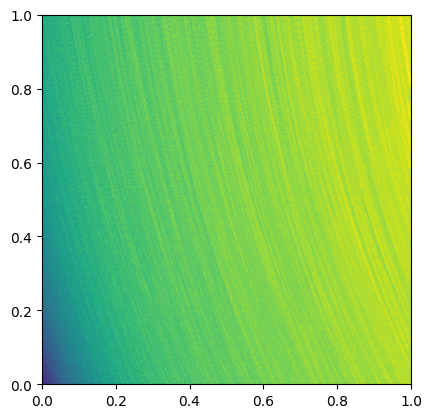

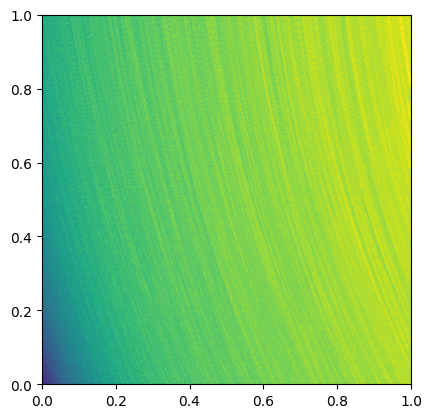

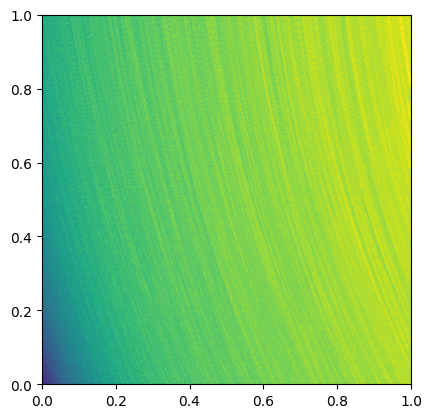

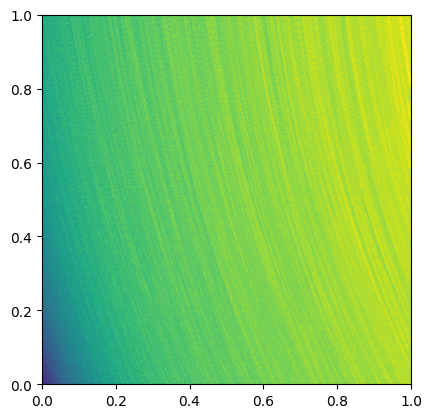

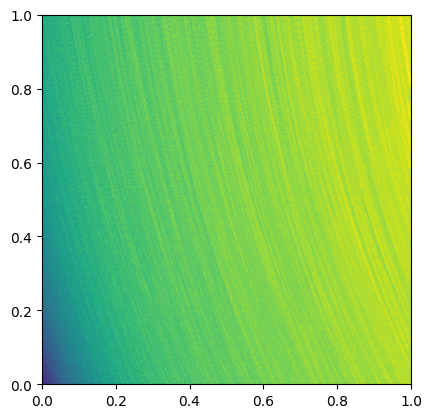

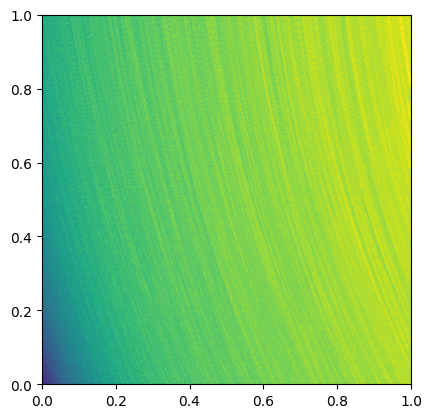

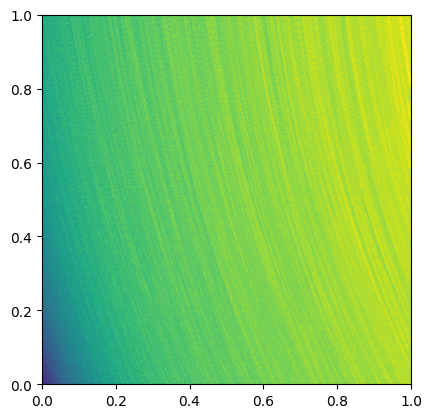

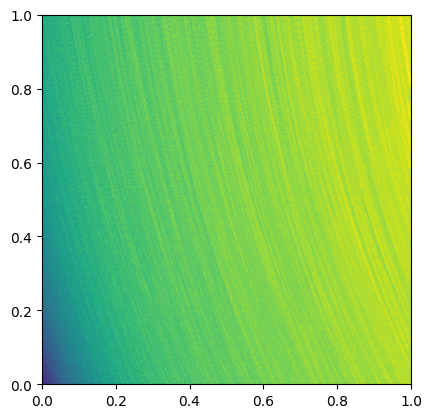

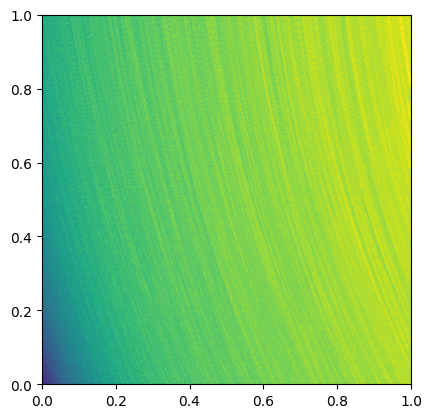

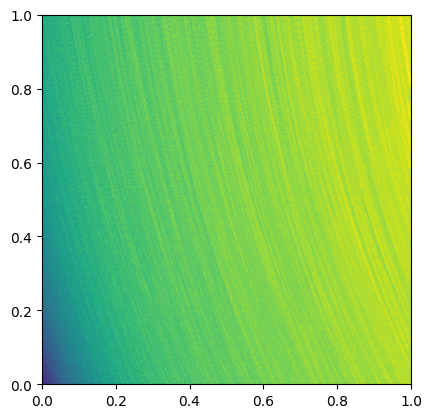

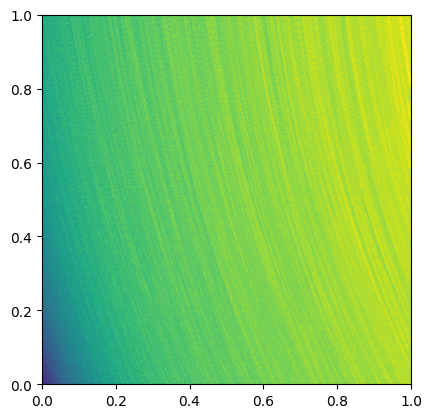

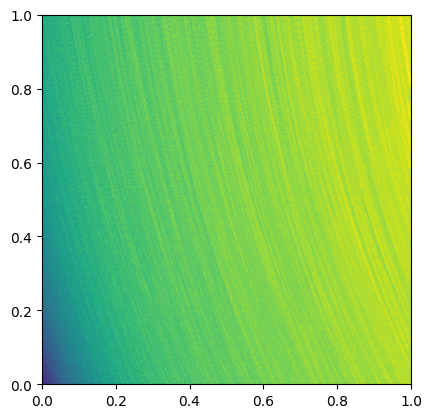

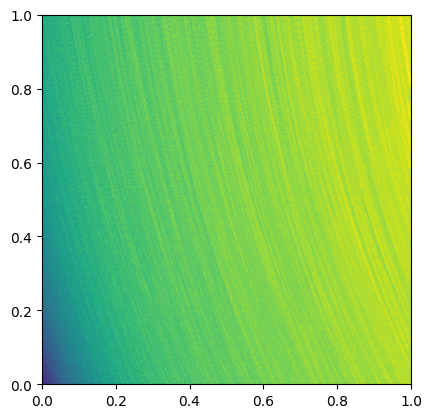

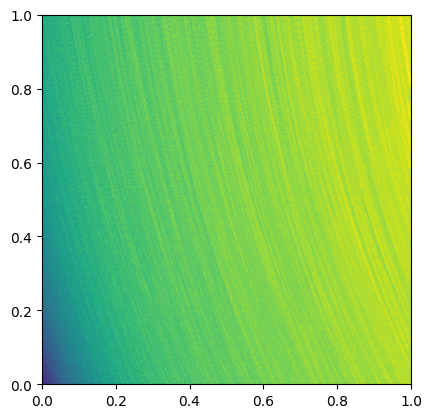

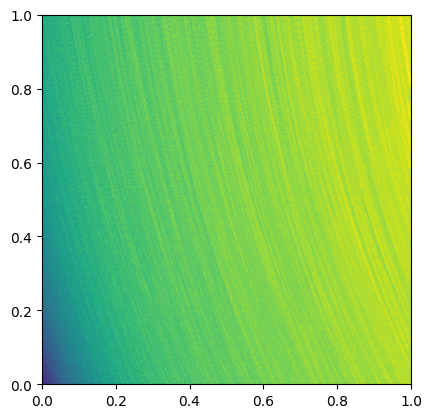

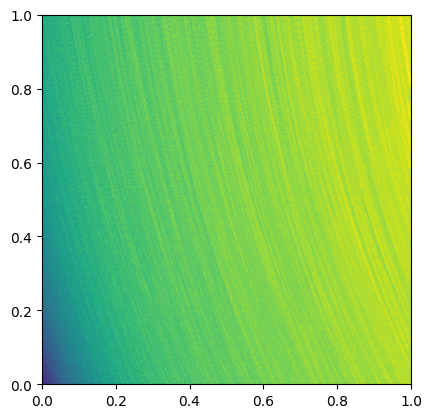

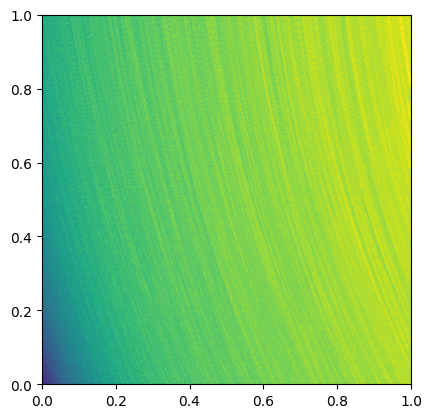

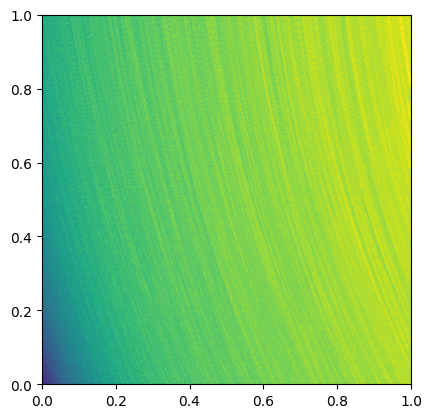

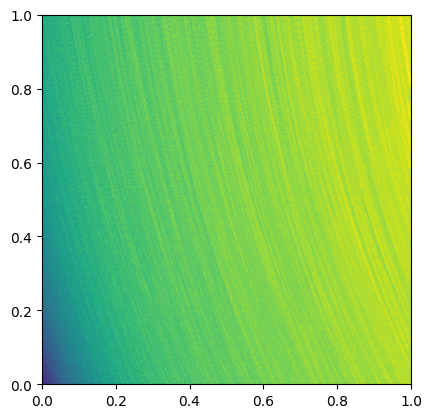

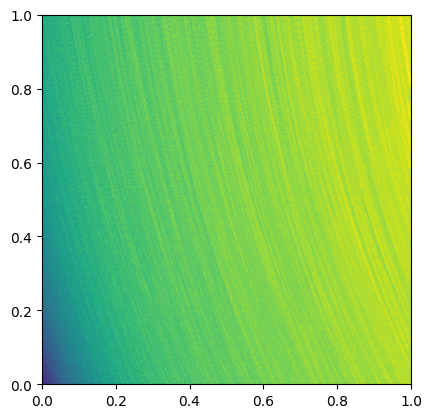

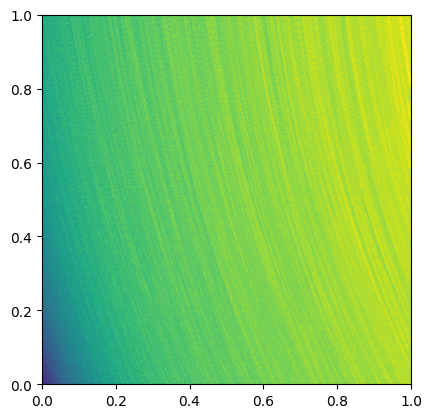

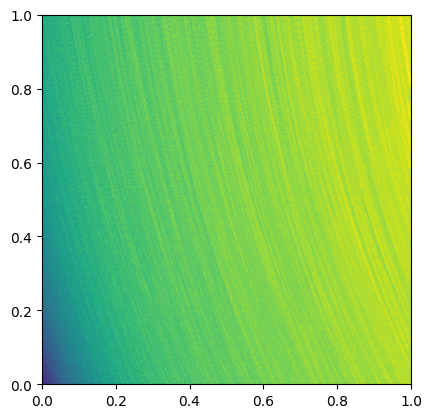

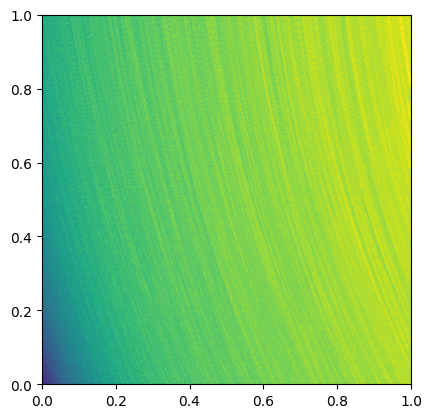

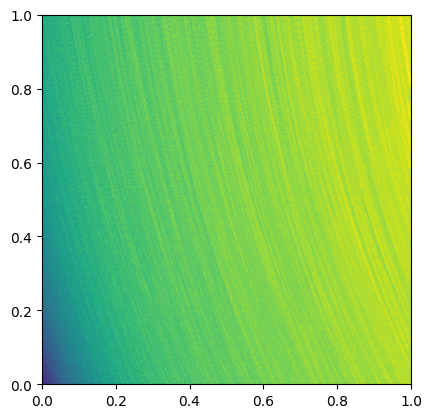

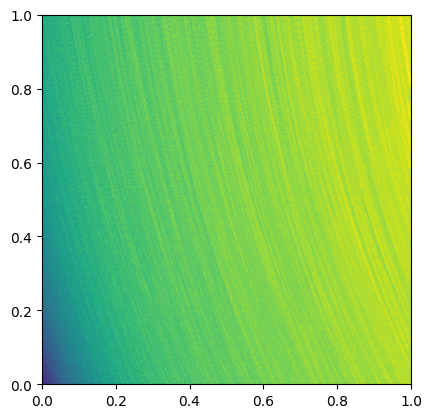

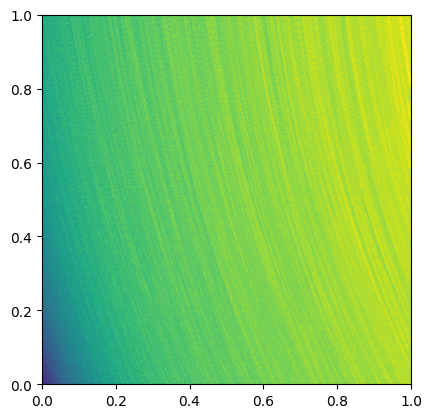

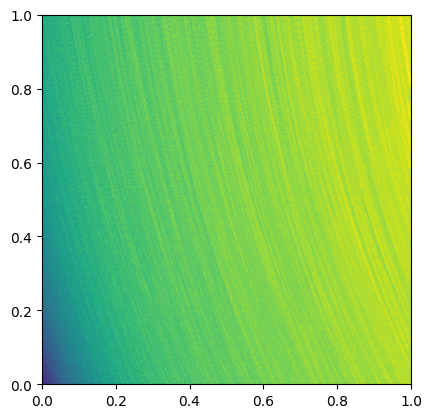

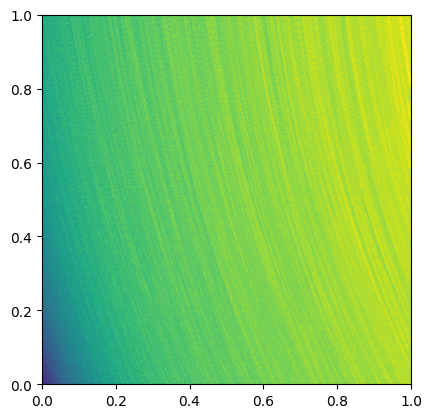

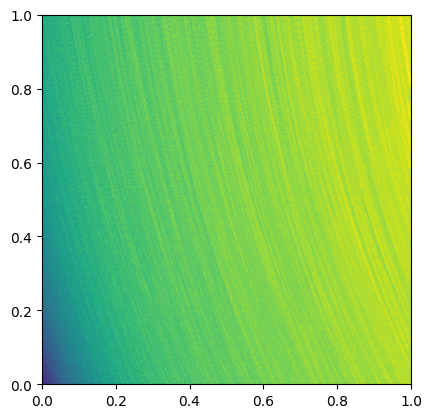

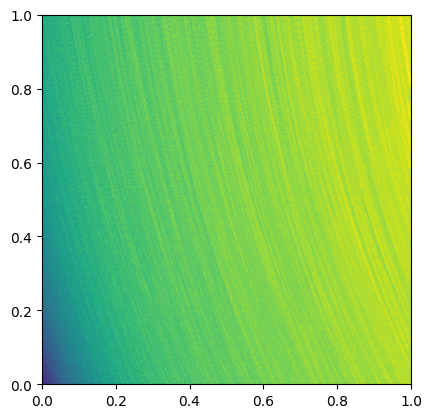

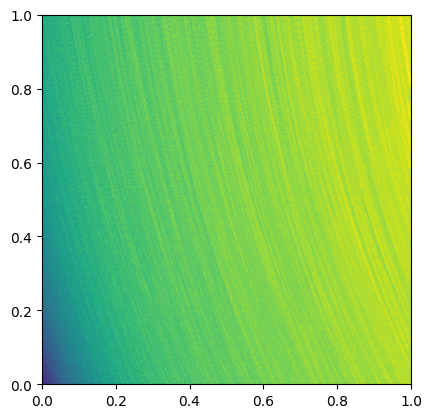

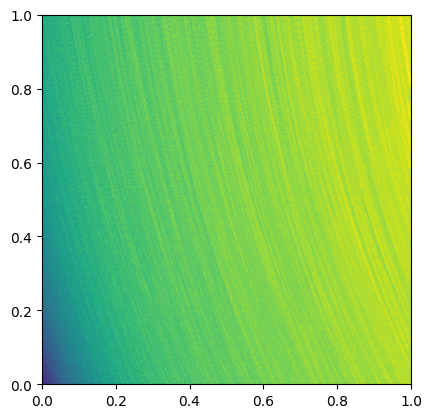

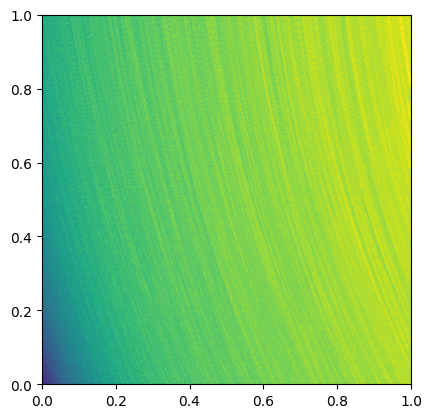

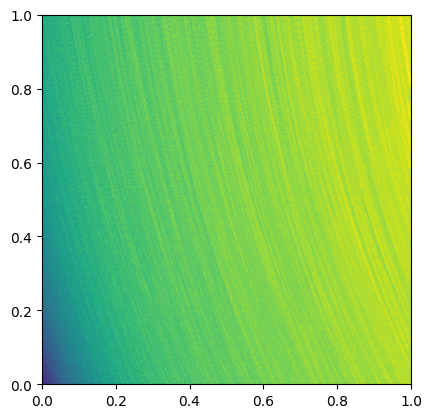

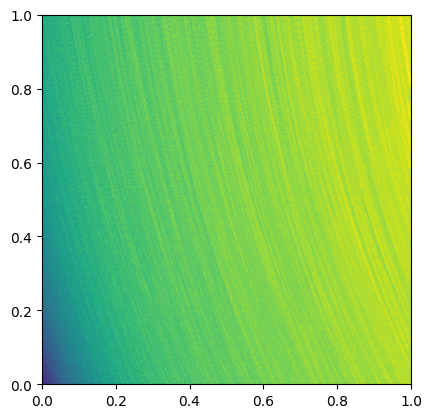

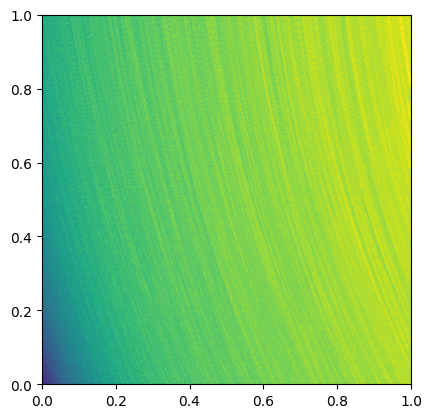

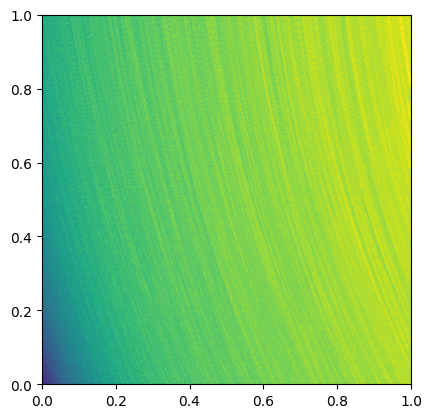

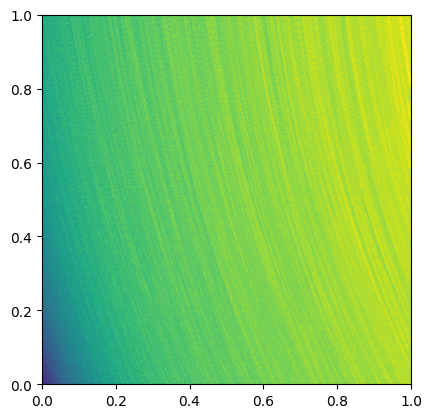

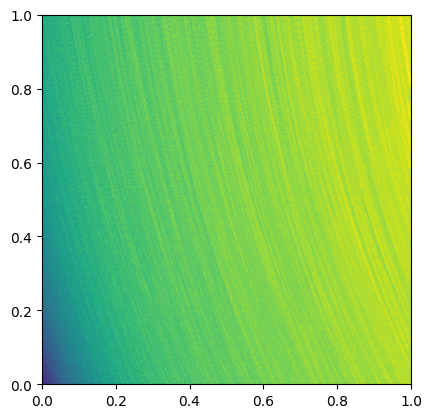

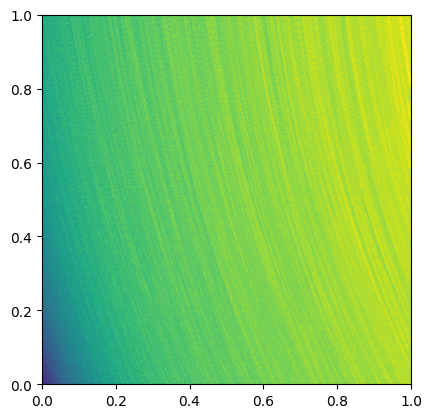

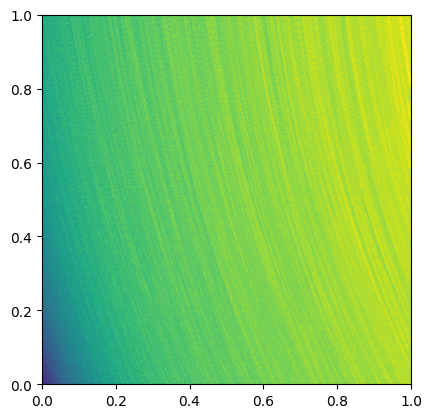

In [ ]:
# Evaluate on the whole computational domain
for i in range(50):
#u = to_numpy(model(x_test))
#x = to_numpy(x_test)
    x = np.linspace(0.0, 1.0, 401)                                   # Partitioned spatial axis
    y = np.linspace(0.0, 1.0, 400)                                   # Partitioned spatial axis
    t = np.linspace(0.20, 0.20, 1)                                        # Partitioned time axis
    t_grid, x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
    T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
    X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
    Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
    x_test = np.hstack((T, X, Y))                                            # Vectorized whole domain
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    u = to_numpy(model(x_test))
    #Xp,Yp = meshgrid(x,y)
    
    ue = np.zeros((401,400))
    for i in range(0,401):
        for j in range(0,400):
            ue[i,j] = u[j*400+i,3]
            
    plt.figure()
    plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,50)
    #plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.scatter(x_int_train[:,1],)
    #plt.pcolor(x[:],u[:,1])
    #plt.pcolor(x[:],u[:,2])
    ax = plt.gca()
    ax.set_aspect(1)
    plt.savefig("test_rasterization.png", dpi=150)
    plt.show()
 
    #    uo = ue.flatten()[:,None]
    #    uxy= np.hstack((X, Y,uo))                                            # Vectorized whole domain


In [14]:
#np.savetxt('Riemannv100.txt', uxy)
t = np.linspace(Tend, Tend, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0, Lx, 800)                                   # Partitioned spatial axis
y = np.linspace(0.0, Ly, 800)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(model(x_test))
#Xp,Yp = meshgrid(x,y)


ue = np.zeros((800,800))
for j in range(0,800):
    for i in range(0,800):
        ue[i,j] = u[i*800+j,0]
uo = ue.flatten()[:,None]
uxy= np.hstack((X, Y,uo))     

np.savetxt('shockCrho.txt', uxy)# Vectorized whole domain

<Figure size 640x480 with 0 Axes>

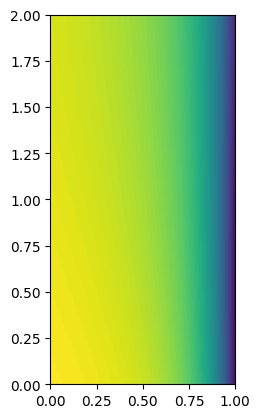

In [15]:
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,100)
#plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.scatter(x_int_train[:,1],)
#plt.pcolor(x[:],u[:,1])
#plt.pcolor(x[:],u[:,2])
ax = plt.gca()
ax.set_aspect(1)
plt.show()
plt.savefig("Riemann2.pdf", dpi=150)


In [35]:
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#surf = ax.plot_surface(x_grid[:,0,:], y_grid[:,0,:], ue, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#
## Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
## A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#
## Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()

In [ ]:
torch.save(model,'2DRiemanncase8.pt')

In [ ]:
model

In [ ]:
#device1 = torch.device("cpu")
#model.load_state_dict(torch.load(PATH))
#model = model.to(device1)
#torch.save(model,'2DRiemanncase8.pt')
model = torch.load('2DRiemanncase8.pt')

In [ ]:
model